In [163]:
import sys
import SimpleITK as sitk
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline 

import numpy as np
from numpy import array, zeros_like
from scipy.ndimage import zoom

import os
import fnmatch
import shutil
from ipywidgets import interact, fixed
import pandas as pd
from pathlib import Path

from skimage import data
from skimage import color
from skimage import img_as_float
from skimage import exposure
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean, pyramid_expand
from skimage.transform import rotate
from skimage import io
from scipy.ndimage import rotate as rotate_nd
from skimage import img_as_ubyte
from PIL import Image

#parallel computing packages
from numba import jit
import psutil
from multiprocess import Pool

#function for showing volume images
def myshow(image_arr,slice_n):
    plt.imshow(image_arr[slice_n,:,:],cmap='gray')
    plt.show()

In [2]:
df=pd.read_pickle('/mnt/e/Image Processing/Brats Project/final_pickle.pkl')

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.25)

## Rescaling to [ 0,1 ]

In [ ]:
def rescale_to(data,col, newmin_value=0, newmax_value=1):
    
    def to_norm(array, newmin = newmin_value, newmax=newmax_value): 
        norm_arr=(array - array.min()) * ((newmax - newmin) / (array.max() - array.min())) + newmin
        return norm_arr
    
    def go_and_norm():
        for i,y in enumerate(data.loc[:, col]):
            data.at[i, col] = to_norm(y)
            print('making {} for you ...'.format(i))
    
    go_and_norm()
    print('All done.')






In [ ]:
rescale_to(df, 'X')

## Data Augmentation 

In [ ]:
#check for only tumor indexes, to augment only images with tumors
def check_tumor(data, col): 
    indexes = []
    counter=0
    for i,y in enumerate(data.loc[:, col]): 
        if len(np.unique(y)) == 4:
            print(i)
            indexes.append(i)
            counter += 1
    print('All done!The number of images with tumors is {} and number of images without tumor is {}'.format(counter, len(data.index)-counter))
    return indexes




def go_and_augment(data,indexes, col=['X', 'Y'], augmentation = ['hor_flip','vert_flip', 'rotate_10_m10']):
    counter = len(data.index)
    
    for index, image in enumerate(data.loc[:, col[0]]):
        
        if index in indexes:
            
            #augmented_image = np.zeros((240,240,3), dtype='uint8') #empty arrays for augmented image
            #augmented_label = np.zeros((240,240), dtype='uint8') #for labels
            
            if augmentation[0]=='hor_flip':
                augmented_image = image[:, ::-1]
                augmented_label = data.loc[index, col[1]][:, ::-1]
                
                data.at[counter, col[0]] = augmented_image
                data.at[counter, col[1]] = augmented_label
            
                print('{} {} DONE!...images added to {}'.format(index, augmentation[0], counter))
                counter += 1
                
            if augmentation[1]=='vert_flip':
                augmented_image=image[::-1, :]
                augmented_label = data.loc[index, col[1]][::-1, :]
                
                data.at[counter, col[0]] = augmented_image
                data.at[counter, col[1]] = augmented_label
                
                
                print('{} {} DONE!...'.format(index, augmentation[1], counter))
                counter += 1
            
            if augmentation[2]=='rotate_10_m10':
                
                augmented_image=rotate(image, -10)
                augmented_label=rotate(data.loc[index, col[1]], -10)
                
                data.at[counter, col[0]] = augmented_image
                data.at[counter, col[1]] = augmented_label
                counter += 1
                print('{} {} DONE!...'.format(index, augmentation[2], counter))
                
                augmented_image=rotate(image, 10)
                augmented_label=rotate(data.loc[index, col[1]], 10)
                
                data.at[counter, col[0]] = augmented_image
                data.at[counter, col[1]] = augmented_label
                counter += 1
                print('{} {} DONE!...'.format(index, augmentation[2], counter))
            
            
df = df.append(df.iloc[0], ignore_index=True)            
            
            
            
            

In [ ]:
ind = check_tumor(df, 'Y') #creating list of indexes to augment

go_and_augment(df, ind) #go and augment, rotations 10 -10, vertical and horizontal flips! images and labels

In [ ]:
image=df.X[56896]
label=df.Y[56896]

In [ ]:
plt.imshow(image)

In [ ]:
plt.imshow(label)

In [130]:
#adding to our training dataset edema images only to improve edema segmentation 

edema_index = []
values = [0,2]
for i,y in enumerate(train.loc[:, 'Y']):
    l=np.isin(values, y)
    if l.all()==True and len(np.unique(y)) == 2:
        edema_index.append(train.index[i])
    
            

In [153]:
a = train.Y[edema_index[60]]

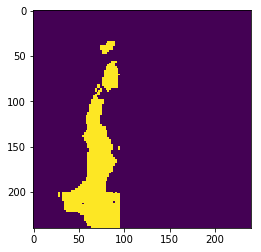

In [193]:
plt.imshow(im)

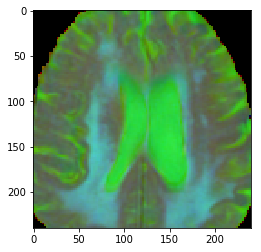

In [208]:
plt.imshow(img)

## Augmenting dataset with 'edema' images 

In [211]:
#images
@jit
def get_edema_images(data, col='X'):



    for i in range(len(edema_index)):
    
        b = data.loc[edema_index[i], col]
        roi=b[lx // 4: - lx // 4, ly // 4: - ly // 4] #sacling brain to receive bigger picture 
    
        im = pyramid_expand(roi, upscale=2, sigma=0, order=0, mode='constant', cval=0, multichannel=True)
    
        img = img_as_ubyte(im)
        print('{} DONE!'.format(edema_index[i]))
    
    
    
    
        name=str(edema_index[i])+'.png'
        io.imsave('/mnt/e/Image Processing/Brats Project/data/images_train/'+name, img)     
        print('{} image saved to corresponding directory!'.format(edema_index[i]))

In [213]:
#labels
@jit
def get_edema_labels(data, col='Y'):
    for i in range(len(edema_index)):
        b = data.loc[edema_index[i], col]
        roi=b[lx // 4: - lx // 4, ly // 4: - ly // 4] #sacling brain to receive bigger picture 
        im = pyramid_expand(roi, upscale=2, sigma=0, order=0, mode='constant', cval=0, multichannel=False)
        lab=img_as_ubyte(im)
        print('{} DONE!'.format(edema_index[i]))
        
        
        name=str(edema_index[i])+'.png'
        io.imsave('/mnt/e/Image Processing/Brats Project/data/masks_train/'+name, lab)     
        print('{} image saved to corresponding directory!'.format(edema_index[i]))
        
    
    

In [214]:
get_edema_images(train)
get_edema_labels(train)

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


18679 DONE!
18679 image saved to corresponding directory!
19204 DONE!
19204 image saved to corresponding directory!
36160 DONE!
36160 image saved to corresponding directory!
8126 DONE!
8126 image saved to corresponding directory!
29232 DONE!
29232 image saved to corresponding directory!
11937 DONE!
11937 image saved to corresponding directory!
18559 DONE!
18559 image saved to corresponding directory!
1768 DONE!
1768 image saved to corresponding directory!
21821 DONE!
21821 image saved to corresponding directory!
21816 DONE!
21816 image saved to corresponding directory!
16315 DONE!
16315 image saved to corresponding directory!
10899 DONE!
10899 image saved to corresponding directory!
30833 DONE!
30833 image saved to corresponding directory!
19981 DONE!
19981 image saved to corresponding directory!
36296 DONE!
36296 image saved to corresponding directory!
13854 DONE!
13854 image saved to corresponding directory!
3091 DONE!
3091 image saved to corresponding directory!
12253 DONE!
12253 im

25890 image saved to corresponding directory!
31532 DONE!
31532 image saved to corresponding directory!
8358 DONE!
8358 image saved to corresponding directory!
32050 DONE!
32050 image saved to corresponding directory!
18538 DONE!
18538 image saved to corresponding directory!
34875 DONE!
34875 image saved to corresponding directory!
597 DONE!
597 image saved to corresponding directory!
6066 DONE!
6066 image saved to corresponding directory!
1028 DONE!
1028 image saved to corresponding directory!
36611 DONE!
36611 image saved to corresponding directory!
27268 DONE!
27268 image saved to corresponding directory!
23911 DONE!
23911 image saved to corresponding directory!
11868 DONE!
11868 image saved to corresponding directory!
18192 DONE!
18192 image saved to corresponding directory!
33853 DONE!
33853 image saved to corresponding directory!
22900 DONE!
22900 image saved to corresponding directory!
35050 DONE!
35050 image saved to corresponding directory!
11241 DONE!
11241 image saved to cor

3305 image saved to corresponding directory!
36615 DONE!
36615 image saved to corresponding directory!
3457 DONE!
3457 image saved to corresponding directory!
24137 DONE!
24137 image saved to corresponding directory!
23209 DONE!
23209 image saved to corresponding directory!
18375 DONE!
18375 image saved to corresponding directory!
11639 DONE!
11639 image saved to corresponding directory!
15960 DONE!
15960 image saved to corresponding directory!
17343 DONE!
17343 image saved to corresponding directory!
16487 DONE!
16487 image saved to corresponding directory!
21890 DONE!
21890 image saved to corresponding directory!
4898 DONE!
4898 image saved to corresponding directory!
22245 DONE!
22245 image saved to corresponding directory!
10880 DONE!
10880 image saved to corresponding directory!
7528 DONE!
7528 image saved to corresponding directory!
14155 DONE!
14155 image saved to corresponding directory!
35678 DONE!
35678 image saved to corresponding directory!
17706 DONE!
17706 image saved to 

9417 image saved to corresponding directory!
26353 DONE!
26353 image saved to corresponding directory!
20266 DONE!
20266 image saved to corresponding directory!
600 DONE!
600 image saved to corresponding directory!
26225 DONE!
26225 image saved to corresponding directory!
23080 DONE!
23080 image saved to corresponding directory!
36867 DONE!
36867 image saved to corresponding directory!
14379 DONE!
14379 image saved to corresponding directory!
17055 DONE!
17055 image saved to corresponding directory!
25586 DONE!
25586 image saved to corresponding directory!
13640 DONE!
13640 image saved to corresponding directory!
9415 DONE!
9415 image saved to corresponding directory!
28650 DONE!
28650 image saved to corresponding directory!
19193 DONE!
19193 image saved to corresponding directory!
30503 DONE!
30503 image saved to corresponding directory!
5444 DONE!
5444 image saved to corresponding directory!
23756 DONE!
23756 image saved to corresponding directory!
12015 DONE!
12015 image saved to co

12833 image saved to corresponding directory!
32643 DONE!
32643 image saved to corresponding directory!
5524 DONE!
5524 image saved to corresponding directory!
17870 DONE!
17870 image saved to corresponding directory!
24779 DONE!
24779 image saved to corresponding directory!
35049 DONE!
35049 image saved to corresponding directory!
19272 DONE!
19272 image saved to corresponding directory!
4069 DONE!
4069 image saved to corresponding directory!
896 DONE!
896 image saved to corresponding directory!
11487 DONE!
11487 image saved to corresponding directory!
13457 DONE!
13457 image saved to corresponding directory!
32787 DONE!
32787 image saved to corresponding directory!
25044 DONE!
25044 image saved to corresponding directory!
26508 DONE!
26508 image saved to corresponding directory!
16496 DONE!
16496 image saved to corresponding directory!
36878 DONE!
36878 image saved to corresponding directory!
1795 DONE!
1795 image saved to corresponding directory!
34101 DONE!
34101 image saved to cor

14143 image saved to corresponding directory!
4772 DONE!
4772 image saved to corresponding directory!
16305 DONE!
16305 image saved to corresponding directory!
11475 DONE!
11475 image saved to corresponding directory!
15407 DONE!
15407 image saved to corresponding directory!
6420 DONE!
6420 image saved to corresponding directory!
29011 DONE!
29011 image saved to corresponding directory!
24012 DONE!
24012 image saved to corresponding directory!
8705 DONE!
8705 image saved to corresponding directory!
2066 DONE!
2066 image saved to corresponding directory!
21129 DONE!
21129 image saved to corresponding directory!
11863 DONE!
11863 image saved to corresponding directory!
32059 DONE!
32059 image saved to corresponding directory!
4769 DONE!
4769 image saved to corresponding directory!
31911 DONE!
31911 image saved to corresponding directory!
5638 DONE!
5638 image saved to corresponding directory!
1221 DONE!
1221 image saved to corresponding directory!
13287 DONE!
13287 image saved to corresp

29957 image saved to corresponding directory!
9473 DONE!
9473 image saved to corresponding directory!
27616 DONE!
27616 image saved to corresponding directory!
11229 DONE!
11229 image saved to corresponding directory!
4891 DONE!
4891 image saved to corresponding directory!
10164 DONE!
10164 image saved to corresponding directory!
3566 DONE!
3566 image saved to corresponding directory!
1090 DONE!
1090 image saved to corresponding directory!
32802 DONE!
32802 image saved to corresponding directory!
8929 DONE!
8929 image saved to corresponding directory!
7739 DONE!
7739 image saved to corresponding directory!
12556 DONE!
12556 image saved to corresponding directory!
891 DONE!
891 image saved to corresponding directory!
13675 DONE!
13675 image saved to corresponding directory!
30892 DONE!
30892 image saved to corresponding directory!
30491 DONE!
30491 image saved to corresponding directory!
8426 DONE!
8426 image saved to corresponding directory!
24273 DONE!
24273 image saved to correspondi

24524 image saved to corresponding directory!
10213 DONE!
10213 image saved to corresponding directory!
1897 DONE!
1897 image saved to corresponding directory!
3864 DONE!
3864 image saved to corresponding directory!
31296 DONE!
31296 image saved to corresponding directory!
4775 DONE!
4775 image saved to corresponding directory!
4453 DONE!
4453 image saved to corresponding directory!
20353 DONE!
20353 image saved to corresponding directory!
30442 DONE!
30442 image saved to corresponding directory!
4966 DONE!
4966 image saved to corresponding directory!
27264 DONE!
27264 image saved to corresponding directory!
9938 DONE!
9938 image saved to corresponding directory!
11243 DONE!
11243 image saved to corresponding directory!
12632 DONE!
12632 image saved to corresponding directory!
22573 DONE!
22573 image saved to corresponding directory!
13459 DONE!
13459 image saved to corresponding directory!
8041 DONE!
8041 image saved to corresponding directory!
29185 DONE!
29185 image saved to corresp

32220 image saved to corresponding directory!
18537 DONE!
18537 image saved to corresponding directory!
7531 DONE!
7531 image saved to corresponding directory!
22954 DONE!
22954 image saved to corresponding directory!
14376 DONE!
14376 image saved to corresponding directory!
21401 DONE!
21401 image saved to corresponding directory!
26928 DONE!
26928 image saved to corresponding directory!
14934 DONE!
14934 image saved to corresponding directory!
16235 DONE!
16235 image saved to corresponding directory!
6822 DONE!
6822 image saved to corresponding directory!
14185 DONE!
14185 image saved to corresponding directory!
14084 DONE!
14084 image saved to corresponding directory!
7241 DONE!
7241 image saved to corresponding directory!
29300 DONE!
29300 image saved to corresponding directory!
5641 DONE!
5641 image saved to corresponding directory!
15403 DONE!
15403 image saved to corresponding directory!
4307 DONE!
4307 image saved to corresponding directory!
19542 DONE!
19542 image saved to cor

19473 image saved to corresponding directory!
12062 DONE!
12062 image saved to corresponding directory!
32058 DONE!
32058 image saved to corresponding directory!
9169 DONE!
9169 image saved to corresponding directory!
30413 DONE!
30413 image saved to corresponding directory!
25333 DONE!
25333 image saved to corresponding directory!
10706 DONE!
10706 image saved to corresponding directory!
17612 DONE!
17612 image saved to corresponding directory!
2909 DONE!
2909 image saved to corresponding directory!
8468 DONE!
8468 image saved to corresponding directory!
32055 DONE!
32055 image saved to corresponding directory!
23472 DONE!
23472 image saved to corresponding directory!
1536 DONE!
1536 image saved to corresponding directory!
36915 DONE!
36915 image saved to corresponding directory!
17536 DONE!
17536 image saved to corresponding directory!
29727 DONE!
29727 image saved to corresponding directory!
4210 DONE!
4210 image saved to corresponding directory!
8252 DONE!
8252 image saved to corre

9143 image saved to corresponding directory!
15649 DONE!
15649 image saved to corresponding directory!
14786 DONE!
14786 image saved to corresponding directory!
11752 DONE!
11752 image saved to corresponding directory!
7631 DONE!
7631 image saved to corresponding directory!
13850 DONE!
13850 image saved to corresponding directory!
19863 DONE!
19863 image saved to corresponding directory!
11227 DONE!
11227 image saved to corresponding directory!
22835 DONE!
22835 image saved to corresponding directory!
12905 DONE!
12905 image saved to corresponding directory!
13666 DONE!
13666 image saved to corresponding directory!
2333 DONE!
2333 image saved to corresponding directory!
888 DONE!
888 image saved to corresponding directory!
26668 DONE!
26668 image saved to corresponding directory!
2624 DONE!
2624 image saved to corresponding directory!
22671 DONE!
22671 image saved to corresponding directory!
7040 DONE!
7040 image saved to corresponding directory!
27261 DONE!
27261 image saved to corres

10640 image saved to corresponding directory!
11235 DONE!
11235 image saved to corresponding directory!
8082 DONE!
8082 image saved to corresponding directory!
14665 DONE!
14665 image saved to corresponding directory!
31391 DONE!
31391 image saved to corresponding directory!
34690 DONE!
34690 image saved to corresponding directory!
9301 DONE!
9301 image saved to corresponding directory!
2399 DONE!
2399 image saved to corresponding directory!
15325 DONE!
15325 image saved to corresponding directory!
19602 DONE!
19602 image saved to corresponding directory!
21759 DONE!
21759 image saved to corresponding directory!
758 DONE!
758 image saved to corresponding directory!
12553 DONE!
12553 image saved to corresponding directory!
19615 DONE!
19615 image saved to corresponding directory!
21952 DONE!
21952 image saved to corresponding directory!
15417 DONE!
15417 image saved to corresponding directory!
1220 DONE!
1220 image saved to corresponding directory!
28954 DONE!
28954 image saved to corre

8508 DONE!
8508 image saved to corresponding directory!
17762 DONE!
17762 image saved to corresponding directory!
25338 DONE!
25338 image saved to corresponding directory!
26510 DONE!
26510 image saved to corresponding directory!
19405 DONE!
19405 image saved to corresponding directory!
16311 DONE!
16311 image saved to corresponding directory!
10586 DONE!
10586 image saved to corresponding directory!
31173 DONE!
31173 image saved to corresponding directory!
3368 DONE!
3368 image saved to corresponding directory!
4608 DONE!
4608 image saved to corresponding directory!
33394 DONE!
33394 image saved to corresponding directory!
16313 DONE!
16313 image saved to corresponding directory!
20490 DONE!
20490 image saved to corresponding directory!
2956 DONE!
2956 image saved to corresponding directory!
15841 DONE!
15841 image saved to corresponding directory!
17270 DONE!
17270 image saved to corresponding directory!
15955 DONE!
15955 image saved to corresponding directory!
9589 DONE!
9589 image 

16591 image saved to corresponding directory!
36696 DONE!
36696 image saved to corresponding directory!
2697 DONE!
2697 image saved to corresponding directory!
11228 DONE!
11228 image saved to corresponding directory!
34171 DONE!
34171 image saved to corresponding directory!
6170 DONE!
6170 image saved to corresponding directory!
35054 DONE!
35054 image saved to corresponding directory!
2160 DONE!
2160 image saved to corresponding directory!
1025 DONE!
1025 image saved to corresponding directory!
34558 DONE!
34558 image saved to corresponding directory!
6171 DONE!
6171 image saved to corresponding directory!
21944 DONE!
21944 image saved to corresponding directory!
4900 DONE!
4900 image saved to corresponding directory!
29992 DONE!
29992 image saved to corresponding directory!
14183 DONE!
14183 image saved to corresponding directory!
30084 DONE!
30084 image saved to corresponding directory!
13986 DONE!
13986 image saved to corresponding directory!
21274 DONE!
21274 image saved to corre

12255 image saved to corresponding directory!
26308 DONE!
26308 image saved to corresponding directory!
2276 DONE!
2276 image saved to corresponding directory!
18495 DONE!
18495 image saved to corresponding directory!
34928 DONE!
34928 image saved to corresponding directory!
29944 DONE!
29944 image saved to corresponding directory!
16918 DONE!
16918 image saved to corresponding directory!
26963 DONE!
26963 image saved to corresponding directory!
15141 DONE!
15141 image saved to corresponding directory!
12645 DONE!
12645 image saved to corresponding directory!
6433 DONE!
6433 image saved to corresponding directory!
29074 DONE!
29074 image saved to corresponding directory!
24786 DONE!
24786 image saved to corresponding directory!
36874 DONE!
36874 image saved to corresponding directory!
31389 DONE!
31389 image saved to corresponding directory!
28323 DONE!
28323 image saved to corresponding directory!
1034 DONE!
1034 image saved to corresponding directory!
10713 DONE!
10713 image saved to

10048 image saved to corresponding directory!
34098 DONE!
34098 image saved to corresponding directory!
28761 DONE!
28761 image saved to corresponding directory!
2944 DONE!
2944 image saved to corresponding directory!
13989 DONE!
13989 image saved to corresponding directory!
29757 DONE!
29757 image saved to corresponding directory!
21894 DONE!
21894 image saved to corresponding directory!
19987 DONE!
19987 image saved to corresponding directory!
16232 DONE!
16232 image saved to corresponding directory!
16686 DONE!
16686 image saved to corresponding directory!
23352 DONE!
23352 image saved to corresponding directory!
23743 DONE!
23743 image saved to corresponding directory!
7861 DONE!
7861 image saved to corresponding directory!
7246 DONE!
7246 image saved to corresponding directory!
18889 DONE!
18889 image saved to corresponding directory!
2537 DONE!
2537 image saved to corresponding directory!
4449 DONE!
4449 image saved to corresponding directory!
17398 DONE!
17398 image saved to cor

4306 image saved to corresponding directory!
19535 DONE!
19535 image saved to corresponding directory!
24135 DONE!
24135 image saved to corresponding directory!
25971 DONE!
25971 image saved to corresponding directory!
21404 DONE!
21404 image saved to corresponding directory!
3935 DONE!
3935 image saved to corresponding directory!
30069 DONE!
30069 image saved to corresponding directory!
23473 DONE!
23473 image saved to corresponding directory!
7309 DONE!
7309 image saved to corresponding directory!
14275 DONE!
14275 image saved to corresponding directory!
3860 DONE!
3860 image saved to corresponding directory!
8996 DONE!
8996 image saved to corresponding directory!
23642 DONE!
23642 image saved to corresponding directory!
29932 DONE!
29932 image saved to corresponding directory!
4105 DONE!
4105 image saved to corresponding directory!
11485 DONE!
11485 image saved to corresponding directory!
8359 DONE!
8359 image saved to corresponding directory!
30500 DONE!
30500 image saved to corres

30775 image saved to corresponding directory!
30441 DONE!
30441 image saved to corresponding directory!
12516 DONE!
12516 image saved to corresponding directory!
4207 DONE!
4207 image saved to corresponding directory!
20265 DONE!
20265 image saved to corresponding directory!
29735 DONE!
29735 image saved to corresponding directory!
14378 DONE!
14378 image saved to corresponding directory!
22902 DONE!
22902 image saved to corresponding directory!
7312 DONE!
7312 image saved to corresponding directory!
24528 DONE!
24528 image saved to corresponding directory!
10036 DONE!
10036 image saved to corresponding directory!
14751 DONE!
14751 image saved to corresponding directory!
13683 DONE!
13683 image saved to corresponding directory!
26965 DONE!
26965 image saved to corresponding directory!
35507 DONE!
35507 image saved to corresponding directory!
19868 DONE!
19868 image saved to corresponding directory!
4761 DONE!
4761 image saved to corresponding directory!
30140 DONE!
30140 image saved to

11165 image saved to corresponding directory!
14259 DONE!
14259 image saved to corresponding directory!
35052 DONE!
35052 image saved to corresponding directory!
15900 DONE!
15900 image saved to corresponding directory!
16583 DONE!
16583 image saved to corresponding directory!
21813 DONE!
21813 image saved to corresponding directory!
21515 DONE!
21515 image saved to corresponding directory!
7529 DONE!
7529 image saved to corresponding directory!
9656 DONE!
9656 image saved to corresponding directory!
14791 DONE!
14791 image saved to corresponding directory!
13665 DONE!
13665 image saved to corresponding directory!
34175 DONE!
34175 image saved to corresponding directory!
16585 DONE!
16585 image saved to corresponding directory!
11099 DONE!
11099 image saved to corresponding directory!
12130 DONE!
12130 image saved to corresponding directory!
31121 DONE!
31121 image saved to corresponding directory!
10751 DONE!
10751 image saved to corresponding directory!
12460 DONE!
12460 image saved 

11550 image saved to corresponding directory!
4452 DONE!
4452 image saved to corresponding directory!
4711 DONE!
4711 image saved to corresponding directory!
20 DONE!
20 image saved to corresponding directory!
13590 DONE!
13590 image saved to corresponding directory!
31252 DONE!
31252 image saved to corresponding directory!
29747 DONE!
29747 image saved to corresponding directory!
18806 DONE!
18806 image saved to corresponding directory!
14248 DONE!
14248 image saved to corresponding directory!
36695 DONE!
36695 image saved to corresponding directory!
10653 DONE!
10653 image saved to corresponding directory!
35967 DONE!
35967 image saved to corresponding directory!
9658 DONE!
9658 image saved to corresponding directory!
9297 DONE!
9297 image saved to corresponding directory!
22905 DONE!
22905 image saved to corresponding directory!
9940 DONE!
9940 image saved to corresponding directory!
30777 DONE!
30777 image saved to corresponding directory!
4762 DONE!
4762 image saved to correspondi

9290 image saved to corresponding directory!
29445 DONE!
29445 image saved to corresponding directory!
7892 DONE!
7892 image saved to corresponding directory!
34174 DONE!
34174 image saved to corresponding directory!
29942 DONE!
29942 image saved to corresponding directory!
10188 DONE!
10188 image saved to corresponding directory!
31907 DONE!
31907 image saved to corresponding directory!
19399 DONE!
19399 image saved to corresponding directory!
18955 DONE!
18955 image saved to corresponding directory!
3547 DONE!
3547 image saved to corresponding directory!
6427 DONE!
6427 image saved to corresponding directory!
19470 DONE!
19470 image saved to corresponding directory!
24029 DONE!
24029 image saved to corresponding directory!
5310 DONE!
5310 image saved to corresponding directory!
2162 DONE!
2162 image saved to corresponding directory!
31376 DONE!
31376 image saved to corresponding directory!
11478 DONE!
11478 image saved to corresponding directory!
34930 DONE!
34930 image saved to corr

18001 image saved to corresponding directory!
8083 DONE!
8083 image saved to corresponding directory!
31390 DONE!
31390 image saved to corresponding directory!
14785 DONE!
14785 image saved to corresponding directory!
4853 DONE!
4853 image saved to corresponding directory!
29179 DONE!
29179 image saved to corresponding directory!
17402 DONE!
17402 image saved to corresponding directory!
16274 DONE!
16274 image saved to corresponding directory!
6289 DONE!
6289 image saved to corresponding directory!
27601 DONE!
27601 image saved to corresponding directory!
29598 DONE!
29598 image saved to corresponding directory!
14093 DONE!
14093 image saved to corresponding directory!
3451 DONE!
3451 image saved to corresponding directory!
6413 DONE!
6413 image saved to corresponding directory!
2279 DONE!
2279 image saved to corresponding directory!
18038 DONE!
18038 image saved to corresponding directory!
14874 DONE!
14874 image saved to corresponding directory!
9650 DONE!
9650 image saved to corresp

27649 DONE!
27649 image saved to corresponding directory!
31394 DONE!
31394 image saved to corresponding directory!
32648 DONE!
32648 image saved to corresponding directory!
7305 DONE!
7305 image saved to corresponding directory!
34565 DONE!
34565 image saved to corresponding directory!
31781 DONE!
31781 image saved to corresponding directory!
10583 DONE!
10583 image saved to corresponding directory!
20748 DONE!
20748 image saved to corresponding directory!
33859 DONE!
33859 image saved to corresponding directory!
32288 DONE!
32288 image saved to corresponding directory!
3565 DONE!
3565 image saved to corresponding directory!
6326 DONE!
6326 image saved to corresponding directory!
12940 DONE!
12940 image saved to corresponding directory!
12465 DONE!
12465 image saved to corresponding directory!
24133 DONE!
24133 image saved to corresponding directory!
23359 DONE!
23359 image saved to corresponding directory!
18803 DONE!
18803 image saved to corresponding directory!
33631 DONE!
33631 im

23199 DONE!
23199 image saved to corresponding directory!
18037 DONE!
18037 image saved to corresponding directory!
32222 DONE!
32222 image saved to corresponding directory!
34623 DONE!
34623 image saved to corresponding directory!
11946 DONE!
11946 image saved to corresponding directory!
4110 DONE!
4110 image saved to corresponding directory!
14101 DONE!
14101 image saved to corresponding directory!
23347 DONE!
23347 image saved to corresponding directory!
3877 DONE!
3877 image saved to corresponding directory!
7750 DONE!
7750 image saved to corresponding directory!
19075 DONE!
19075 image saved to corresponding directory!
20574 DONE!
20574 image saved to corresponding directory!
15784 DONE!
15784 image saved to corresponding directory!
26929 DONE!
26929 image saved to corresponding directory!
25037 DONE!
25037 image saved to corresponding directory!
24145 DONE!
24145 image saved to corresponding directory!
12552 DONE!
12552 image saved to corresponding directory!
23463 DONE!
23463 im

33856 image saved to corresponding directory!
31377 DONE!
31377 image saved to corresponding directory!
7588 DONE!
7588 image saved to corresponding directory!
32934 DONE!
32934 image saved to corresponding directory!
7743 DONE!
7743 image saved to corresponding directory!
11094 DONE!
11094 image saved to corresponding directory!
16986 DONE!
16986 image saved to corresponding directory!
5307 DONE!
5307 image saved to corresponding directory!
29807 DONE!
29807 image saved to corresponding directory!
27203 DONE!
27203 image saved to corresponding directory!
13292 DONE!
13292 image saved to corresponding directory!
7733 DONE!
7733 image saved to corresponding directory!
30989 DONE!
30989 image saved to corresponding directory!
25681 DONE!
25681 image saved to corresponding directory!
23640 DONE!
23640 image saved to corresponding directory!
17605 DONE!
17605 image saved to corresponding directory!
1287 DONE!
1287 image saved to corresponding directory!
7632 DONE!
7632 image saved to corre

8521 image saved to corresponding directory!
18954 DONE!
18954 image saved to corresponding directory!
10721 DONE!
10721 image saved to corresponding directory!
2686 DONE!
2686 image saved to corresponding directory!
21948 DONE!
21948 image saved to corresponding directory!
35263 DONE!
35263 image saved to corresponding directory!
30080 DONE!
30080 image saved to corresponding directory!
19469 DONE!
19469 image saved to corresponding directory!
8122 DONE!
8122 image saved to corresponding directory!
14187 DONE!
14187 image saved to corresponding directory!
2698 DONE!
2698 image saved to corresponding directory!
10047 DONE!
10047 image saved to corresponding directory!
8932 DONE!
8932 image saved to corresponding directory!
15323 DONE!
15323 image saved to corresponding directory!
30189 DONE!
30189 image saved to corresponding directory!
21756 DONE!
21756 image saved to corresponding directory!
16685 DONE!
16685 image saved to corresponding directory!
26812 DONE!
26812 image saved to co

31783 image saved to corresponding directory!
13858 DONE!
13858 image saved to corresponding directory!
13828 DONE!
13828 image saved to corresponding directory!
7451 DONE!
7451 image saved to corresponding directory!
33624 DONE!
33624 image saved to corresponding directory!
35672 DONE!
35672 image saved to corresponding directory!
24144 DONE!
24144 image saved to corresponding directory!
35569 DONE!
35569 image saved to corresponding directory!
21815 DONE!
21815 image saved to corresponding directory!
1393 DONE!
1393 image saved to corresponding directory!
26667 DONE!
26667 image saved to corresponding directory!
27747 DONE!
27747 image saved to corresponding directory!
2337 DONE!
2337 image saved to corresponding directory!
21828 DONE!
21828 image saved to corresponding directory!
11629 DONE!
11629 image saved to corresponding directory!
24514 DONE!
24514 image saved to corresponding directory!
1158 DONE!
1158 image saved to corresponding directory!
24594 DONE!
24594 image saved to c

26357 image saved to corresponding directory!
18444 DONE!
18444 image saved to corresponding directory!
3373 DONE!
3373 image saved to corresponding directory!
4892 DONE!
4892 image saved to corresponding directory!
7370 DONE!
7370 image saved to corresponding directory!
18437 DONE!
18437 image saved to corresponding directory!
12138 DONE!
12138 image saved to corresponding directory!
14267 DONE!
14267 image saved to corresponding directory!
26233 DONE!
26233 image saved to corresponding directory!
20620 DONE!
20620 image saved to corresponding directory!
22782 DONE!
22782 image saved to corresponding directory!
10348 DONE!
10348 image saved to corresponding directory!
11220 DONE!
11220 image saved to corresponding directory!
898 DONE!
898 image saved to corresponding directory!
34247 DONE!
34247 image saved to corresponding directory!
12050 DONE!
12050 image saved to corresponding directory!
30071 DONE!
30071 image saved to corresponding directory!
13825 DONE!
13825 image saved to cor

11223 image saved to corresponding directory!
8700 DONE!
8700 image saved to corresponding directory!
11640 DONE!
11640 image saved to corresponding directory!
26364 DONE!
26364 image saved to corresponding directory!
9162 DONE!
9162 image saved to corresponding directory!
8884 DONE!
8884 image saved to corresponding directory!
31284 DONE!
31284 image saved to corresponding directory!
30078 DONE!
30078 image saved to corresponding directory!
3307 DONE!
3307 image saved to corresponding directory!
8507 DONE!
8507 image saved to corresponding directory!
8623 DONE!
8623 image saved to corresponding directory!
5575 DONE!
5575 image saved to corresponding directory!
35046 DONE!
35046 image saved to corresponding directory!
25852 DONE!
25852 image saved to corresponding directory!
4854 DONE!
4854 image saved to corresponding directory!
25671 DONE!
25671 image saved to corresponding directory!
4252 DONE!
4252 image saved to corresponding directory!
17408 DONE!
17408 image saved to correspondi

5636 image saved to corresponding directory!
31380 DONE!
31380 image saved to corresponding directory!
12509 DONE!
12509 image saved to corresponding directory!
3523 DONE!
3523 image saved to corresponding directory!
8129 DONE!
8129 image saved to corresponding directory!
4602 DONE!
4602 image saved to corresponding directory!
3874 DONE!
3874 image saved to corresponding directory!
24526 DONE!
24526 image saved to corresponding directory!
31374 DONE!
31374 image saved to corresponding directory!
13679 DONE!
13679 image saved to corresponding directory!
32550 DONE!
32550 image saved to corresponding directory!
31906 DONE!
31906 image saved to corresponding directory!
10031 DONE!
10031 image saved to corresponding directory!
13633 DONE!
13633 image saved to corresponding directory!
549 DONE!
549 image saved to corresponding directory!
4770 DONE!
4770 image saved to corresponding directory!
6285 DONE!
6285 image saved to corresponding directory!
27139 DONE!
27139 image saved to correspond

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18679.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/19204.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/36160.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8126.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

8950 DONE!
8950 image saved to corresponding directory!
11245 DONE!
11245 image saved to corresponding directory!
27614 DONE!
27614 image saved to corresponding directory!
3093 DONE!
3093 image saved to corresponding directory!
1095 DONE!
1095 image saved to corresponding directory!
15406 DONE!
15406 image saved to corresponding directory!
13638 DONE!
13638 image saved to corresponding directory!
20758 DONE!
20758 image saved to corresponding directory!
14250 DONE!
14250 image saved to corresponding directory!
16687 DONE!
16687 image saved to corresponding directory!
26232 DONE!
26232 image saved to corresponding directory!
233 DONE!
233 image saved to corresponding directory!
36446 DONE!
36446 image saved to corresponding directory!
11748 DONE!
11748 image saved to corresponding directory!
27650 DONE!
27650 image saved to corresponding directory!
22439 DONE!
22439 image saved to corresponding directory!
14251 DONE!
14251 image saved to corresponding directory!
36554 DONE!
36554 image 

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/27614.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/3093.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/1095.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/15406.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats P

2166 DONE!
2166 image saved to corresponding directory!
6410 DONE!
6410 image saved to corresponding directory!
18548 DONE!
18548 image saved to corresponding directory!
26966 DONE!
26966 image saved to corresponding directory!
9936 DONE!
9936 image saved to corresponding directory!
32492 DONE!
32492 image saved to corresponding directory!
8422 DONE!
8422 image saved to corresponding directory!
27610 DONE!
27610 image saved to corresponding directory!
20487 DONE!
20487 image saved to corresponding directory!
21280 DONE!
21280 image saved to corresponding directory!
34176 DONE!
34176 image saved to corresponding directory!
26360 DONE!
26360 image saved to corresponding directory!
30262 DONE!
30262 image saved to corresponding directory!
32285 DONE!
32285 image saved to corresponding directory!
2958 DONE!
2958 image saved to corresponding directory!
2242 DONE!
2242 image saved to corresponding directory!
23753 DONE!
23753 image saved to corresponding directory!
9220 DONE!
9220 image save

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18548.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/26966.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9936.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/32492.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

35050 image saved to corresponding directory!
11241 DONE!
11241 image saved to corresponding directory!
4359 DONE!
4359 image saved to corresponding directory!
9459 DONE!
9459 image saved to corresponding directory!
5941 DONE!
5941 image saved to corresponding directory!
16974 DONE!
16974 image saved to corresponding directory!
32427 DONE!
32427 image saved to corresponding directory!
875 DONE!
875 image saved to corresponding directory!
12013 DONE!
12013 image saved to corresponding directory!
31289 DONE!
31289 image saved to corresponding directory!
26975 DONE!
26975 image saved to corresponding directory!
15834 DONE!
15834 image saved to corresponding directory!
22957 DONE!
22957 image saved to corresponding directory!
9416 DONE!
9416 image saved to corresponding directory!
14621 DONE!
14621 image saved to corresponding directory!
22742 DONE!
22742 image saved to corresponding directory!
22831 DONE!
22831 image saved to corresponding directory!
30836 DONE!
30836 image saved to corre

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/4359.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9459.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5941.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/16974.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pr

24079 image saved to corresponding directory!
11498 DONE!
11498 image saved to corresponding directory!
26226 DONE!
26226 image saved to corresponding directory!
21213 DONE!
21213 image saved to corresponding directory!
18183 DONE!
18183 image saved to corresponding directory!
29228 DONE!
29228 image saved to corresponding directory!
20866 DONE!
20866 image saved to corresponding directory!
26093 DONE!
26093 image saved to corresponding directory!
17610 DONE!
17610 image saved to corresponding directory!
20580 DONE!
20580 image saved to corresponding directory!
8428 DONE!
8428 image saved to corresponding directory!
28762 DONE!
28762 image saved to corresponding directory!
33350 DONE!
33350 image saved to corresponding directory!
8956 DONE!
8956 image saved to corresponding directory!
4774 DONE!
4774 image saved to corresponding directory!
15847 DONE!
15847 image saved to corresponding directory!
6421 DONE!
6421 image saved to corresponding directory!
5376 DONE!
5376 image saved to cor

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/26226.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21213.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18183.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/29228.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

31373 image saved to corresponding directory!
33634 DONE!
33634 image saved to corresponding directory!
28750 DONE!
28750 image saved to corresponding directory!
10900 DONE!
10900 image saved to corresponding directory!
14184 DONE!
14184 image saved to corresponding directory!
5697 DONE!
5697 image saved to corresponding directory!
21887 DONE!
21887 image saved to corresponding directory!
22675 DONE!
22675 image saved to corresponding directory!
7879 DONE!
7879 image saved to corresponding directory!
3727 DONE!
3727 image saved to corresponding directory!
29958 DONE!
29958 image saved to corresponding directory!
8121 DONE!
8121 image saved to corresponding directory!
6876 DONE!
6876 image saved to corresponding directory!
25331 DONE!
25331 image saved to corresponding directory!
11630 DONE!
11630 image saved to corresponding directory!
33754 DONE!
33754 image saved to corresponding directory!
29453 DONE!
29453 image saved to corresponding directory!
18673 DONE!
18673 image saved to cor

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/28750.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10900.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/14184.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5697.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

19865 image saved to corresponding directory!
36175 DONE!
36175 image saved to corresponding directory!
7446 DONE!
7446 image saved to corresponding directory!
30268 DONE!
30268 image saved to corresponding directory!
30097 DONE!
30097 image saved to corresponding directory!
16980 DONE!
16980 image saved to corresponding directory!
29186 DONE!
29186 image saved to corresponding directory!
19138 DONE!
19138 image saved to corresponding directory!
29477 DONE!
29477 image saved to corresponding directory!
26935 DONE!
26935 image saved to corresponding directory!
9151 DONE!
9151 image saved to corresponding directory!
20766 DONE!
20766 image saved to corresponding directory!
17400 DONE!
17400 image saved to corresponding directory!
25455 DONE!
25455 image saved to corresponding directory!
32799 DONE!
32799 image saved to corresponding directory!
462 DONE!
462 image saved to corresponding directory!
29930 DONE!
29930 image saved to corresponding directory!
21220 DONE!
21220 image saved to c

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/7446.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/30268.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/30097.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/16980.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

5279 image saved to corresponding directory!
14556 DONE!
14556 image saved to corresponding directory!
7589 DONE!
7589 image saved to corresponding directory!
22290 DONE!
22290 image saved to corresponding directory!
35840 DONE!
35840 image saved to corresponding directory!
6875 DONE!
6875 image saved to corresponding directory!
88 DONE!
88 image saved to corresponding directory!
3870 DONE!
3870 image saved to corresponding directory!
874 DONE!
874 image saved to corresponding directory!
4782 DONE!
4782 image saved to corresponding directory!
8889 DONE!
8889 image saved to corresponding directory!
30088 DONE!
30088 image saved to corresponding directory!
6874 DONE!
6874 image saved to corresponding directory!
14871 DONE!
14871 image saved to corresponding directory!
7532 DONE!
7532 image saved to corresponding directory!
2010 DONE!
2010 image saved to corresponding directory!
11166 DONE!
11166 image saved to corresponding directory!
9303 DONE!
9303 image saved to corresponding director

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/7589.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/22290.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/35840.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/6875.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats P

2328 image saved to corresponding directory!
892 DONE!
892 image saved to corresponding directory!
2622 DONE!
2622 image saved to corresponding directory!
14617 DONE!
14617 image saved to corresponding directory!
33007 DONE!
33007 image saved to corresponding directory!
767 DONE!
767 image saved to corresponding directory!
25036 DONE!
25036 image saved to corresponding directory!
11401 DONE!
11401 image saved to corresponding directory!
15954 DONE!
15954 image saved to corresponding directory!
17218 DONE!
17218 image saved to corresponding directory!
35514 DONE!
35514 image saved to corresponding directory!
19400 DONE!
19400 image saved to corresponding directory!
25145 DONE!
25145 image saved to corresponding directory!
9293 DONE!
9293 image saved to corresponding directory!
31401 DONE!
31401 image saved to corresponding directory!
87 DONE!
87 image saved to corresponding directory!
31784 DONE!
31784 image saved to corresponding directory!
871 DONE!
871 image saved to corresponding di

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2622.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/14617.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/33007.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/767.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pr

17875 DONE!
17875 image saved to corresponding directory!
2696 DONE!
2696 image saved to corresponding directory!
9061 DONE!
9061 image saved to corresponding directory!
16678 DONE!
16678 image saved to corresponding directory!
11488 DONE!
11488 image saved to corresponding directory!
8882 DONE!
8882 image saved to corresponding directory!
1798 DONE!
1798 image saved to corresponding directory!
30891 DONE!
30891 image saved to corresponding directory!
4002 DONE!
4002 image saved to corresponding directory!
29996 DONE!
29996 image saved to corresponding directory!
769 DONE!
769 image saved to corresponding directory!
31782 DONE!
31782 image saved to corresponding directory!
8045 DONE!
8045 image saved to corresponding directory!
5843 DONE!
5843 image saved to corresponding directory!
3942 DONE!
3942 image saved to corresponding directory!
25445 DONE!
25445 image saved to corresponding directory!
9999 DONE!
9999 image saved to corresponding directory!
1769 DONE!
1769 image saved to corre

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2696.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9061.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/16678.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11488.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats P

8891 DONE!
8891 image saved to corresponding directory!
34436 DONE!
34436 image saved to corresponding directory!
28023 DONE!
28023 image saved to corresponding directory!
19869 DONE!
19869 image saved to corresponding directory!
4785 DONE!
4785 image saved to corresponding directory!
15895 DONE!
15895 image saved to corresponding directory!
1771 DONE!
1771 image saved to corresponding directory!
22938 DONE!
22938 image saved to corresponding directory!
27604 DONE!
27604 image saved to corresponding directory!
21664 DONE!
21664 image saved to corresponding directory!
15404 DONE!
15404 image saved to corresponding directory!
29728 DONE!
29728 image saved to corresponding directory!
27602 DONE!
27602 image saved to corresponding directory!
28255 DONE!
28255 image saved to corresponding directory!
4354 DONE!
4354 image saved to corresponding directory!
6817 DONE!
6817 image saved to corresponding directory!
11871 DONE!
11871 image saved to corresponding directory!
1029 DONE!
1029 image sa

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/34436.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/28023.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/19869.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/4785.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

29993 image saved to corresponding directory!
9585 DONE!
9585 image saved to corresponding directory!
27201 DONE!
27201 image saved to corresponding directory!
19078 DONE!
19078 image saved to corresponding directory!
2948 DONE!
2948 image saved to corresponding directory!
3098 DONE!
3098 image saved to corresponding directory!
21214 DONE!
21214 image saved to corresponding directory!
36162 DONE!
36162 image saved to corresponding directory!
5698 DONE!
5698 image saved to corresponding directory!
17702 DONE!
17702 image saved to corresponding directory!
4609 DONE!
4609 image saved to corresponding directory!
36907 DONE!
36907 image saved to corresponding directory!
9516 DONE!
9516 image saved to corresponding directory!
3301 DONE!
3301 image saved to corresponding directory!
11943 DONE!
11943 image saved to corresponding directory!
18289 DONE!
18289 image saved to corresponding directory!
30146 DONE!
30146 image saved to corresponding directory!
18500 DONE!
18500 image saved to corresp

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/27201.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/19078.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2948.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/3098.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats P

20486 DONE!
20486 image saved to corresponding directory!
25043 DONE!
25043 image saved to corresponding directory!
11486 DONE!
11486 image saved to corresponding directory!
11168 DONE!
11168 image saved to corresponding directory!
17873 DONE!
17873 image saved to corresponding directory!
23428 DONE!
23428 image saved to corresponding directory!
29602 DONE!
29602 image saved to corresponding directory!
3572 DONE!
3572 image saved to corresponding directory!
34642 DONE!
34642 image saved to corresponding directory!
9944 DONE!
9944 image saved to corresponding directory!
33391 DONE!
33391 image saved to corresponding directory!
9517 DONE!
9517 image saved to corresponding directory!
7365 DONE!
7365 image saved to corresponding directory!
11826 DONE!
11826 image saved to corresponding directory!
19986 DONE!
19986 image saved to corresponding directory!
3557 DONE!
3557 image saved to corresponding directory!
15491 DONE!
15491 image saved to corresponding directory!
9523 DONE!
9523 image sa

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/25043.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11486.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11168.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17873.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

619 image saved to corresponding directory!
10897 DONE!
10897 image saved to corresponding directory!
34249 DONE!
34249 image saved to corresponding directory!
613 DONE!
613 image saved to corresponding directory!
2159 DONE!
2159 image saved to corresponding directory!
6277 DONE!
6277 image saved to corresponding directory!
27612 DONE!
27612 image saved to corresponding directory!
374 DONE!
374 image saved to corresponding directory!
25726 DONE!
25726 image saved to corresponding directory!
2941 DONE!
2941 image saved to corresponding directory!
10046 DONE!
10046 image saved to corresponding directory!
10173 DONE!
10173 image saved to corresponding directory!
13298 DONE!
13298 image saved to corresponding directory!
27548 DONE!
27548 image saved to corresponding directory!
30266 DONE!
30266 image saved to corresponding directory!
21279 DONE!
21279 image saved to corresponding directory!
28652 DONE!
28652 image saved to corresponding directory!
6173 DONE!
6173 image saved to correspondi

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/34249.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/613.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2159.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/6277.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

20080 image saved to corresponding directory!
8258 DONE!
8258 image saved to corresponding directory!
19805 DONE!
19805 image saved to corresponding directory!
22246 DONE!
22246 image saved to corresponding directory!
9152 DONE!
9152 image saved to corresponding directory!
18191 DONE!
18191 image saved to corresponding directory!
17868 DONE!
17868 image saved to corresponding directory!
17991 DONE!
17991 image saved to corresponding directory!
22959 DONE!
22959 image saved to corresponding directory!
4450 DONE!
4450 image saved to corresponding directory!
13060 DONE!
13060 image saved to corresponding directory!
25341 DONE!
25341 image saved to corresponding directory!
34104 DONE!
34104 image saved to corresponding directory!
6824 DONE!
6824 image saved to corresponding directory!
1395 DONE!
1395 image saved to corresponding directory!
14143 DONE!
14143 image saved to corresponding directory!
4772 DONE!
4772 image saved to corresponding directory!
16305 DONE!
16305 image saved to corre

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/19805.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/22246.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9152.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18191.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

1887 image saved to corresponding directory!
7885 DONE!
7885 image saved to corresponding directory!
20867 DONE!
20867 image saved to corresponding directory!
30089 DONE!
30089 image saved to corresponding directory!
12243 DONE!
12243 image saved to corresponding directory!
2934 DONE!
2934 image saved to corresponding directory!
22670 DONE!
22670 image saved to corresponding directory!
2282 DONE!
2282 image saved to corresponding directory!
12642 DONE!
12642 image saved to corresponding directory!
28330 DONE!
28330 image saved to corresponding directory!
29805 DONE!
29805 image saved to corresponding directory!
13632 DONE!
13632 image saved to corresponding directory!
36616 DONE!
36616 image saved to corresponding directory!
15153 DONE!
15153 image saved to corresponding directory!
25030 DONE!
25030 image saved to corresponding directory!
30504 DONE!
30504 image saved to corresponding directory!
28257 DONE!
28257 image saved to corresponding directory!
15570 DONE!
15570 image saved to 

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/20867.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/30089.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12243.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2934.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

235 image saved to corresponding directory!
15713 DONE!
15713 image saved to corresponding directory!
4968 DONE!
4968 image saved to corresponding directory!
17479 DONE!
17479 image saved to corresponding directory!
12136 DONE!
12136 image saved to corresponding directory!
16230 DONE!
16230 image saved to corresponding directory!
20764 DONE!
20764 image saved to corresponding directory!
25033 DONE!
25033 image saved to corresponding directory!
15843 DONE!
15843 image saved to corresponding directory!
11306 DONE!
11306 image saved to corresponding directory!
26550 DONE!
26550 image saved to corresponding directory!
15415 DONE!
15415 image saved to corresponding directory!
26509 DONE!
26509 image saved to corresponding directory!
5926 DONE!
5926 image saved to corresponding directory!
20360 DONE!
20360 image saved to corresponding directory!
21084 DONE!
21084 image saved to corresponding directory!
18380 DONE!
18380 image saved to corresponding directory!
12249 DONE!
12249 image saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/4968.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17479.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12136.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/16230.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

16491 image saved to corresponding directory!
8698 DONE!
8698 image saved to corresponding directory!
25578 DONE!
25578 image saved to corresponding directory!
9346 DONE!
9346 image saved to corresponding directory!
22955 DONE!
22955 image saved to corresponding directory!
10866 DONE!
10866 image saved to corresponding directory!
19809 DONE!
19809 image saved to corresponding directory!
29957 DONE!
29957 image saved to corresponding directory!
9473 DONE!
9473 image saved to corresponding directory!
27616 DONE!
27616 image saved to corresponding directory!
11229 DONE!
11229 image saved to corresponding directory!
4891 DONE!
4891 image saved to corresponding directory!
10164 DONE!
10164 image saved to corresponding directory!
3566 DONE!
3566 image saved to corresponding directory!
1090 DONE!
1090 image saved to corresponding directory!
32802 DONE!
32802 image saved to corresponding directory!
8929 DONE!
8929 image saved to corresponding directory!
7739 DONE!
7739 image saved to correspon

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/25578.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9346.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/22955.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10866.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

5145 DONE!
5145 image saved to corresponding directory!
3981 DONE!
3981 image saved to corresponding directory!
31251 DONE!
31251 image saved to corresponding directory!
29374 DONE!
29374 image saved to corresponding directory!
13059 DONE!
13059 image saved to corresponding directory!
13631 DONE!
13631 image saved to corresponding directory!
14107 DONE!
14107 image saved to corresponding directory!
4712 DONE!
4712 image saved to corresponding directory!
17615 DONE!
17615 image saved to corresponding directory!
11929 DONE!
11929 image saved to corresponding directory!
16594 DONE!
16594 image saved to corresponding directory!
10889 DONE!
10889 image saved to corresponding directory!
4367 DONE!
4367 image saved to corresponding directory!
2798 DONE!
2798 image saved to corresponding directory!
29086 DONE!
29086 image saved to corresponding directory!
13466 DONE!
13466 image saved to corresponding directory!
12203 DONE!
12203 image saved to corresponding directory!
35833 DONE!
35833 image 

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/31251.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/29374.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13059.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13631.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

3236 image saved to corresponding directory!
12419 DONE!
12419 image saved to corresponding directory!
20765 DONE!
20765 image saved to corresponding directory!
31531 DONE!
31531 image saved to corresponding directory!
6550 DONE!
6550 image saved to corresponding directory!
21826 DONE!
21826 image saved to corresponding directory!
23260 DONE!
23260 image saved to corresponding directory!
366 DONE!
366 image saved to corresponding directory!
29683 DONE!
29683 image saved to corresponding directory!
24028 DONE!
24028 image saved to corresponding directory!
16028 DONE!
16028 image saved to corresponding directory!
9515 DONE!
9515 image saved to corresponding directory!
16027 DONE!
16027 image saved to corresponding directory!
11632 DONE!
11632 image saved to corresponding directory!
27540 DONE!
27540 image saved to corresponding directory!
18892 DONE!
18892 image saved to corresponding directory!
12549 DONE!
12549 image saved to corresponding directory!
16275 DONE!
16275 image saved to co

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/31531.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/6550.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21826.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/23260.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

4775 image saved to corresponding directory!
4453 DONE!
4453 image saved to corresponding directory!
20353 DONE!
20353 image saved to corresponding directory!
30442 DONE!
30442 image saved to corresponding directory!
4966 DONE!
4966 image saved to corresponding directory!
27264 DONE!
27264 image saved to corresponding directory!
9938 DONE!
9938 image saved to corresponding directory!
11243 DONE!
11243 image saved to corresponding directory!
12632 DONE!
12632 image saved to corresponding directory!
22573 DONE!
22573 image saved to corresponding directory!
13459 DONE!
13459 image saved to corresponding directory!
8041 DONE!
8041 image saved to corresponding directory!
29185 DONE!
29185 image saved to corresponding directory!
7888 DONE!
7888 image saved to corresponding directory!
15971 DONE!
15971 image saved to corresponding directory!
23346 DONE!
23346 image saved to corresponding directory!
6479 DONE!
6479 image saved to corresponding directory!
8998 DONE!
8998 image saved to correspo

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/30442.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/4966.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/27264.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9938.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats P

12635 image saved to corresponding directory!
12328 DONE!
12328 image saved to corresponding directory!
11757 DONE!
11757 image saved to corresponding directory!
5441 DONE!
5441 image saved to corresponding directory!
11100 DONE!
11100 image saved to corresponding directory!
23206 DONE!
23206 image saved to corresponding directory!
13629 DONE!
13629 image saved to corresponding directory!
3448 DONE!
3448 image saved to corresponding directory!
3983 DONE!
3983 image saved to corresponding directory!
756 DONE!
756 image saved to corresponding directory!
13291 DONE!
13291 image saved to corresponding directory!
18668 DONE!
18668 image saved to corresponding directory!
30195 DONE!
30195 image saved to corresponding directory!
15485 DONE!
15485 image saved to corresponding directory!
11238 DONE!
11238 image saved to corresponding directory!
5448 DONE!
5448 image saved to corresponding directory!
19077 DONE!
19077 image saved to corresponding directory!
18677 DONE!
18677 image saved to corre

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5441.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11100.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/23206.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13629.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

2327 image saved to corresponding directory!
4310 DONE!
4310 image saved to corresponding directory!
34685 DONE!
34685 image saved to corresponding directory!
13471 DONE!
13471 image saved to corresponding directory!
17340 DONE!
17340 image saved to corresponding directory!
10886 DONE!
10886 image saved to corresponding directory!
11637 DONE!
11637 image saved to corresponding directory!
2683 DONE!
2683 image saved to corresponding directory!
7881 DONE!
7881 image saved to corresponding directory!
1021 DONE!
1021 image saved to corresponding directory!
32947 DONE!
32947 image saved to corresponding directory!
11924 DONE!
11924 image saved to corresponding directory!
19806 DONE!
19806 image saved to corresponding directory!
23349 DONE!
23349 image saved to corresponding directory!
29227 DONE!
29227 image saved to corresponding directory!
11642 DONE!
11642 image saved to corresponding directory!
12682 DONE!
12682 image saved to corresponding directory!
3097 DONE!
3097 image saved to corr

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13471.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17340.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10886.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11637.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

14934 DONE!
14934 image saved to corresponding directory!
16235 DONE!
16235 image saved to corresponding directory!
6822 DONE!
6822 image saved to corresponding directory!
14185 DONE!
14185 image saved to corresponding directory!
14084 DONE!
14084 image saved to corresponding directory!
7241 DONE!
7241 image saved to corresponding directory!
29300 DONE!
29300 image saved to corresponding directory!
5641 DONE!
5641 image saved to corresponding directory!
15403 DONE!
15403 image saved to corresponding directory!
4307 DONE!
4307 image saved to corresponding directory!
19542 DONE!
19542 image saved to corresponding directory!
19195 DONE!
19195 image saved to corresponding directory!
15149 DONE!
15149 image saved to corresponding directory!
17534 DONE!
17534 image saved to corresponding directory!
26859 DONE!
26859 image saved to corresponding directory!
16676 DONE!
16676 image saved to corresponding directory!
2152 DONE!
2152 image saved to corresponding directory!
29959 DONE!
29959 image 

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/14185.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/14084.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/7241.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/29300.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

4776 image saved to corresponding directory!
23907 DONE!
23907 image saved to corresponding directory!
27723 DONE!
27723 image saved to corresponding directory!
10033 DONE!
10033 image saved to corresponding directory!
26306 DONE!
26306 image saved to corresponding directory!
7883 DONE!
7883 image saved to corresponding directory!
20824 DONE!
20824 image saved to corresponding directory!
1397 DONE!
1397 image saved to corresponding directory!
9947 DONE!
9947 image saved to corresponding directory!
18282 DONE!
18282 image saved to corresponding directory!
32156 DONE!
32156 image saved to corresponding directory!
12242 DONE!
12242 image saved to corresponding directory!
23211 DONE!
23211 image saved to corresponding directory!
23356 DONE!
23356 image saved to corresponding directory!
8050 DONE!
8050 image saved to corresponding directory!
2751 DONE!
2751 image saved to corresponding directory!
13853 DONE!
13853 image saved to corresponding directory!
16494 DONE!
16494 image saved to corr

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/26306.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/7883.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/20824.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/1397.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats P

12513 image saved to corresponding directory!
7735 DONE!
7735 image saved to corresponding directory!
20618 DONE!
20618 image saved to corresponding directory!
1168 DONE!
1168 image saved to corresponding directory!
12464 DONE!
12464 image saved to corresponding directory!
9476 DONE!
9476 image saved to corresponding directory!
10716 DONE!
10716 image saved to corresponding directory!
28956 DONE!
28956 image saved to corresponding directory!
15785 DONE!
15785 image saved to corresponding directory!
9347 DONE!
9347 image saved to corresponding directory!
8931 DONE!
8931 image saved to corresponding directory!
5870 DONE!
5870 image saved to corresponding directory!
15054 DONE!
15054 image saved to corresponding directory!
33561 DONE!
33561 image saved to corresponding directory!
5929 DONE!
5929 image saved to corresponding directory!
3939 DONE!
3939 image saved to corresponding directory!
9528 DONE!
9528 image saved to corresponding directory!
3453 DONE!
3453 image saved to corresponding

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/1168.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12464.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9476.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10716.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats P

18959 image saved to corresponding directory!
16677 DONE!
16677 image saved to corresponding directory!
19473 DONE!
19473 image saved to corresponding directory!
12062 DONE!
12062 image saved to corresponding directory!
32058 DONE!
32058 image saved to corresponding directory!
9169 DONE!
9169 image saved to corresponding directory!
30413 DONE!
30413 image saved to corresponding directory!
25333 DONE!
25333 image saved to corresponding directory!
10706 DONE!
10706 image saved to corresponding directory!
17612 DONE!
17612 image saved to corresponding directory!
2909 DONE!
2909 image saved to corresponding directory!
8468 DONE!
8468 image saved to corresponding directory!
32055 DONE!
32055 image saved to corresponding directory!
23472 DONE!
23472 image saved to corresponding directory!
1536 DONE!
1536 image saved to corresponding directory!
36915 DONE!
36915 image saved to corresponding directory!
17536 DONE!
17536 image saved to corresponding directory!
29727 DONE!
29727 image saved to c

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12062.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/32058.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/30413.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

30196 image saved to corresponding directory!
9474 DONE!
9474 image saved to corresponding directory!
18189 DONE!
18189 image saved to corresponding directory!
3865 DONE!
3865 image saved to corresponding directory!
21521 DONE!
21521 image saved to corresponding directory!
8946 DONE!
8946 image saved to corresponding directory!
8501 DONE!
8501 image saved to corresponding directory!
22019 DONE!
22019 image saved to corresponding directory!
4525 DONE!
4525 image saved to corresponding directory!
30499 DONE!
30499 image saved to corresponding directory!
24532 DONE!
24532 image saved to corresponding directory!
9579 DONE!
9579 image saved to corresponding directory!
30068 DONE!
30068 image saved to corresponding directory!
5944 DONE!
5944 image saved to corresponding directory!
17060 DONE!
17060 image saved to corresponding directory!
8131 DONE!
8131 image saved to corresponding directory!
7636 DONE!
7636 image saved to corresponding directory!
36301 DONE!
36301 image saved to correspondi

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21521.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8946.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8501.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/22019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats P

11497 image saved to corresponding directory!
22828 DONE!
22828 image saved to corresponding directory!
19196 DONE!
19196 image saved to corresponding directory!
18540 DONE!
18540 image saved to corresponding directory!
11560 DONE!
11560 image saved to corresponding directory!
9222 DONE!
9222 image saved to corresponding directory!
7325 DONE!
7325 image saved to corresponding directory!
4075 DONE!
4075 image saved to corresponding directory!
4848 DONE!
4848 image saved to corresponding directory!
15894 DONE!
15894 image saved to corresponding directory!
28325 DONE!
28325 image saved to corresponding directory!
1032 DONE!
1032 image saved to corresponding directory!
32002 DONE!
32002 image saved to corresponding directory!
22199 DONE!
22199 image saved to corresponding directory!
10054 DONE!
10054 image saved to corresponding directory!
8044 DONE!
8044 image saved to corresponding directory!
17620 DONE!
17620 image saved to corresponding directory!
9399 DONE!
9399 image saved to corresp

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11560.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9222.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/7325.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/4075.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pr

13666 image saved to corresponding directory!
2333 DONE!
2333 image saved to corresponding directory!
888 DONE!
888 image saved to corresponding directory!
26668 DONE!
26668 image saved to corresponding directory!
2624 DONE!
2624 image saved to corresponding directory!
22671 DONE!
22671 image saved to corresponding directory!
7040 DONE!
7040 image saved to corresponding directory!
27261 DONE!
27261 image saved to corresponding directory!
31581 DONE!
31581 image saved to corresponding directory!
15961 DONE!
15961 image saved to corresponding directory!
10588 DONE!
10588 image saved to corresponding directory!
28193 DONE!
28193 image saved to corresponding directory!
12199 DONE!
12199 image saved to corresponding directory!
24986 DONE!
24986 image saved to corresponding directory!
22838 DONE!
22838 image saved to corresponding directory!
4365 DONE!
4365 image saved to corresponding directory!
19972 DONE!
19972 image saved to corresponding directory!
28760 DONE!
28760 image saved to corre

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2624.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/22671.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/7040.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/27261.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats P

16026 DONE!
16026 image saved to corresponding directory!
18678 DONE!
18678 image saved to corresponding directory!
11942 DONE!
11942 image saved to corresponding directory!
13301 DONE!
13301 image saved to corresponding directory!
36876 DONE!
36876 image saved to corresponding directory!
29980 DONE!
29980 image saved to corresponding directory!
17701 DONE!
17701 image saved to corresponding directory!
23638 DONE!
23638 image saved to corresponding directory!
17613 DONE!
17613 image saved to corresponding directory!
16987 DONE!
16987 image saved to corresponding directory!
1286 DONE!
1286 image saved to corresponding directory!
27554 DONE!
27554 image saved to corresponding directory!
12945 DONE!
12945 image saved to corresponding directory!
25272 DONE!
25272 image saved to corresponding directory!
36303 DONE!
36303 image saved to corresponding directory!
24021 DONE!
24021 image saved to corresponding directory!
13859 DONE!
13859 image saved to corresponding directory!
34725 DONE!
3472

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13301.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/36876.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/29980.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17701.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

30260 DONE!
30260 image saved to corresponding directory!
29940 DONE!
29940 image saved to corresponding directory!
15209 DONE!
15209 image saved to corresponding directory!
21218 DONE!
21218 image saved to corresponding directory!
9294 DONE!
9294 image saved to corresponding directory!
29799 DONE!
29799 image saved to corresponding directory!
8737 DONE!
8737 image saved to corresponding directory!
4611 DONE!
4611 image saved to corresponding directory!
16159 DONE!
16159 image saved to corresponding directory!
12133 DONE!
12133 image saved to corresponding directory!
34632 DONE!
34632 image saved to corresponding directory!
24074 DONE!
24074 image saved to corresponding directory!
25027 DONE!
25027 image saved to corresponding directory!
9296 DONE!
9296 image saved to corresponding directory!
85 DONE!
85 image saved to corresponding directory!
8130 DONE!
8130 image saved to corresponding directory!
25335 DONE!
25335 image saved to corresponding directory!
6424 DONE!
6424 image saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9294.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/29799.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8737.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/4611.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pr

11551 image saved to corresponding directory!
31386 DONE!
31386 image saved to corresponding directory!
11827 DONE!
11827 image saved to corresponding directory!
35646 DONE!
35646 image saved to corresponding directory!
24361 DONE!
24361 image saved to corresponding directory!
31397 DONE!
31397 image saved to corresponding directory!
7019 DONE!
7019 image saved to corresponding directory!
12254 DONE!
12254 image saved to corresponding directory!
13463 DONE!
13463 image saved to corresponding directory!
10645 DONE!
10645 image saved to corresponding directory!
18957 DONE!
18957 image saved to corresponding directory!
16495 DONE!
16495 image saved to corresponding directory!
17332 DONE!
17332 image saved to corresponding directory!
8957 DONE!
8957 image saved to corresponding directory!
21219 DONE!
21219 image saved to corresponding directory!
26231 DONE!
26231 image saved to corresponding directory!
16481 DONE!
16481 image saved to corresponding directory!
27088 DONE!
27088 image saved 

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/31397.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/7019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12254.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13463.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

18964 image saved to corresponding directory!
11820 DONE!
11820 image saved to corresponding directory!
9171 DONE!
9171 image saved to corresponding directory!
17539 DONE!
17539 image saved to corresponding directory!
33004 DONE!
33004 image saved to corresponding directory!
25457 DONE!
25457 image saved to corresponding directory!
3560 DONE!
3560 image saved to corresponding directory!
17537 DONE!
17537 image saved to corresponding directory!
30481 DONE!
30481 image saved to corresponding directory!
19000 DONE!
19000 image saved to corresponding directory!
16919 DONE!
16919 image saved to corresponding directory!
31286 DONE!
31286 image saved to corresponding directory!
2752 DONE!
2752 image saved to corresponding directory!
26029 DONE!
26029 image saved to corresponding directory!
13591 DONE!
13591 image saved to corresponding directory!
20623 DONE!
20623 image saved to corresponding directory!
9651 DONE!
9651 image saved to corresponding directory!
10582 DONE!
10582 image saved to c

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/25457.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/3560.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17537.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/30481.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

11933 image saved to corresponding directory!
36165 DONE!
36165 image saved to corresponding directory!
29997 DONE!
29997 image saved to corresponding directory!
19870 DONE!
19870 image saved to corresponding directory!
8269 DONE!
8269 image saved to corresponding directory!
14085 DONE!
14085 image saved to corresponding directory!
14476 DONE!
14476 image saved to corresponding directory!
8432 DONE!
8432 image saved to corresponding directory!
3863 DONE!
3863 image saved to corresponding directory!
36557 DONE!
36557 image saved to corresponding directory!
19655 DONE!
19655 image saved to corresponding directory!
24075 DONE!
24075 image saved to corresponding directory!
18448 DONE!
18448 image saved to corresponding directory!
19403 DONE!
19403 image saved to corresponding directory!
25509 DONE!
25509 image saved to corresponding directory!
34560 DONE!
34560 image saved to corresponding directory!
29742 DONE!
29742 image saved to corresponding directory!
20875 DONE!
20875 image saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/14085.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/14476.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8432.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/3863.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats P

8425 DONE!
8425 image saved to corresponding directory!
24205 DONE!
24205 image saved to corresponding directory!
35339 DONE!
35339 image saved to corresponding directory!
13068 DONE!
13068 image saved to corresponding directory!
15956 DONE!
15956 image saved to corresponding directory!
5152 DONE!
5152 image saved to corresponding directory!
11476 DONE!
11476 image saved to corresponding directory!
22781 DONE!
22781 image saved to corresponding directory!
23712 DONE!
23712 image saved to corresponding directory!
24659 DONE!
24659 image saved to corresponding directory!
22939 DONE!
22939 image saved to corresponding directory!
18502 DONE!
18502 image saved to corresponding directory!
79 DONE!
79 image saved to corresponding directory!
28952 DONE!
28952 image saved to corresponding directory!
229 DONE!
229 image saved to corresponding directory!
11302 DONE!
11302 image saved to corresponding directory!
23582 DONE!
23582 image saved to corresponding directory!
8495 DONE!
8495 image saved 

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5152.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11476.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/22781.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/23712.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

13067 image saved to corresponding directory!
9414 DONE!
9414 image saved to corresponding directory!
5613 DONE!
5613 image saved to corresponding directory!
36035 DONE!
36035 image saved to corresponding directory!
34403 DONE!
34403 image saved to corresponding directory!
31656 DONE!
31656 image saved to corresponding directory!
5569 DONE!
5569 image saved to corresponding directory!
6319 DONE!
6319 image saved to corresponding directory!
21403 DONE!
21403 image saved to corresponding directory!
29438 DONE!
29438 image saved to corresponding directory!
18241 DONE!
18241 image saved to corresponding directory!
26363 DONE!
26363 image saved to corresponding directory!
20613 DONE!
20613 image saved to corresponding directory!
34559 DONE!
34559 image saved to corresponding directory!
30148 DONE!
30148 image saved to corresponding directory!
5615 DONE!
5615 image saved to corresponding directory!
31242 DONE!
31242 image saved to corresponding directory!
11874 DONE!
11874 image saved to cor

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/31656.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5569.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/6319.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21403.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats P

18681 image saved to corresponding directory!
8506 DONE!
8506 image saved to corresponding directory!
24657 DONE!
24657 image saved to corresponding directory!
17871 DONE!
17871 image saved to corresponding directory!
906 DONE!
906 image saved to corresponding directory!
15152 DONE!
15152 image saved to corresponding directory!
2061 DONE!
2061 image saved to corresponding directory!
21954 DONE!
21954 image saved to corresponding directory!
27866 DONE!
27866 image saved to corresponding directory!
16591 DONE!
16591 image saved to corresponding directory!
36696 DONE!
36696 image saved to corresponding directory!
2697 DONE!
2697 image saved to corresponding directory!
11228 DONE!
11228 image saved to corresponding directory!
34171 DONE!
34171 image saved to corresponding directory!
6170 DONE!
6170 image saved to corresponding directory!
35054 DONE!
35054 image saved to corresponding directory!
2160 DONE!
2160 image saved to corresponding directory!
1025 DONE!
1025 image saved to correspon

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/15152.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2061.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21954.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/27866.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

20492 image saved to corresponding directory!
10211 DONE!
10211 image saved to corresponding directory!
18238 DONE!
18238 image saved to corresponding directory!
27615 DONE!
27615 image saved to corresponding directory!
25329 DONE!
25329 image saved to corresponding directory!
18011 DONE!
18011 image saved to corresponding directory!
908 DONE!
908 image saved to corresponding directory!
30445 DONE!
30445 image saved to corresponding directory!
34316 DONE!
34316 image saved to corresponding directory!
25456 DONE!
25456 image saved to corresponding directory!
18114 DONE!
18114 image saved to corresponding directory!
24782 DONE!
24782 image saved to corresponding directory!
10648 DONE!
10648 image saved to corresponding directory!
6280 DONE!
6280 image saved to corresponding directory!
9213 DONE!
9213 image saved to corresponding directory!
11749 DONE!
11749 image saved to corresponding directory!
13687 DONE!
13687 image saved to corresponding directory!
21658 DONE!
21658 image saved to c

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18011.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/908.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/30445.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/34316.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats P

3938 image saved to corresponding directory!
30151 DONE!
30151 image saved to corresponding directory!
16917 DONE!
16917 image saved to corresponding directory!
33309 DONE!
33309 image saved to corresponding directory!
13293 DONE!
13293 image saved to corresponding directory!
7880 DONE!
7880 image saved to corresponding directory!
2689 DONE!
2689 image saved to corresponding directory!
18186 DONE!
18186 image saved to corresponding directory!
6425 DONE!
6425 image saved to corresponding directory!
32052 DONE!
32052 image saved to corresponding directory!
3458 DONE!
3458 image saved to corresponding directory!
11095 DONE!
11095 image saved to corresponding directory!
9215 DONE!
9215 image saved to corresponding directory!
2621 DONE!
2621 image saved to corresponding directory!
10184 DONE!
10184 image saved to corresponding directory!
12059 DONE!
12059 image saved to corresponding directory!
35571 DONE!
35571 image saved to corresponding directory!
4783 DONE!
4783 image saved to correspo

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2689.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18186.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/6425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/32052.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats P

12255 DONE!
12255 image saved to corresponding directory!
26308 DONE!
26308 image saved to corresponding directory!
2276 DONE!
2276 image saved to corresponding directory!
18495 DONE!
18495 image saved to corresponding directory!
34928 DONE!
34928 image saved to corresponding directory!
29944 DONE!
29944 image saved to corresponding directory!
16918 DONE!
16918 image saved to corresponding directory!
26963 DONE!
26963 image saved to corresponding directory!
15141 DONE!
15141 image saved to corresponding directory!
12645 DONE!
12645 image saved to corresponding directory!
6433 DONE!
6433 image saved to corresponding directory!
29074 DONE!
29074 image saved to corresponding directory!
24786 DONE!
24786 image saved to corresponding directory!
36874 DONE!
36874 image saved to corresponding directory!
31389 DONE!
31389 image saved to corresponding directory!
28323 DONE!
28323 image saved to corresponding directory!
1034 DONE!
1034 image saved to corresponding directory!
10713 DONE!
10713 im

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/29944.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/16918.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/26963.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/15141.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

11870 image saved to corresponding directory!
34047 DONE!
34047 image saved to corresponding directory!
10642 DONE!
10642 image saved to corresponding directory!
9173 DONE!
9173 image saved to corresponding directory!
11237 DONE!
11237 image saved to corresponding directory!
12250 DONE!
12250 image saved to corresponding directory!
32491 DONE!
32491 image saved to corresponding directory!
10718 DONE!
10718 image saved to corresponding directory!
29455 DONE!
29455 image saved to corresponding directory!
6880 DONE!
6880 image saved to corresponding directory!
12017 DONE!
12017 image saved to corresponding directory!
19974 DONE!
19974 image saved to corresponding directory!
13172 DONE!
13172 image saved to corresponding directory!
22194 DONE!
22194 image saved to corresponding directory!
26301 DONE!
26301 image saved to corresponding directory!
17221 DONE!
17221 image saved to corresponding directory!
17999 DONE!
17999 image saved to corresponding directory!
11221 DONE!
11221 image saved 

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/32491.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10718.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/29455.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/6880.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

24274 image saved to corresponding directory!
19404 DONE!
19404 image saved to corresponding directory!
7520 DONE!
7520 image saved to corresponding directory!
26932 DONE!
26932 image saved to corresponding directory!
33855 DONE!
33855 image saved to corresponding directory!
84 DONE!
84 image saved to corresponding directory!
20496 DONE!
20496 image saved to corresponding directory!
20484 DONE!
20484 image saved to corresponding directory!
16043 DONE!
16043 image saved to corresponding directory!
10963 DONE!
10963 image saved to corresponding directory!
15968 DONE!
15968 image saved to corresponding directory!
10654 DONE!
10654 image saved to corresponding directory!
17070 DONE!
17070 image saved to corresponding directory!
19303 DONE!
19303 image saved to corresponding directory!
16316 DONE!
16316 image saved to corresponding directory!
8038 DONE!
8038 image saved to corresponding directory!
25960 DONE!
25960 image saved to corresponding directory!
9227 DONE!
9227 image saved to corre

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/20496.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/20484.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/16043.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10963.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

16686 image saved to corresponding directory!
23352 DONE!
23352 image saved to corresponding directory!
23743 DONE!
23743 image saved to corresponding directory!
7861 DONE!
7861 image saved to corresponding directory!
7246 DONE!
7246 image saved to corresponding directory!
18889 DONE!
18889 image saved to corresponding directory!
2537 DONE!
2537 image saved to corresponding directory!
4449 DONE!
4449 image saved to corresponding directory!
17398 DONE!
17398 image saved to corresponding directory!
29809 DONE!
29809 image saved to corresponding directory!
13670 DONE!
13670 image saved to corresponding directory!
20755 DONE!
20755 image saved to corresponding directory!
19611 DONE!
19611 image saved to corresponding directory!
16270 DONE!
16270 image saved to corresponding directory!
28648 DONE!
28648 image saved to corresponding directory!
23636 DONE!
23636 image saved to corresponding directory!
3528 DONE!
3528 image saved to corresponding directory!
457 DONE!
457 image saved to corresp

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2537.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/4449.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17398.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/29809.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats P

10965 image saved to corresponding directory!
13674 DONE!
13674 image saved to corresponding directory!
2693 DONE!
2693 image saved to corresponding directory!
35153 DONE!
35153 image saved to corresponding directory!
13416 DONE!
13416 image saved to corresponding directory!
29435 DONE!
29435 image saved to corresponding directory!
9405 DONE!
9405 image saved to corresponding directory!
29547 DONE!
29547 image saved to corresponding directory!
31530 DONE!
31530 image saved to corresponding directory!
33757 DONE!
33757 image saved to corresponding directory!
5614 DONE!
5614 image saved to corresponding directory!
16922 DONE!
16922 image saved to corresponding directory!
6004 DONE!
6004 image saved to corresponding directory!
19412 DONE!
19412 image saved to corresponding directory!
26708 DONE!
26708 image saved to corresponding directory!
32939 DONE!
32939 image saved to corresponding directory!
5273 DONE!
5273 image saved to corresponding directory!
27275 DONE!
27275 image saved to cor

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9405.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/29547.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/31530.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/33757.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

29072 DONE!
29072 image saved to corresponding directory!
11865 DONE!
11865 image saved to corresponding directory!
24136 DONE!
24136 image saved to corresponding directory!
11473 DONE!
11473 image saved to corresponding directory!
2151 DONE!
2151 image saved to corresponding directory!
18503 DONE!
18503 image saved to corresponding directory!
9580 DONE!
9580 image saved to corresponding directory!
14872 DONE!
14872 image saved to corresponding directory!
27919 DONE!
27919 image saved to corresponding directory!
2539 DONE!
2539 image saved to corresponding directory!
15510 DONE!
15510 image saved to corresponding directory!
14789 DONE!
14789 image saved to corresponding directory!
22437 DONE!
22437 image saved to corresponding directory!
3304 DONE!
3304 image saved to corresponding directory!
36166 DONE!
36166 image saved to corresponding directory!
759 DONE!
759 image saved to corresponding directory!
20033 DONE!
20033 image saved to corresponding directory!
18999 DONE!
18999 image sa

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18503.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9580.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/14872.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/27919.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

30500 image saved to corresponding directory!
4506 DONE!
4506 image saved to corresponding directory!
6411 DONE!
6411 image saved to corresponding directory!
34557 DONE!
34557 image saved to corresponding directory!
9707 DONE!
9707 image saved to corresponding directory!
6619 DONE!
6619 image saved to corresponding directory!
22824 DONE!
22824 image saved to corresponding directory!
18185 DONE!
18185 image saved to corresponding directory!
1024 DONE!
1024 image saved to corresponding directory!
16042 DONE!
16042 image saved to corresponding directory!
16021 DONE!
16021 image saved to corresponding directory!
6825 DONE!
6825 image saved to corresponding directory!
29370 DONE!
29370 image saved to corresponding directory!
695 DONE!
695 image saved to corresponding directory!
22823 DONE!
22823 image saved to corresponding directory!
25332 DONE!
25332 image saved to corresponding directory!
21901 DONE!
21901 image saved to corresponding directory!
22780 DONE!
22780 image saved to correspon

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18185.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/1024.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/16042.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/16021.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

20779 image saved to corresponding directory!
31913 DONE!
31913 image saved to corresponding directory!
15650 DONE!
15650 image saved to corresponding directory!
28940 DONE!
28940 image saved to corresponding directory!
4251 DONE!
4251 image saved to corresponding directory!
10639 DONE!
10639 image saved to corresponding directory!
35152 DONE!
35152 image saved to corresponding directory!
8627 DONE!
8627 image saved to corresponding directory!
22945 DONE!
22945 image saved to corresponding directory!
11398 DONE!
11398 image saved to corresponding directory!
29797 DONE!
29797 image saved to corresponding directory!
17755 DONE!
17755 image saved to corresponding directory!
30094 DONE!
30094 image saved to corresponding directory!
21081 DONE!
21081 image saved to corresponding directory!
8771 DONE!
8771 image saved to corresponding directory!
3940 DONE!
3940 image saved to corresponding directory!
13630 DONE!
13630 image saved to corresponding directory!
32793 DONE!
32793 image saved to c

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/35152.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8627.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/22945.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11398.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

4369 DONE!
4369 image saved to corresponding directory!
31395 DONE!
31395 image saved to corresponding directory!
10172 DONE!
10172 image saved to corresponding directory!
8683 DONE!
8683 image saved to corresponding directory!
699 DONE!
699 image saved to corresponding directory!
20497 DONE!
20497 image saved to corresponding directory!
9300 DONE!
9300 image saved to corresponding directory!
82 DONE!
82 image saved to corresponding directory!
5384 DONE!
5384 image saved to corresponding directory!
31537 DONE!
31537 image saved to corresponding directory!
22943 DONE!
22943 image saved to corresponding directory!
23198 DONE!
23198 image saved to corresponding directory!
16492 DONE!
16492 image saved to corresponding directory!
32936 DONE!
32936 image saved to corresponding directory!
23348 DONE!
23348 image saved to corresponding directory!
14154 DONE!
14154 image saved to corresponding directory!
9655 DONE!
9655 image saved to corresponding directory!
30142 DONE!
30142 image saved to c

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9300.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/82.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5384.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/31537.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Proj

16231 DONE!
16231 image saved to corresponding directory!
4858 DONE!
4858 image saved to corresponding directory!
4605 DONE!
4605 image saved to corresponding directory!
6546 DONE!
6546 image saved to corresponding directory!
7453 DONE!
7453 image saved to corresponding directory!
6435 DONE!
6435 image saved to corresponding directory!
10037 DONE!
10037 image saved to corresponding directory!
30502 DONE!
30502 image saved to corresponding directory!
10708 DONE!
10708 image saved to corresponding directory!
25731 DONE!
25731 image saved to corresponding directory!
21400 DONE!
21400 image saved to corresponding directory!
25278 DONE!
25278 image saved to corresponding directory!
4522 DONE!
4522 image saved to corresponding directory!
21407 DONE!
21407 image saved to corresponding directory!
20862 DONE!
20862 image saved to corresponding directory!
20770 DONE!
20770 image saved to corresponding directory!
15714 DONE!
15714 image saved to corresponding directory!
9662 DONE!
9662 image save

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/30502.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10708.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/25731.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21400.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

22948 DONE!
22948 image saved to corresponding directory!
33392 DONE!
33392 image saved to corresponding directory!
36970 DONE!
36970 image saved to corresponding directory!
7243 DONE!
7243 image saved to corresponding directory!
5149 DONE!
5149 image saved to corresponding directory!
14007 DONE!
14007 image saved to corresponding directory!
32053 DONE!
32053 image saved to corresponding directory!
12134 DONE!
12134 image saved to corresponding directory!
1886 DONE!
1886 image saved to corresponding directory!
36911 DONE!
36911 image saved to corresponding directory!
14147 DONE!
14147 image saved to corresponding directory!
26501 DONE!
26501 image saved to corresponding directory!
19866 DONE!
19866 image saved to corresponding directory!
25458 DONE!
25458 image saved to corresponding directory!
26711 DONE!
26711 image saved to corresponding directory!
21397 DONE!
21397 image saved to corresponding directory!
18110 DONE!
18110 image saved to corresponding directory!
22438 DONE!
22438 im

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12134.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/1886.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/36911.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/14147.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

1167 image saved to corresponding directory!
20753 DONE!
20753 image saved to corresponding directory!
17763 DONE!
17763 image saved to corresponding directory!
9211 DONE!
9211 image saved to corresponding directory!
11165 DONE!
11165 image saved to corresponding directory!
14259 DONE!
14259 image saved to corresponding directory!
35052 DONE!
35052 image saved to corresponding directory!
15900 DONE!
15900 image saved to corresponding directory!
16583 DONE!
16583 image saved to corresponding directory!
21813 DONE!
21813 image saved to corresponding directory!
21515 DONE!
21515 image saved to corresponding directory!
7529 DONE!
7529 image saved to corresponding directory!
9656 DONE!
9656 image saved to corresponding directory!
14791 DONE!
14791 image saved to corresponding directory!
13665 DONE!
13665 image saved to corresponding directory!
34175 DONE!
34175 image saved to corresponding directory!
16585 DONE!
16585 image saved to corresponding directory!
11099 DONE!
11099 image saved to 

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/15900.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/16583.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21813.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21515.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

14253 DONE!
14253 image saved to corresponding directory!
27262 DONE!
27262 image saved to corresponding directory!
14255 DONE!
14255 image saved to corresponding directory!
30079 DONE!
30079 image saved to corresponding directory!
18542 DONE!
18542 image saved to corresponding directory!
11753 DONE!
11753 image saved to corresponding directory!
2455 DONE!
2455 image saved to corresponding directory!
8119 DONE!
8119 image saved to corresponding directory!
25029 DONE!
25029 image saved to corresponding directory!
18376 DONE!
18376 image saved to corresponding directory!
35839 DONE!
35839 image saved to corresponding directory!
9064 DONE!
9064 image saved to corresponding directory!
11766 DONE!
11766 image saved to corresponding directory!
19301 DONE!
19301 image saved to corresponding directory!
14086 DONE!
14086 image saved to corresponding directory!
6071 DONE!
6071 image saved to corresponding directory!
1285 DONE!
1285 image saved to corresponding directory!
3452 DONE!
3452 image sa

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8119.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/25029.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18376.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/35839.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

7016 image saved to corresponding directory!
7870 DONE!
7870 image saved to corresponding directory!
36178 DONE!
36178 image saved to corresponding directory!
2682 DONE!
2682 image saved to corresponding directory!
14480 DONE!
14480 image saved to corresponding directory!
2403 DONE!
2403 image saved to corresponding directory!
3882 DONE!
3882 image saved to corresponding directory!
20621 DONE!
20621 image saved to corresponding directory!
19471 DONE!
19471 image saved to corresponding directory!
22748 DONE!
22748 image saved to corresponding directory!
13213 DONE!
13213 image saved to corresponding directory!
29195 DONE!
29195 image saved to corresponding directory!
20820 DONE!
20820 image saved to corresponding directory!
5938 DONE!
5938 image saved to corresponding directory!
16499 DONE!
16499 image saved to corresponding directory!
26365 DONE!
26365 image saved to corresponding directory!
21519 DONE!
21519 image saved to corresponding directory!
36295 DONE!
36295 image saved to corr

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/19471.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/22748.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13213.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/29195.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

9658 image saved to corresponding directory!
9297 DONE!
9297 image saved to corresponding directory!
22905 DONE!
22905 image saved to corresponding directory!
9940 DONE!
9940 image saved to corresponding directory!
30777 DONE!
30777 image saved to corresponding directory!
4762 DONE!
4762 image saved to corresponding directory!
17069 DONE!
17069 image saved to corresponding directory!
3869 DONE!
3869 image saved to corresponding directory!
25963 DONE!
25963 image saved to corresponding directory!
16050 DONE!
16050 image saved to corresponding directory!
7359 DONE!
7359 image saved to corresponding directory!
30376 DONE!
30376 image saved to corresponding directory!
1392 DONE!
1392 image saved to corresponding directory!
33458 DONE!
33458 image saved to corresponding directory!
16923 DONE!
16923 image saved to corresponding directory!
6486 DONE!
6486 image saved to corresponding directory!
3829 DONE!
3829 image saved to corresponding directory!
27556 DONE!
27556 image saved to correspond

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/16050.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/7359.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/30376.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/1392.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats P

7740 DONE!
7740 image saved to corresponding directory!
36614 DONE!
36614 image saved to corresponding directory!
19082 DONE!
19082 image saved to corresponding directory!
22904 DONE!
22904 image saved to corresponding directory!
22427 DONE!
22427 image saved to corresponding directory!
26352 DONE!
26352 image saved to corresponding directory!
11932 DONE!
11932 image saved to corresponding directory!
18683 DONE!
18683 image saved to corresponding directory!
9526 DONE!
9526 image saved to corresponding directory!
24658 DONE!
24658 image saved to corresponding directory!
11175 DONE!
11175 image saved to corresponding directory!
17405 DONE!
17405 image saved to corresponding directory!
29231 DONE!
29231 image saved to corresponding directory!
27263 DONE!
27263 image saved to corresponding directory!
26712 DONE!
26712 image saved to corresponding directory!
15839 DONE!
15839 image saved to corresponding directory!
21405 DONE!
21405 image saved to corresponding directory!
35340 DONE!
35340 

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9526.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/24658.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11175.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17405.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

1320 image saved to corresponding directory!
25383 DONE!
25383 image saved to corresponding directory!
8470 DONE!
8470 image saved to corresponding directory!
15892 DONE!
15892 image saved to corresponding directory!
6488 DONE!
6488 image saved to corresponding directory!
14005 DONE!
14005 image saved to corresponding directory!
7046 DONE!
7046 image saved to corresponding directory!
4902 DONE!
4902 image saved to corresponding directory!
22066 DONE!
22066 image saved to corresponding directory!
34048 DONE!
34048 image saved to corresponding directory!
36553 DONE!
36553 image saved to corresponding directory!
17344 DONE!
17344 image saved to corresponding directory!
29680 DONE!
29680 image saved to corresponding directory!
6060 DONE!
6060 image saved to corresponding directory!
1802 DONE!
1802 image saved to corresponding directory!
36168 DONE!
36168 image saved to corresponding directory!
27600 DONE!
27600 image saved to corresponding directory!
883 DONE!
883 image saved to correspond

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/34048.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/36553.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17344.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/29680.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

1899 image saved to corresponding directory!
13461 DONE!
13461 image saved to corresponding directory!
23358 DONE!
23358 image saved to corresponding directory!
2939 DONE!
2939 image saved to corresponding directory!
4263 DONE!
4263 image saved to corresponding directory!
21947 DONE!
21947 image saved to corresponding directory!
8313 DONE!
8313 image saved to corresponding directory!
18956 DONE!
18956 image saved to corresponding directory!
22947 DONE!
22947 image saved to corresponding directory!
30495 DONE!
30495 image saved to corresponding directory!
25026 DONE!
25026 image saved to corresponding directory!
32951 DONE!
32951 image saved to corresponding directory!
3408 DONE!
3408 image saved to corresponding directory!
30653 DONE!
30653 image saved to corresponding directory!
6489 DONE!
6489 image saved to corresponding directory!
33560 DONE!
33560 image saved to corresponding directory!
3875 DONE!
3875 image saved to corresponding directory!
9943 DONE!
9943 image saved to correspo

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/30495.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/25026.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/32951.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/3408.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

1885 image saved to corresponding directory!
2938 DONE!
2938 image saved to corresponding directory!
13339 DONE!
13339 image saved to corresponding directory!
36869 DONE!
36869 image saved to corresponding directory!
31405 DONE!
31405 image saved to corresponding directory!
21949 DONE!
21949 image saved to corresponding directory!
3367 DONE!
3367 image saved to corresponding directory!
6626 DONE!
6626 image saved to corresponding directory!
10865 DONE!
10865 image saved to corresponding directory!
11927 DONE!
11927 image saved to corresponding directory!
5009 DONE!
5009 image saved to corresponding directory!
13856 DONE!
13856 image saved to corresponding directory!
11767 DONE!
11767 image saved to corresponding directory!
12248 DONE!
12248 image saved to corresponding directory!
8086 DONE!
8086 image saved to corresponding directory!
28570 DONE!
28570 image saved to corresponding directory!
29740 DONE!
29740 image saved to corresponding directory!
21083 DONE!
21083 image saved to corr

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10865.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11927.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5009.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13856.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

35188 image saved to corresponding directory!
31120 DONE!
31120 image saved to corresponding directory!
17219 DONE!
17219 image saved to corresponding directory!
6172 DONE!
6172 image saved to corresponding directory!
18001 DONE!
18001 image saved to corresponding directory!
8083 DONE!
8083 image saved to corresponding directory!
31390 DONE!
31390 image saved to corresponding directory!
14785 DONE!
14785 image saved to corresponding directory!
4853 DONE!
4853 image saved to corresponding directory!
29179 DONE!
29179 image saved to corresponding directory!
17402 DONE!
17402 image saved to corresponding directory!
16274 DONE!
16274 image saved to corresponding directory!
6289 DONE!
6289 image saved to corresponding directory!
27601 DONE!
27601 image saved to corresponding directory!
29598 DONE!
29598 image saved to corresponding directory!
14093 DONE!
14093 image saved to corresponding directory!
3451 DONE!
3451 image saved to corresponding directory!
6413 DONE!
6413 image saved to corre

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/29179.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17402.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/16274.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/6289.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

32949 image saved to corresponding directory!
17411 DONE!
17411 image saved to corresponding directory!
9957 DONE!
9957 image saved to corresponding directory!
4456 DONE!
4456 image saved to corresponding directory!
25442 DONE!
25442 image saved to corresponding directory!
6955 DONE!
6955 image saved to corresponding directory!
10050 DONE!
10050 image saved to corresponding directory!
33465 DONE!
33465 image saved to corresponding directory!
26926 DONE!
26926 image saved to corresponding directory!
9945 DONE!
9945 image saved to corresponding directory!
32950 DONE!
32950 image saved to corresponding directory!
11224 DONE!
11224 image saved to corresponding directory!
27971 DONE!
27971 image saved to corresponding directory!
5522 DONE!
5522 image saved to corresponding directory!
1890 DONE!
1890 image saved to corresponding directory!
7525 DONE!
7525 image saved to corresponding directory!
33562 DONE!
33562 image saved to corresponding directory!
11939 DONE!
11939 image saved to corresp

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/26926.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9945.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/32950.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11224.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

22239 DONE!
22239 image saved to corresponding directory!
14104 DONE!
14104 image saved to corresponding directory!
29081 DONE!
29081 image saved to corresponding directory!
6133 DONE!
6133 image saved to corresponding directory!
5940 DONE!
5940 image saved to corresponding directory!
17753 DONE!
17753 image saved to corresponding directory!
18967 DONE!
18967 image saved to corresponding directory!
26303 DONE!
26303 image saved to corresponding directory!
19546 DONE!
19546 image saved to corresponding directory!
9292 DONE!
9292 image saved to corresponding directory!
22287 DONE!
22287 image saved to corresponding directory!
5945 DONE!
5945 image saved to corresponding directory!
762 DONE!
762 image saved to corresponding directory!
25891 DONE!
25891 image saved to corresponding directory!
6545 DONE!
6545 image saved to corresponding directory!
19480 DONE!
19480 image saved to corresponding directory!
17475 DONE!
17475 image saved to corresponding directory!
22830 DONE!
22830 image save

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/19546.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9292.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/22287.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5945.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats P

33631 image saved to corresponding directory!
11496 DONE!
11496 image saved to corresponding directory!
5640 DONE!
5640 image saved to corresponding directory!
19549 DONE!
19549 image saved to corresponding directory!
3662 DONE!
3662 image saved to corresponding directory!
5442 DONE!
5442 image saved to corresponding directory!
1222 DONE!
1222 image saved to corresponding directory!
14484 DONE!
14484 image saved to corresponding directory!
8677 DONE!
8677 image saved to corresponding directory!
17619 DONE!
17619 image saved to corresponding directory!
9226 DONE!
9226 image saved to corresponding directory!
14482 DONE!
14482 image saved to corresponding directory!
8256 DONE!
8256 image saved to corresponding directory!
17603 DONE!
17603 image saved to corresponding directory!
6069 DONE!
6069 image saved to corresponding directory!
25972 DONE!
25972 image saved to corresponding directory!
7212 DONE!
7212 image saved to corresponding directory!
20821 DONE!
20821 image saved to correspondi

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17619.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9226.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/14482.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8256.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats P

21883 DONE!
21883 image saved to corresponding directory!
18188 DONE!
18188 image saved to corresponding directory!
16421 DONE!
16421 image saved to corresponding directory!
12856 DONE!
12856 image saved to corresponding directory!
18888 DONE!
18888 image saved to corresponding directory!
7245 DONE!
7245 image saved to corresponding directory!
33628 DONE!
33628 image saved to corresponding directory!
29083 DONE!
29083 image saved to corresponding directory!
17759 DONE!
17759 image saved to corresponding directory!
12420 DONE!
12420 image saved to corresponding directory!
18108 DONE!
18108 image saved to corresponding directory!
15963 DONE!
15963 image saved to corresponding directory!
7882 DONE!
7882 image saved to corresponding directory!
30269 DONE!
30269 image saved to corresponding directory!
23575 DONE!
23575 image saved to corresponding directory!
3449 DONE!
3449 image saved to corresponding directory!
12190 DONE!
12190 image saved to corresponding directory!
22442 DONE!
22442 im

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17759.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12420.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18108.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/15963.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

29437 image saved to corresponding directory!
9582 DONE!
9582 image saved to corresponding directory!
24015 DONE!
24015 image saved to corresponding directory!
22744 DONE!
22744 image saved to corresponding directory!
17067 DONE!
17067 image saved to corresponding directory!
13458 DONE!
13458 image saved to corresponding directory!
27090 DONE!
27090 image saved to corresponding directory!
18966 DONE!
18966 image saved to corresponding directory!
29197 DONE!
29197 image saved to corresponding directory!
13465 DONE!
13465 image saved to corresponding directory!
2059 DONE!
2059 image saved to corresponding directory!
8514 DONE!
8514 image saved to corresponding directory!
2750 DONE!
2750 image saved to corresponding directory!
5309 DONE!
5309 image saved to corresponding directory!
12941 DONE!
12941 image saved to corresponding directory!
30090 DONE!
30090 image saved to corresponding directory!
18556 DONE!
18556 image saved to corresponding directory!
880 DONE!
880 image saved to corresp

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13465.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2059.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8514.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2750.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pr

26300 DONE!
26300 image saved to corresponding directory!
35961 DONE!
35961 image saved to corresponding directory!
13338 DONE!
13338 image saved to corresponding directory!
22745 DONE!
22745 image saved to corresponding directory!
27279 DONE!
27279 image saved to corresponding directory!
17062 DONE!
17062 image saved to corresponding directory!
7530 DONE!
7530 image saved to corresponding directory!
19269 DONE!
19269 image saved to corresponding directory!
21820 DONE!
21820 image saved to corresponding directory!
12197 DONE!
12197 image saved to corresponding directory!
27865 DONE!
27865 image saved to corresponding directory!
34691 DONE!
34691 image saved to corresponding directory!
15893 DONE!
15893 image saved to corresponding directory!
4062 DONE!
4062 image saved to corresponding directory!
11483 DONE!
11483 image saved to corresponding directory!
12326 DONE!
12326 image saved to corresponding directory!
11305 DONE!
11305 image saved to corresponding directory!
11469 DONE!
11469 

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21820.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12197.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/27865.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/34691.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

768 image saved to corresponding directory!
12859 DONE!
12859 image saved to corresponding directory!
10641 DONE!
10641 image saved to corresponding directory!
29816 DONE!
29816 image saved to corresponding directory!
13341 DONE!
13341 image saved to corresponding directory!
23468 DONE!
23468 image saved to corresponding directory!
604 DONE!
604 image saved to corresponding directory!
35511 DONE!
35511 image saved to corresponding directory!
452 DONE!
452 image saved to corresponding directory!
26860 DONE!
26860 image saved to corresponding directory!
5277 DONE!
5277 image saved to corresponding directory!
19808 DONE!
19808 image saved to corresponding directory!
32953 DONE!
32953 image saved to corresponding directory!
18000 DONE!
18000 image saved to corresponding directory!
15360 DONE!
15360 image saved to corresponding directory!
19973 DONE!
19973 image saved to corresponding directory!
8674 DONE!
8674 image saved to corresponding directory!
8515 DONE!
8515 image saved to correspon

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5277.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/19808.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/32953.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18000.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

14190 image saved to corresponding directory!
35057 DONE!
35057 image saved to corresponding directory!
15494 DONE!
15494 image saved to corresponding directory!
4205 DONE!
4205 image saved to corresponding directory!
10171 DONE!
10171 image saved to corresponding directory!
33856 DONE!
33856 image saved to corresponding directory!
31377 DONE!
31377 image saved to corresponding directory!
7588 DONE!
7588 image saved to corresponding directory!
32934 DONE!
32934 image saved to corresponding directory!
7743 DONE!
7743 image saved to corresponding directory!
11094 DONE!
11094 image saved to corresponding directory!
16986 DONE!
16986 image saved to corresponding directory!
5307 DONE!
5307 image saved to corresponding directory!
29807 DONE!
29807 image saved to corresponding directory!
27203 DONE!
27203 image saved to corresponding directory!
13292 DONE!
13292 image saved to corresponding directory!
7733 DONE!
7733 image saved to corresponding directory!
30989 DONE!
30989 image saved to cor

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11094.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/16986.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5307.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/29807.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

25034 image saved to corresponding directory!
21514 DONE!
21514 image saved to corresponding directory!
29813 DONE!
29813 image saved to corresponding directory!
24515 DONE!
24515 image saved to corresponding directory!
16581 DONE!
16581 image saved to corresponding directory!
9402 DONE!
9402 image saved to corresponding directory!
3366 DONE!
3366 image saved to corresponding directory!
16276 DONE!
16276 image saved to corresponding directory!
36176 DONE!
36176 image saved to corresponding directory!
20582 DONE!
20582 image saved to corresponding directory!
10962 DONE!
10962 image saved to corresponding directory!
1391 DONE!
1391 image saved to corresponding directory!
29995 DONE!
29995 image saved to corresponding directory!
13830 DONE!
13830 image saved to corresponding directory!
4668 DONE!
4668 image saved to corresponding directory!
30274 DONE!
30274 image saved to corresponding directory!
20762 DONE!
20762 image saved to corresponding directory!
6428 DONE!
6428 image saved to cor

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10962.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/1391.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/29995.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13830.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

2695 image saved to corresponding directory!
35966 DONE!
35966 image saved to corresponding directory!
6062 DONE!
6062 image saved to corresponding directory!
24076 DONE!
24076 image saved to corresponding directory!
11941 DONE!
11941 image saved to corresponding directory!
26506 DONE!
26506 image saved to corresponding directory!
3666 DONE!
3666 image saved to corresponding directory!
16307 DONE!
16307 image saved to corresponding directory!
31293 DONE!
31293 image saved to corresponding directory!
10436 DONE!
10436 image saved to corresponding directory!
12639 DONE!
12639 image saved to corresponding directory!
5925 DONE!
5925 image saved to corresponding directory!
20819 DONE!
20819 image saved to corresponding directory!
18547 DONE!
18547 image saved to corresponding directory!
35835 DONE!
35835 image saved to corresponding directory!
603 DONE!
603 image saved to corresponding directory!
11091 DONE!
11091 image saved to corresponding directory!
31371 DONE!
31371 image saved to corr

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12639.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5925.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/20819.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18547.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

19001 image saved to corresponding directory!
8521 DONE!
8521 image saved to corresponding directory!
18954 DONE!
18954 image saved to corresponding directory!
10721 DONE!
10721 image saved to corresponding directory!
2686 DONE!
2686 image saved to corresponding directory!
21948 DONE!
21948 image saved to corresponding directory!
35263 DONE!
35263 image saved to corresponding directory!
30080 DONE!
30080 image saved to corresponding directory!
19469 DONE!
19469 image saved to corresponding directory!
8122 DONE!
8122 image saved to corresponding directory!
14187 DONE!
14187 image saved to corresponding directory!
2698 DONE!
2698 image saved to corresponding directory!
10047 DONE!
10047 image saved to corresponding directory!
8932 DONE!
8932 image saved to corresponding directory!
15323 DONE!
15323 image saved to corresponding directory!
30189 DONE!
30189 image saved to corresponding directory!
21756 DONE!
21756 image saved to corresponding directory!
16685 DONE!
16685 image saved to cor

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10047.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8932.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/15323.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/30189.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

2673 image saved to corresponding directory!
19864 DONE!
19864 image saved to corresponding directory!
18893 DONE!
18893 image saved to corresponding directory!
29443 DONE!
29443 image saved to corresponding directory!
5946 DONE!
5946 image saved to corresponding directory!
8936 DONE!
8936 image saved to corresponding directory!
5387 DONE!
5387 image saved to corresponding directory!
13826 DONE!
13826 image saved to corresponding directory!
18181 DONE!
18181 image saved to corresponding directory!
33459 DONE!
33459 image saved to corresponding directory!
25214 DONE!
25214 image saved to corresponding directory!
31248 DONE!
31248 image saved to corresponding directory!
18382 DONE!
18382 image saved to corresponding directory!
12681 DONE!
12681 image saved to corresponding directory!
28949 DONE!
28949 image saved to corresponding directory!
7734 DONE!
7734 image saved to corresponding directory!
8894 DONE!
8894 image saved to corresponding directory!
9955 DONE!
9955 image saved to corres

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/31248.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18382.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12681.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/28949.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

16303 DONE!
16303 image saved to corresponding directory!
18379 DONE!
18379 image saved to corresponding directory!
18684 DONE!
18684 image saved to corresponding directory!
18182 DONE!
18182 image saved to corresponding directory!
7755 DONE!
7755 image saved to corresponding directory!
26228 DONE!
26228 image saved to corresponding directory!
18006 DONE!
18006 image saved to corresponding directory!
602 DONE!
602 image saved to corresponding directory!
13981 DONE!
13981 image saved to corresponding directory!
32955 DONE!
32955 image saved to corresponding directory!
7634 DONE!
7634 image saved to corresponding directory!
32789 DONE!
32789 image saved to corresponding directory!
29601 DONE!
29601 image saved to corresponding directory!
3738 DONE!
3738 image saved to corresponding directory!
11500 DONE!
11500 image saved to corresponding directory!
7752 DONE!
7752 image saved to corresponding directory!
4211 DONE!
4211 image saved to corresponding directory!
7639 DONE!
7639 image saved 

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/7634.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/32789.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/29601.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/3738.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats P

21815 DONE!
21815 image saved to corresponding directory!
1393 DONE!
1393 image saved to corresponding directory!
26667 DONE!
26667 image saved to corresponding directory!
27747 DONE!
27747 image saved to corresponding directory!
2337 DONE!
2337 image saved to corresponding directory!
21828 DONE!
21828 image saved to corresponding directory!
11629 DONE!
11629 image saved to corresponding directory!
24514 DONE!
24514 image saved to corresponding directory!
1158 DONE!
1158 image saved to corresponding directory!
24594 DONE!
24594 image saved to corresponding directory!
10881 DONE!
10881 image saved to corresponding directory!
10351 DONE!
10351 image saved to corresponding directory!
12327 DONE!
12327 image saved to corresponding directory!
11873 DONE!
11873 image saved to corresponding directory!
5948 DONE!
5948 image saved to corresponding directory!
8042 DONE!
8042 image saved to corresponding directory!
18671 DONE!
18671 image saved to corresponding directory!
29433 DONE!
29433 image 

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10351.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12327.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11873.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5948.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

28571 image saved to corresponding directory!
7324 DONE!
7324 image saved to corresponding directory!
20615 DONE!
20615 image saved to corresponding directory!
8762 DONE!
8762 image saved to corresponding directory!
5935 DONE!
5935 image saved to corresponding directory!
15648 DONE!
15648 image saved to corresponding directory!
6000 DONE!
6000 image saved to corresponding directory!
25279 DONE!
25279 image saved to corresponding directory!
36297 DONE!
36297 image saved to corresponding directory!
1797 DONE!
1797 image saved to corresponding directory!
18535 DONE!
18535 image saved to corresponding directory!
23081 DONE!
23081 image saved to corresponding directory!
32054 DONE!
32054 image saved to corresponding directory!
7357 DONE!
7357 image saved to corresponding directory!
27550 DONE!
27550 image saved to corresponding directory!
10056 DONE!
10056 image saved to corresponding directory!
18118 DONE!
18118 image saved to corresponding directory!
12194 DONE!
12194 image saved to corre

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/36297.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/1797.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18535.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/23081.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

30834 DONE!
30834 image saved to corresponding directory!
20616 DONE!
20616 image saved to corresponding directory!
21891 DONE!
21891 image saved to corresponding directory!
7517 DONE!
7517 image saved to corresponding directory!
25957 DONE!
25957 image saved to corresponding directory!
11944 DONE!
11944 image saved to corresponding directory!
25140 DONE!
25140 image saved to corresponding directory!
6869 DONE!
6869 image saved to corresponding directory!
2935 DONE!
2935 image saved to corresponding directory!
27516 DONE!
27516 image saved to corresponding directory!
3879 DONE!
3879 image saved to corresponding directory!
19401 DONE!
19401 image saved to corresponding directory!
26967 DONE!
26967 image saved to corresponding directory!
5313 DONE!
5313 image saved to corresponding directory!
14151 DONE!
14151 image saved to corresponding directory!
14157 DONE!
14157 image saved to corresponding directory!
9708 DONE!
9708 image saved to corresponding directory!
23586 DONE!
23586 image sa

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/3879.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/19401.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/26967.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5313.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats P

14548 DONE!
14548 image saved to corresponding directory!
15849 DONE!
15849 image saved to corresponding directory!
31538 DONE!
31538 image saved to corresponding directory!
10212 DONE!
10212 image saved to corresponding directory!
20776 DONE!
20776 image saved to corresponding directory!
16978 DONE!
16978 image saved to corresponding directory!
23212 DONE!
23212 image saved to corresponding directory!
17572 DONE!
17572 image saved to corresponding directory!
8040 DONE!
8040 image saved to corresponding directory!
23578 DONE!
23578 image saved to corresponding directory!
34781 DONE!
34781 image saved to corresponding directory!
25512 DONE!
25512 image saved to corresponding directory!
26357 DONE!
26357 image saved to corresponding directory!
18444 DONE!
18444 image saved to corresponding directory!
3373 DONE!
3373 image saved to corresponding directory!
4892 DONE!
4892 image saved to corresponding directory!
7370 DONE!
7370 image saved to corresponding directory!
18437 DONE!
18437 imag

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8040.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/23578.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/34781.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/25512.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

6330 DONE!
6330 image saved to corresponding directory!
10181 DONE!
10181 image saved to corresponding directory!
9214 DONE!
9214 image saved to corresponding directory!
4671 DONE!
4671 image saved to corresponding directory!
547 DONE!
547 image saved to corresponding directory!
3371 DONE!
3371 image saved to corresponding directory!
33863 DONE!
33863 image saved to corresponding directory!
771 DONE!
771 image saved to corresponding directory!
29084 DONE!
29084 image saved to corresponding directory!
20822 DONE!
20822 image saved to corresponding directory!
35904 DONE!
35904 image saved to corresponding directory!
31291 DONE!
31291 image saved to corresponding directory!
32803 DONE!
32803 image saved to corresponding directory!
35642 DONE!
35642 image saved to corresponding directory!
4004 DONE!
4004 image saved to corresponding directory!
20617 DONE!
20617 image saved to corresponding directory!
19462 DONE!
19462 image saved to corresponding directory!
34634 DONE!
34634 image saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/31291.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/32803.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/35642.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/4004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

31177 image saved to corresponding directory!
2753 DONE!
2753 image saved to corresponding directory!
23714 DONE!
23714 image saved to corresponding directory!
23913 DONE!
23913 image saved to corresponding directory!
22950 DONE!
22950 image saved to corresponding directory!
9065 DONE!
9065 image saved to corresponding directory!
8928 DONE!
8928 image saved to corresponding directory!
30835 DONE!
30835 image saved to corresponding directory!
24521 DONE!
24521 image saved to corresponding directory!
4109 DONE!
4109 image saved to corresponding directory!
14481 DONE!
14481 image saved to corresponding directory!
1799 DONE!
1799 image saved to corresponding directory!
7042 DONE!
7042 image saved to corresponding directory!
8465 DONE!
8465 image saved to corresponding directory!
17864 DONE!
17864 image saved to corresponding directory!
26179 DONE!
26179 image saved to corresponding directory!
29934 DONE!
29934 image saved to corresponding directory!
22672 DONE!
22672 image saved to corresp

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/7042.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8465.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17864.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/26179.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats P

18801 DONE!
18801 image saved to corresponding directory!
34434 DONE!
34434 image saved to corresponding directory!
29010 DONE!
29010 image saved to corresponding directory!
34931 DONE!
34931 image saved to corresponding directory!
16277 DONE!
16277 image saved to corresponding directory!
11490 DONE!
11490 image saved to corresponding directory!
4784 DONE!
4784 image saved to corresponding directory!
12417 DONE!
12417 image saved to corresponding directory!
8898 DONE!
8898 image saved to corresponding directory!
15885 DONE!
15885 image saved to corresponding directory!
12684 DONE!
12684 image saved to corresponding directory!
30896 DONE!
30896 image saved to corresponding directory!
11223 DONE!
11223 image saved to corresponding directory!
8700 DONE!
8700 image saved to corresponding directory!
11640 DONE!
11640 image saved to corresponding directory!
26364 DONE!
26364 image saved to corresponding directory!
9162 DONE!
9162 image saved to corresponding directory!
8884 DONE!
8884 image 

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/30896.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11223.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8700.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11640.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

909 DONE!
909 image saved to corresponding directory!
26971 DONE!
26971 image saved to corresponding directory!
10872 DONE!
10872 image saved to corresponding directory!
90 DONE!
90 image saved to corresponding directory!
9958 DONE!
9958 image saved to corresponding directory!
5446 DONE!
5446 image saved to corresponding directory!
12135 DONE!
12135 image saved to corresponding directory!
9407 DONE!
9407 image saved to corresponding directory!
2793 DONE!
2793 image saved to corresponding directory!
10658 DONE!
10658 image saved to corresponding directory!
1030 DONE!
1030 image saved to corresponding directory!
7522 DONE!
7522 image saved to corresponding directory!
6135 DONE!
6135 image saved to corresponding directory!
21665 DONE!
21665 image saved to corresponding directory!
11481 DONE!
11481 image saved to corresponding directory!
34246 DONE!
34246 image saved to corresponding directory!
10168 DONE!
10168 image saved to corresponding directory!
21886 DONE!
21886 image saved to corre

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/6135.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21665.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11481.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/34246.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats 

27140 image saved to corresponding directory!
29990 DONE!
29990 image saved to corresponding directory!
36179 DONE!
36179 image saved to corresponding directory!
34437 DONE!
34437 image saved to corresponding directory!
8127 DONE!
8127 image saved to corresponding directory!
25511 DONE!
25511 image saved to corresponding directory!
32693 DONE!
32693 image saved to corresponding directory!
14186 DONE!
14186 image saved to corresponding directory!
18565 DONE!
18565 image saved to corresponding directory!
10876 DONE!
10876 image saved to corresponding directory!
13861 DONE!
13861 image saved to corresponding directory!
3041 DONE!
3041 image saved to corresponding directory!
14146 DONE!
14146 image saved to corresponding directory!
22247 DONE!
22247 image saved to corresponding directory!
27609 DONE!
27609 image saved to corresponding directory!
24464 DONE!
24464 image saved to corresponding directory!
26305 DONE!
26305 image saved to corresponding directory!
34561 DONE!
34561 image saved 

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/14146.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/22247.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/27609.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/24464.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

10883 DONE!
10883 image saved to corresponding directory!
15850 DONE!
15850 image saved to corresponding directory!
5636 DONE!
5636 image saved to corresponding directory!
31380 DONE!
31380 image saved to corresponding directory!
12509 DONE!
12509 image saved to corresponding directory!
3523 DONE!
3523 image saved to corresponding directory!
8129 DONE!
8129 image saved to corresponding directory!
4602 DONE!
4602 image saved to corresponding directory!
3874 DONE!
3874 image saved to corresponding directory!
24526 DONE!
24526 image saved to corresponding directory!
31374 DONE!
31374 image saved to corresponding directory!
13679 DONE!
13679 image saved to corresponding directory!
32550 DONE!
32550 image saved to corresponding directory!
31906 DONE!
31906 image saved to corresponding directory!
10031 DONE!
10031 image saved to corresponding directory!
13633 DONE!
13633 image saved to corresponding directory!
549 DONE!
549 image saved to corresponding directory!
4770 DONE!
4770 image saved 

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13679.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/32550.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/31906.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10031.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

## Manipulations with features

In [216]:
@jit
def check_tumor(data, col): 
    indexes = []
    counter=0
    for i,y in enumerate(data.loc[:, col]): 
        if len(np.unique(y)) == 4:
            print(i)
            indexes.append(i)
            counter += 1
    print('All done!The number of images with tumors is {} and number of images without tumor is {}'.format(counter, len(data.index)-counter))
    return indexes

In [220]:
#Create folder with images on which tumor is presented 
@jit
def leave_only_tumors(data, col, ind, im_or_label = 'masks_train/'):
    
    
    for index, image in enumerate(data.loc[:, col]):
        if index in ind: 
            name=str(index)+'.png'
            io.imsave('/mnt/e/Image Processing/Brats Project/data/'+im_or_label+name, image)     
            print('{}.{} saved to corresponding directory!'.format(index, im_or_label))
            
            
            
    print('Finally, {} {} created'.format(index, im_or_label))

In [218]:
#creating train dataset
indexes = check_tumor(train, 'Y')

0
8
10
23
24
32
40
52
53
55
59
60
61
66
70
75
80
87
97
100
107
119
123
126
136
138
139
140
146
147
148
149
150
158
164
165
168
177
179
185
191
193
198
199
205
206
212
218
221
225
226
230
231
232
233
235
238
247
250
251
252
253
259
270
272
273
275
276
277
278
280
286
287
288
289
293
299
301
303
304
309
320
334
339
343
349
356
358
359
365
366
367
371
378
379
381
386
395
397
399
403
408
412
415
419
426
427
429
430
431
433
437
444
452
453
454
459
475
482
485
491
492
496
498
500
502
504
511
516
522
524
527
530
531
534
536
537
543
550
552
556
557
561
563
564
566
569
570
578
587
593
595
596
598
600
606
607
613
615
617
619
620
621
628
629
640
646
648
649
652
653
654
656
658
659
665
669
673
675
678
680
688
690
692
698
707
721
725
726
727
729
736
739
749
755
757
761
762
767
774
775
780
781
786
789
790
791
802
804
805
806
813
814
818
826
829
832
835
838
840
852
855
856
861
862
865
875
881
882
893
896
899
905
913
914
918
926
928
929
930
932
938
939
941
951
953
957
959
967
969
972
978
980
984
987
9

6685
6687
6693
6699
6703
6707
6713
6716
6719
6724
6727
6731
6733
6735
6739
6740
6741
6745
6747
6750
6757
6758
6760
6765
6766
6769
6772
6775
6778
6781
6784
6785
6790
6794
6795
6801
6803
6806
6811
6818
6820
6823
6828
6830
6834
6841
6842
6844
6847
6849
6854
6859
6860
6864
6866
6869
6872
6874
6876
6877
6886
6887
6889
6892
6893
6902
6904
6906
6912
6913
6922
6923
6926
6927
6935
6939
6940
6944
6948
6951
6956
6959
6960
6962
6965
6972
6979
6985
6986
6988
6993
6994
6996
6997
6999
7000
7004
7018
7020
7031
7033
7034
7035
7038
7041
7055
7058
7060
7062
7067
7072
7076
7082
7083
7084
7086
7089
7093
7095
7097
7100
7102
7106
7108
7112
7113
7116
7117
7118
7123
7124
7128
7130
7135
7137
7138
7139
7142
7148
7150
7152
7155
7166
7178
7179
7180
7181
7185
7196
7200
7208
7211
7213
7217
7220
7223
7225
7228
7229
7231
7238
7240
7242
7243
7251
7264
7266
7273
7275
7278
7286
7288
7293
7295
7299
7304
7306
7309
7322
7323
7342
7353
7359
7361
7365
7369
7373
7385
7386
7389
7394
7399
7402
7405
7407
7410
7411
7419
7423
7426


12499
12510
12511
12514
12515
12521
12523
12528
12529
12531
12532
12533
12542
12547
12560
12574
12581
12583
12592
12601
12606
12610
12614
12617
12622
12624
12627
12628
12629
12631
12632
12634
12636
12637
12643
12644
12647
12648
12657
12659
12663
12669
12682
12691
12692
12693
12699
12706
12716
12717
12718
12726
12727
12728
12732
12738
12741
12742
12743
12744
12748
12762
12768
12778
12780
12786
12789
12798
12799
12804
12813
12825
12834
12837
12839
12840
12841
12843
12845
12848
12853
12860
12865
12869
12874
12880
12884
12887
12902
12920
12933
12934
12941
12942
12943
12945
12947
12954
12958
12959
12960
12964
12966
12969
12971
12972
12978
12981
12982
12984
12987
12992
12994
12998
13000
13004
13009
13010
13019
13021
13027
13029
13033
13034
13036
13037
13041
13044
13047
13058
13060
13064
13065
13066
13069
13072
13076
13080
13084
13088
13090
13091
13094
13102
13105
13106
13107
13110
13112
13114
13115
13120
13122
13123
13126
13129
13133
13137
13139
13144
13145
13150
13158
13159
13165
13179
1318

17871
17879
17882
17886
17887
17889
17892
17895
17907
17908
17911
17913
17917
17918
17921
17925
17931
17937
17939
17943
17949
17961
17968
17970
17976
17980
17983
17987
17988
17989
17991
17994
17996
18004
18009
18018
18020
18024
18025
18026
18027
18033
18040
18041
18046
18047
18048
18049
18050
18057
18061
18065
18069
18071
18073
18074
18080
18083
18084
18089
18093
18098
18100
18104
18109
18112
18129
18147
18149
18151
18154
18157
18158
18159
18161
18163
18166
18170
18171
18174
18175
18178
18183
18191
18192
18193
18200
18201
18208
18209
18210
18226
18227
18228
18234
18236
18238
18239
18243
18246
18248
18250
18251
18252
18254
18255
18259
18262
18265
18269
18276
18280
18293
18295
18301
18303
18307
18316
18320
18327
18328
18334
18352
18355
18358
18361
18372
18375
18377
18379
18380
18382
18386
18389
18390
18391
18396
18417
18419
18425
18427
18428
18433
18437
18442
18452
18453
18459
18468
18469
18471
18473
18476
18479
18481
18489
18490
18491
18492
18494
18497
18499
18506
18508
18513
18515
1851

23264
23268
23269
23271
23276
23277
23278
23289
23294
23297
23301
23304
23308
23310
23312
23320
23321
23328
23329
23332
23335
23337
23338
23339
23340
23343
23344
23348
23350
23355
23358
23359
23361
23364
23365
23366
23370
23371
23372
23373
23381
23384
23386
23387
23389
23394
23401
23404
23409
23413
23414
23416
23417
23420
23426
23430
23434
23438
23440
23442
23443
23444
23449
23452
23456
23461
23462
23463
23466
23471
23472
23475
23477
23480
23483
23484
23485
23498
23501
23503
23505
23506
23509
23520
23528
23532
23534
23538
23564
23568
23572
23575
23576
23588
23593
23595
23596
23598
23599
23601
23607
23608
23609
23611
23614
23615
23620
23629
23634
23636
23638
23641
23643
23650
23652
23654
23659
23663
23667
23668
23669
23673
23674
23679
23684
23685
23686
23690
23692
23694
23699
23701
23702
23705
23707
23714
23716
23717
23720
23729
23740
23748
23752
23757
23760
23761
23764
23767
23769
23770
23771
23775
23776
23777
23778
23780
23785
23799
23803
23806
23810
23815
23816
23819
23820
23828
2383

In [221]:
#creating train dataset
#indexes = check_tumor(train, 'Y') #all four features on the screen 

leave_only_tumors(df, 'Y', ind=indexes)  #masks

leave_only_tumors(df, 'X',ind=indexes, im_or_label='images_train/') #images 

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/23.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/

0.masks_train/ saved to corresponding directory!
8.masks_train/ saved to corresponding directory!
10.masks_train/ saved to corresponding directory!
23.masks_train/ saved to corresponding directory!
24.masks_train/ saved to corresponding directory!
32.masks_train/ saved to corresponding directory!
40.masks_train/ saved to corresponding directory!
52.masks_train/ saved to corresponding directory!
53.masks_train/ saved to corresponding directory!
55.masks_train/ saved to corresponding directory!
59.masks_train/ saved to corresponding directory!
60.masks_train/ saved to corresponding directory!
61.masks_train/ saved to corresponding directory!
66.masks_train/ saved to corresponding directory!
70.masks_train/ saved to corresponding directory!
75.masks_train/ saved to corresponding directory!
80.masks_train/ saved to corresponding directory!
87.masks_train/ saved to corresponding directory!
97.masks_train/ saved to corresponding directory!
100.masks_train/ saved to corresponding directory!
1

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/415.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/419.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/426.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/427.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project

419.masks_train/ saved to corresponding directory!
426.masks_train/ saved to corresponding directory!
427.masks_train/ saved to corresponding directory!
429.masks_train/ saved to corresponding directory!
430.masks_train/ saved to corresponding directory!
431.masks_train/ saved to corresponding directory!
433.masks_train/ saved to corresponding directory!
437.masks_train/ saved to corresponding directory!
444.masks_train/ saved to corresponding directory!
452.masks_train/ saved to corresponding directory!
453.masks_train/ saved to corresponding directory!
454.masks_train/ saved to corresponding directory!
459.masks_train/ saved to corresponding directory!
475.masks_train/ saved to corresponding directory!
482.masks_train/ saved to corresponding directory!
485.masks_train/ saved to corresponding directory!
491.masks_train/ saved to corresponding directory!
492.masks_train/ saved to corresponding directory!
496.masks_train/ saved to corresponding directory!
498.masks_train/ saved to corre

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/806.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/813.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/814.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/818.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project

813.masks_train/ saved to corresponding directory!
814.masks_train/ saved to corresponding directory!
818.masks_train/ saved to corresponding directory!
826.masks_train/ saved to corresponding directory!
829.masks_train/ saved to corresponding directory!
832.masks_train/ saved to corresponding directory!
835.masks_train/ saved to corresponding directory!
838.masks_train/ saved to corresponding directory!
840.masks_train/ saved to corresponding directory!
852.masks_train/ saved to corresponding directory!
855.masks_train/ saved to corresponding directory!
856.masks_train/ saved to corresponding directory!
861.masks_train/ saved to corresponding directory!
862.masks_train/ saved to corresponding directory!
865.masks_train/ saved to corresponding directory!
875.masks_train/ saved to corresponding directory!
881.masks_train/ saved to corresponding directory!
882.masks_train/ saved to corresponding directory!
893.masks_train/ saved to corresponding directory!
896.masks_train/ saved to corre

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/1222.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/1225.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/1229.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/1234.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

1229.masks_train/ saved to corresponding directory!
1234.masks_train/ saved to corresponding directory!
1235.masks_train/ saved to corresponding directory!
1236.masks_train/ saved to corresponding directory!
1237.masks_train/ saved to corresponding directory!
1239.masks_train/ saved to corresponding directory!
1244.masks_train/ saved to corresponding directory!
1245.masks_train/ saved to corresponding directory!
1247.masks_train/ saved to corresponding directory!
1249.masks_train/ saved to corresponding directory!
1250.masks_train/ saved to corresponding directory!
1253.masks_train/ saved to corresponding directory!
1273.masks_train/ saved to corresponding directory!
1274.masks_train/ saved to corresponding directory!
1276.masks_train/ saved to corresponding directory!
1281.masks_train/ saved to corresponding directory!
1286.masks_train/ saved to corresponding directory!
1290.masks_train/ saved to corresponding directory!
1291.masks_train/ saved to corresponding directory!
1293.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/1554.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/1560.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/1561.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/1562.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

1561.masks_train/ saved to corresponding directory!
1562.masks_train/ saved to corresponding directory!
1576.masks_train/ saved to corresponding directory!
1584.masks_train/ saved to corresponding directory!
1586.masks_train/ saved to corresponding directory!
1592.masks_train/ saved to corresponding directory!
1594.masks_train/ saved to corresponding directory!
1596.masks_train/ saved to corresponding directory!
1599.masks_train/ saved to corresponding directory!
1616.masks_train/ saved to corresponding directory!
1618.masks_train/ saved to corresponding directory!
1619.masks_train/ saved to corresponding directory!
1620.masks_train/ saved to corresponding directory!
1621.masks_train/ saved to corresponding directory!
1622.masks_train/ saved to corresponding directory!
1625.masks_train/ saved to corresponding directory!
1627.masks_train/ saved to corresponding directory!
1636.masks_train/ saved to corresponding directory!
1640.masks_train/ saved to corresponding directory!
1646.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2014.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2017.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2026.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2029.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

2026.masks_train/ saved to corresponding directory!
2029.masks_train/ saved to corresponding directory!
2032.masks_train/ saved to corresponding directory!
2038.masks_train/ saved to corresponding directory!
2041.masks_train/ saved to corresponding directory!
2048.masks_train/ saved to corresponding directory!
2049.masks_train/ saved to corresponding directory!
2053.masks_train/ saved to corresponding directory!
2054.masks_train/ saved to corresponding directory!
2068.masks_train/ saved to corresponding directory!
2070.masks_train/ saved to corresponding directory!
2072.masks_train/ saved to corresponding directory!
2074.masks_train/ saved to corresponding directory!
2079.masks_train/ saved to corresponding directory!
2080.masks_train/ saved to corresponding directory!
2085.masks_train/ saved to corresponding directory!
2089.masks_train/ saved to corresponding directory!
2090.masks_train/ saved to corresponding directory!
2093.masks_train/ saved to corresponding directory!
2100.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2421.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2423.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2431.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2432.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

2432.masks_train/ saved to corresponding directory!
2436.masks_train/ saved to corresponding directory!
2437.masks_train/ saved to corresponding directory!
2438.masks_train/ saved to corresponding directory!
2440.masks_train/ saved to corresponding directory!
2442.masks_train/ saved to corresponding directory!
2445.masks_train/ saved to corresponding directory!
2448.masks_train/ saved to corresponding directory!
2452.masks_train/ saved to corresponding directory!
2453.masks_train/ saved to corresponding directory!
2457.masks_train/ saved to corresponding directory!
2475.masks_train/ saved to corresponding directory!
2482.masks_train/ saved to corresponding directory!
2483.masks_train/ saved to corresponding directory!
2484.masks_train/ saved to corresponding directory!
2485.masks_train/ saved to corresponding directory!
2486.masks_train/ saved to corresponding directory!
2490.masks_train/ saved to corresponding directory!
2493.masks_train/ saved to corresponding directory!
2503.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2816.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2821.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2824.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/2828.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

2829.masks_train/ saved to corresponding directory!
2837.masks_train/ saved to corresponding directory!
2840.masks_train/ saved to corresponding directory!
2846.masks_train/ saved to corresponding directory!
2851.masks_train/ saved to corresponding directory!
2852.masks_train/ saved to corresponding directory!
2854.masks_train/ saved to corresponding directory!
2856.masks_train/ saved to corresponding directory!
2863.masks_train/ saved to corresponding directory!
2867.masks_train/ saved to corresponding directory!
2869.masks_train/ saved to corresponding directory!
2871.masks_train/ saved to corresponding directory!
2872.masks_train/ saved to corresponding directory!
2874.masks_train/ saved to corresponding directory!
2878.masks_train/ saved to corresponding directory!
2887.masks_train/ saved to corresponding directory!
2890.masks_train/ saved to corresponding directory!
2891.masks_train/ saved to corresponding directory!
2896.masks_train/ saved to corresponding directory!
2910.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/3286.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/3288.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/3289.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/3293.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

3296.masks_train/ saved to corresponding directory!
3298.masks_train/ saved to corresponding directory!
3299.masks_train/ saved to corresponding directory!
3304.masks_train/ saved to corresponding directory!
3307.masks_train/ saved to corresponding directory!
3309.masks_train/ saved to corresponding directory!
3313.masks_train/ saved to corresponding directory!
3319.masks_train/ saved to corresponding directory!
3323.masks_train/ saved to corresponding directory!
3332.masks_train/ saved to corresponding directory!
3336.masks_train/ saved to corresponding directory!
3348.masks_train/ saved to corresponding directory!
3351.masks_train/ saved to corresponding directory!
3353.masks_train/ saved to corresponding directory!
3354.masks_train/ saved to corresponding directory!
3357.masks_train/ saved to corresponding directory!
3360.masks_train/ saved to corresponding directory!
3362.masks_train/ saved to corresponding directory!
3370.masks_train/ saved to corresponding directory!
3374.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/3664.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/3669.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/3671.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/3672.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

3676.masks_train/ saved to corresponding directory!
3682.masks_train/ saved to corresponding directory!
3694.masks_train/ saved to corresponding directory!
3700.masks_train/ saved to corresponding directory!
3705.masks_train/ saved to corresponding directory!
3708.masks_train/ saved to corresponding directory!
3712.masks_train/ saved to corresponding directory!
3719.masks_train/ saved to corresponding directory!
3720.masks_train/ saved to corresponding directory!
3724.masks_train/ saved to corresponding directory!
3725.masks_train/ saved to corresponding directory!
3727.masks_train/ saved to corresponding directory!
3728.masks_train/ saved to corresponding directory!
3730.masks_train/ saved to corresponding directory!
3745.masks_train/ saved to corresponding directory!
3753.masks_train/ saved to corresponding directory!
3765.masks_train/ saved to corresponding directory!
3771.masks_train/ saved to corresponding directory!
3775.masks_train/ saved to corresponding directory!
3781.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/4091.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/4092.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/4094.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/4095.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

4110.masks_train/ saved to corresponding directory!
4111.masks_train/ saved to corresponding directory!
4115.masks_train/ saved to corresponding directory!
4118.masks_train/ saved to corresponding directory!
4128.masks_train/ saved to corresponding directory!
4132.masks_train/ saved to corresponding directory!
4133.masks_train/ saved to corresponding directory!
4136.masks_train/ saved to corresponding directory!
4138.masks_train/ saved to corresponding directory!
4146.masks_train/ saved to corresponding directory!
4147.masks_train/ saved to corresponding directory!
4150.masks_train/ saved to corresponding directory!
4164.masks_train/ saved to corresponding directory!
4166.masks_train/ saved to corresponding directory!
4168.masks_train/ saved to corresponding directory!
4178.masks_train/ saved to corresponding directory!
4179.masks_train/ saved to corresponding directory!
4182.masks_train/ saved to corresponding directory!
4185.masks_train/ saved to corresponding directory!
4189.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/4477.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/4479.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/4482.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/4484.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

4492.masks_train/ saved to corresponding directory!
4495.masks_train/ saved to corresponding directory!
4496.masks_train/ saved to corresponding directory!
4503.masks_train/ saved to corresponding directory!
4508.masks_train/ saved to corresponding directory!
4516.masks_train/ saved to corresponding directory!
4520.masks_train/ saved to corresponding directory!
4524.masks_train/ saved to corresponding directory!
4527.masks_train/ saved to corresponding directory!
4530.masks_train/ saved to corresponding directory!
4533.masks_train/ saved to corresponding directory!
4536.masks_train/ saved to corresponding directory!
4542.masks_train/ saved to corresponding directory!
4545.masks_train/ saved to corresponding directory!
4550.masks_train/ saved to corresponding directory!
4552.masks_train/ saved to corresponding directory!
4553.masks_train/ saved to corresponding directory!
4554.masks_train/ saved to corresponding directory!
4564.masks_train/ saved to corresponding directory!
4565.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/4787.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/4795.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/4802.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/4805.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

4821.masks_train/ saved to corresponding directory!
4825.masks_train/ saved to corresponding directory!
4831.masks_train/ saved to corresponding directory!
4834.masks_train/ saved to corresponding directory!
4850.masks_train/ saved to corresponding directory!
4855.masks_train/ saved to corresponding directory!
4859.masks_train/ saved to corresponding directory!
4874.masks_train/ saved to corresponding directory!
4878.masks_train/ saved to corresponding directory!
4882.masks_train/ saved to corresponding directory!
4897.masks_train/ saved to corresponding directory!
4902.masks_train/ saved to corresponding directory!
4904.masks_train/ saved to corresponding directory!
4905.masks_train/ saved to corresponding directory!
4907.masks_train/ saved to corresponding directory!
4911.masks_train/ saved to corresponding directory!
4912.masks_train/ saved to corresponding directory!
4928.masks_train/ saved to corresponding directory!
4930.masks_train/ saved to corresponding directory!
4931.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5304.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5308.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5314.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5315.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

5321.masks_train/ saved to corresponding directory!
5324.masks_train/ saved to corresponding directory!
5330.masks_train/ saved to corresponding directory!
5335.masks_train/ saved to corresponding directory!
5337.masks_train/ saved to corresponding directory!
5338.masks_train/ saved to corresponding directory!
5340.masks_train/ saved to corresponding directory!
5342.masks_train/ saved to corresponding directory!
5344.masks_train/ saved to corresponding directory!
5346.masks_train/ saved to corresponding directory!
5355.masks_train/ saved to corresponding directory!
5376.masks_train/ saved to corresponding directory!
5378.masks_train/ saved to corresponding directory!
5383.masks_train/ saved to corresponding directory!
5386.masks_train/ saved to corresponding directory!
5388.masks_train/ saved to corresponding directory!
5390.masks_train/ saved to corresponding directory!
5395.masks_train/ saved to corresponding directory!
5398.masks_train/ saved to corresponding directory!
5400.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5705.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5707.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5711.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/5712.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

5737.masks_train/ saved to corresponding directory!
5744.masks_train/ saved to corresponding directory!
5748.masks_train/ saved to corresponding directory!
5753.masks_train/ saved to corresponding directory!
5757.masks_train/ saved to corresponding directory!
5763.masks_train/ saved to corresponding directory!
5768.masks_train/ saved to corresponding directory!
5769.masks_train/ saved to corresponding directory!
5770.masks_train/ saved to corresponding directory!
5771.masks_train/ saved to corresponding directory!
5772.masks_train/ saved to corresponding directory!
5773.masks_train/ saved to corresponding directory!
5774.masks_train/ saved to corresponding directory!
5779.masks_train/ saved to corresponding directory!
5780.masks_train/ saved to corresponding directory!
5789.masks_train/ saved to corresponding directory!
5790.masks_train/ saved to corresponding directory!
5791.masks_train/ saved to corresponding directory!
5792.masks_train/ saved to corresponding directory!
5793.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/6045.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/6046.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/6053.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/6061.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

6081.masks_train/ saved to corresponding directory!
6084.masks_train/ saved to corresponding directory!
6085.masks_train/ saved to corresponding directory!
6086.masks_train/ saved to corresponding directory!
6087.masks_train/ saved to corresponding directory!
6098.masks_train/ saved to corresponding directory!
6109.masks_train/ saved to corresponding directory!
6110.masks_train/ saved to corresponding directory!
6117.masks_train/ saved to corresponding directory!
6120.masks_train/ saved to corresponding directory!
6126.masks_train/ saved to corresponding directory!
6127.masks_train/ saved to corresponding directory!
6134.masks_train/ saved to corresponding directory!
6136.masks_train/ saved to corresponding directory!
6138.masks_train/ saved to corresponding directory!
6149.masks_train/ saved to corresponding directory!
6150.masks_train/ saved to corresponding directory!
6151.masks_train/ saved to corresponding directory!
6152.masks_train/ saved to corresponding directory!
6154.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/6446.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/6449.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/6456.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/6458.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

6495.masks_train/ saved to corresponding directory!
6496.masks_train/ saved to corresponding directory!
6511.masks_train/ saved to corresponding directory!
6514.masks_train/ saved to corresponding directory!
6515.masks_train/ saved to corresponding directory!
6526.masks_train/ saved to corresponding directory!
6528.masks_train/ saved to corresponding directory!
6533.masks_train/ saved to corresponding directory!
6538.masks_train/ saved to corresponding directory!
6539.masks_train/ saved to corresponding directory!
6540.masks_train/ saved to corresponding directory!
6544.masks_train/ saved to corresponding directory!
6559.masks_train/ saved to corresponding directory!
6564.masks_train/ saved to corresponding directory!
6571.masks_train/ saved to corresponding directory!
6574.masks_train/ saved to corresponding directory!
6576.masks_train/ saved to corresponding directory!
6580.masks_train/ saved to corresponding directory!
6584.masks_train/ saved to corresponding directory!
6585.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/6849.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/6854.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/6859.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/6860.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

6876.masks_train/ saved to corresponding directory!
6877.masks_train/ saved to corresponding directory!
6886.masks_train/ saved to corresponding directory!
6887.masks_train/ saved to corresponding directory!
6889.masks_train/ saved to corresponding directory!
6892.masks_train/ saved to corresponding directory!
6893.masks_train/ saved to corresponding directory!
6902.masks_train/ saved to corresponding directory!
6904.masks_train/ saved to corresponding directory!
6906.masks_train/ saved to corresponding directory!
6912.masks_train/ saved to corresponding directory!
6913.masks_train/ saved to corresponding directory!
6922.masks_train/ saved to corresponding directory!
6923.masks_train/ saved to corresponding directory!
6926.masks_train/ saved to corresponding directory!
6927.masks_train/ saved to corresponding directory!
6935.masks_train/ saved to corresponding directory!
6939.masks_train/ saved to corresponding directory!
6940.masks_train/ saved to corresponding directory!
6944.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/7220.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/7223.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/7225.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/7228.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

7238.masks_train/ saved to corresponding directory!
7240.masks_train/ saved to corresponding directory!
7242.masks_train/ saved to corresponding directory!
7243.masks_train/ saved to corresponding directory!
7251.masks_train/ saved to corresponding directory!
7264.masks_train/ saved to corresponding directory!
7266.masks_train/ saved to corresponding directory!
7273.masks_train/ saved to corresponding directory!
7275.masks_train/ saved to corresponding directory!
7278.masks_train/ saved to corresponding directory!
7286.masks_train/ saved to corresponding directory!
7288.masks_train/ saved to corresponding directory!
7293.masks_train/ saved to corresponding directory!
7295.masks_train/ saved to corresponding directory!
7299.masks_train/ saved to corresponding directory!
7304.masks_train/ saved to corresponding directory!
7306.masks_train/ saved to corresponding directory!
7309.masks_train/ saved to corresponding directory!
7322.masks_train/ saved to corresponding directory!
7323.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/7635.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/7636.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/7645.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/7650.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

7685.masks_train/ saved to corresponding directory!
7693.masks_train/ saved to corresponding directory!
7695.masks_train/ saved to corresponding directory!
7696.masks_train/ saved to corresponding directory!
7697.masks_train/ saved to corresponding directory!
7701.masks_train/ saved to corresponding directory!
7707.masks_train/ saved to corresponding directory!
7712.masks_train/ saved to corresponding directory!
7714.masks_train/ saved to corresponding directory!
7716.masks_train/ saved to corresponding directory!
7721.masks_train/ saved to corresponding directory!
7725.masks_train/ saved to corresponding directory!
7727.masks_train/ saved to corresponding directory!
7731.masks_train/ saved to corresponding directory!
7735.masks_train/ saved to corresponding directory!
7738.masks_train/ saved to corresponding directory!
7744.masks_train/ saved to corresponding directory!
7746.masks_train/ saved to corresponding directory!
7753.masks_train/ saved to corresponding directory!
7755.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8036.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8037.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8042.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8043.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

8093.masks_train/ saved to corresponding directory!
8095.masks_train/ saved to corresponding directory!
8096.masks_train/ saved to corresponding directory!
8099.masks_train/ saved to corresponding directory!
8101.masks_train/ saved to corresponding directory!
8107.masks_train/ saved to corresponding directory!
8110.masks_train/ saved to corresponding directory!
8112.masks_train/ saved to corresponding directory!
8130.masks_train/ saved to corresponding directory!
8132.masks_train/ saved to corresponding directory!
8135.masks_train/ saved to corresponding directory!
8140.masks_train/ saved to corresponding directory!
8145.masks_train/ saved to corresponding directory!
8146.masks_train/ saved to corresponding directory!
8155.masks_train/ saved to corresponding directory!
8157.masks_train/ saved to corresponding directory!
8161.masks_train/ saved to corresponding directory!
8162.masks_train/ saved to corresponding directory!
8166.masks_train/ saved to corresponding directory!
8168.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8471.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8491.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8492.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8494.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

8511.masks_train/ saved to corresponding directory!
8512.masks_train/ saved to corresponding directory!
8516.masks_train/ saved to corresponding directory!
8518.masks_train/ saved to corresponding directory!
8531.masks_train/ saved to corresponding directory!
8537.masks_train/ saved to corresponding directory!
8539.masks_train/ saved to corresponding directory!
8540.masks_train/ saved to corresponding directory!
8542.masks_train/ saved to corresponding directory!
8551.masks_train/ saved to corresponding directory!
8562.masks_train/ saved to corresponding directory!
8565.masks_train/ saved to corresponding directory!
8567.masks_train/ saved to corresponding directory!
8568.masks_train/ saved to corresponding directory!
8578.masks_train/ saved to corresponding directory!
8580.masks_train/ saved to corresponding directory!
8582.masks_train/ saved to corresponding directory!
8585.masks_train/ saved to corresponding directory!
8586.masks_train/ saved to corresponding directory!
8589.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8881.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8883.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8892.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/8895.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

8927.masks_train/ saved to corresponding directory!
8935.masks_train/ saved to corresponding directory!
8937.masks_train/ saved to corresponding directory!
8938.masks_train/ saved to corresponding directory!
8956.masks_train/ saved to corresponding directory!
8960.masks_train/ saved to corresponding directory!
8962.masks_train/ saved to corresponding directory!
8963.masks_train/ saved to corresponding directory!
8965.masks_train/ saved to corresponding directory!
8966.masks_train/ saved to corresponding directory!
8977.masks_train/ saved to corresponding directory!
8987.masks_train/ saved to corresponding directory!
8995.masks_train/ saved to corresponding directory!
8997.masks_train/ saved to corresponding directory!
8999.masks_train/ saved to corresponding directory!
9001.masks_train/ saved to corresponding directory!
9002.masks_train/ saved to corresponding directory!
9009.masks_train/ saved to corresponding directory!
9011.masks_train/ saved to corresponding directory!
9012.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9331.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9340.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9348.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9352.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

9380.masks_train/ saved to corresponding directory!
9382.masks_train/ saved to corresponding directory!
9394.masks_train/ saved to corresponding directory!
9396.masks_train/ saved to corresponding directory!
9397.masks_train/ saved to corresponding directory!
9400.masks_train/ saved to corresponding directory!
9401.masks_train/ saved to corresponding directory!
9405.masks_train/ saved to corresponding directory!
9406.masks_train/ saved to corresponding directory!
9407.masks_train/ saved to corresponding directory!
9408.masks_train/ saved to corresponding directory!
9410.masks_train/ saved to corresponding directory!
9412.masks_train/ saved to corresponding directory!
9417.masks_train/ saved to corresponding directory!
9420.masks_train/ saved to corresponding directory!
9421.masks_train/ saved to corresponding directory!
9425.masks_train/ saved to corresponding directory!
9429.masks_train/ saved to corresponding directory!
9430.masks_train/ saved to corresponding directory!
9439.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9721.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9729.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9730.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/9731.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Pro

9761.masks_train/ saved to corresponding directory!
9765.masks_train/ saved to corresponding directory!
9768.masks_train/ saved to corresponding directory!
9771.masks_train/ saved to corresponding directory!
9781.masks_train/ saved to corresponding directory!
9790.masks_train/ saved to corresponding directory!
9799.masks_train/ saved to corresponding directory!
9804.masks_train/ saved to corresponding directory!
9811.masks_train/ saved to corresponding directory!
9817.masks_train/ saved to corresponding directory!
9820.masks_train/ saved to corresponding directory!
9826.masks_train/ saved to corresponding directory!
9830.masks_train/ saved to corresponding directory!
9835.masks_train/ saved to corresponding directory!
9836.masks_train/ saved to corresponding directory!
9837.masks_train/ saved to corresponding directory!
9838.masks_train/ saved to corresponding directory!
9841.masks_train/ saved to corresponding directory!
9842.masks_train/ saved to corresponding directory!
9845.masks_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10110.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10111.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10116.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10117.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

10171.masks_train/ saved to corresponding directory!
10172.masks_train/ saved to corresponding directory!
10173.masks_train/ saved to corresponding directory!
10184.masks_train/ saved to corresponding directory!
10186.masks_train/ saved to corresponding directory!
10188.masks_train/ saved to corresponding directory!
10189.masks_train/ saved to corresponding directory!
10190.masks_train/ saved to corresponding directory!
10191.masks_train/ saved to corresponding directory!
10195.masks_train/ saved to corresponding directory!
10199.masks_train/ saved to corresponding directory!
10205.masks_train/ saved to corresponding directory!
10207.masks_train/ saved to corresponding directory!
10213.masks_train/ saved to corresponding directory!
10223.masks_train/ saved to corresponding directory!
10226.masks_train/ saved to corresponding directory!
10237.masks_train/ saved to corresponding directory!
10241.masks_train/ saved to corresponding directory!
10248.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10513.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10514.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10516.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10517.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

10554.masks_train/ saved to corresponding directory!
10559.masks_train/ saved to corresponding directory!
10561.masks_train/ saved to corresponding directory!
10563.masks_train/ saved to corresponding directory!
10570.masks_train/ saved to corresponding directory!
10571.masks_train/ saved to corresponding directory!
10572.masks_train/ saved to corresponding directory!
10578.masks_train/ saved to corresponding directory!
10579.masks_train/ saved to corresponding directory!
10583.masks_train/ saved to corresponding directory!
10591.masks_train/ saved to corresponding directory!
10592.masks_train/ saved to corresponding directory!
10604.masks_train/ saved to corresponding directory!
10609.masks_train/ saved to corresponding directory!
10610.masks_train/ saved to corresponding directory!
10613.masks_train/ saved to corresponding directory!
10622.masks_train/ saved to corresponding directory!
10625.masks_train/ saved to corresponding directory!
10631.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10881.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10891.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10892.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/10893.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

10961.masks_train/ saved to corresponding directory!
10962.masks_train/ saved to corresponding directory!
10965.masks_train/ saved to corresponding directory!
10967.masks_train/ saved to corresponding directory!
10978.masks_train/ saved to corresponding directory!
10979.masks_train/ saved to corresponding directory!
10984.masks_train/ saved to corresponding directory!
10986.masks_train/ saved to corresponding directory!
10993.masks_train/ saved to corresponding directory!
10999.masks_train/ saved to corresponding directory!
11003.masks_train/ saved to corresponding directory!
11007.masks_train/ saved to corresponding directory!
11013.masks_train/ saved to corresponding directory!
11014.masks_train/ saved to corresponding directory!
11015.masks_train/ saved to corresponding directory!
11016.masks_train/ saved to corresponding directory!
11017.masks_train/ saved to corresponding directory!
11019.masks_train/ saved to corresponding directory!
11022.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11278.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11282.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11290.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11298.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

11333.masks_train/ saved to corresponding directory!
11334.masks_train/ saved to corresponding directory!
11335.masks_train/ saved to corresponding directory!
11344.masks_train/ saved to corresponding directory!
11345.masks_train/ saved to corresponding directory!
11346.masks_train/ saved to corresponding directory!
11348.masks_train/ saved to corresponding directory!
11355.masks_train/ saved to corresponding directory!
11357.masks_train/ saved to corresponding directory!
11358.masks_train/ saved to corresponding directory!
11363.masks_train/ saved to corresponding directory!
11368.masks_train/ saved to corresponding directory!
11373.masks_train/ saved to corresponding directory!
11375.masks_train/ saved to corresponding directory!
11376.masks_train/ saved to corresponding directory!
11391.masks_train/ saved to corresponding directory!
11393.masks_train/ saved to corresponding directory!
11394.masks_train/ saved to corresponding directory!
11395.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11654.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11655.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11659.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/11660.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

11697.masks_train/ saved to corresponding directory!
11698.masks_train/ saved to corresponding directory!
11699.masks_train/ saved to corresponding directory!
11701.masks_train/ saved to corresponding directory!
11703.masks_train/ saved to corresponding directory!
11704.masks_train/ saved to corresponding directory!
11713.masks_train/ saved to corresponding directory!
11714.masks_train/ saved to corresponding directory!
11719.masks_train/ saved to corresponding directory!
11720.masks_train/ saved to corresponding directory!
11724.masks_train/ saved to corresponding directory!
11730.masks_train/ saved to corresponding directory!
11732.masks_train/ saved to corresponding directory!
11736.masks_train/ saved to corresponding directory!
11737.masks_train/ saved to corresponding directory!
11740.masks_train/ saved to corresponding directory!
11742.masks_train/ saved to corresponding directory!
11743.masks_train/ saved to corresponding directory!
11747.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12043.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12047.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12048.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12057.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

12090.masks_train/ saved to corresponding directory!
12100.masks_train/ saved to corresponding directory!
12111.masks_train/ saved to corresponding directory!
12112.masks_train/ saved to corresponding directory!
12117.masks_train/ saved to corresponding directory!
12118.masks_train/ saved to corresponding directory!
12123.masks_train/ saved to corresponding directory!
12124.masks_train/ saved to corresponding directory!
12127.masks_train/ saved to corresponding directory!
12129.masks_train/ saved to corresponding directory!
12131.masks_train/ saved to corresponding directory!
12148.masks_train/ saved to corresponding directory!
12149.masks_train/ saved to corresponding directory!
12150.masks_train/ saved to corresponding directory!
12151.masks_train/ saved to corresponding directory!
12152.masks_train/ saved to corresponding directory!
12157.masks_train/ saved to corresponding directory!
12161.masks_train/ saved to corresponding directory!
12163.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12449.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12454.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12456.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12459.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

12489.masks_train/ saved to corresponding directory!
12499.masks_train/ saved to corresponding directory!
12510.masks_train/ saved to corresponding directory!
12511.masks_train/ saved to corresponding directory!
12514.masks_train/ saved to corresponding directory!
12515.masks_train/ saved to corresponding directory!
12521.masks_train/ saved to corresponding directory!
12523.masks_train/ saved to corresponding directory!
12528.masks_train/ saved to corresponding directory!
12529.masks_train/ saved to corresponding directory!
12531.masks_train/ saved to corresponding directory!
12532.masks_train/ saved to corresponding directory!
12533.masks_train/ saved to corresponding directory!
12542.masks_train/ saved to corresponding directory!
12547.masks_train/ saved to corresponding directory!
12560.masks_train/ saved to corresponding directory!
12574.masks_train/ saved to corresponding directory!
12581.masks_train/ saved to corresponding directory!
12583.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12865.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12869.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12874.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/12880.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

12954.masks_train/ saved to corresponding directory!
12958.masks_train/ saved to corresponding directory!
12959.masks_train/ saved to corresponding directory!
12960.masks_train/ saved to corresponding directory!
12964.masks_train/ saved to corresponding directory!
12966.masks_train/ saved to corresponding directory!
12969.masks_train/ saved to corresponding directory!
12971.masks_train/ saved to corresponding directory!
12972.masks_train/ saved to corresponding directory!
12978.masks_train/ saved to corresponding directory!
12981.masks_train/ saved to corresponding directory!
12982.masks_train/ saved to corresponding directory!
12984.masks_train/ saved to corresponding directory!
12987.masks_train/ saved to corresponding directory!
12992.masks_train/ saved to corresponding directory!
12994.masks_train/ saved to corresponding directory!
12998.masks_train/ saved to corresponding directory!
13000.masks_train/ saved to corresponding directory!
13004.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13239.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13241.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13255.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13257.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

13297.masks_train/ saved to corresponding directory!
13300.masks_train/ saved to corresponding directory!
13302.masks_train/ saved to corresponding directory!
13306.masks_train/ saved to corresponding directory!
13307.masks_train/ saved to corresponding directory!
13309.masks_train/ saved to corresponding directory!
13310.masks_train/ saved to corresponding directory!
13311.masks_train/ saved to corresponding directory!
13314.masks_train/ saved to corresponding directory!
13318.masks_train/ saved to corresponding directory!
13319.masks_train/ saved to corresponding directory!
13324.masks_train/ saved to corresponding directory!
13328.masks_train/ saved to corresponding directory!
13332.masks_train/ saved to corresponding directory!
13334.masks_train/ saved to corresponding directory!
13335.masks_train/ saved to corresponding directory!
13336.masks_train/ saved to corresponding directory!
13337.masks_train/ saved to corresponding directory!
13338.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13577.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13578.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13581.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13584.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

13626.masks_train/ saved to corresponding directory!
13636.masks_train/ saved to corresponding directory!
13639.masks_train/ saved to corresponding directory!
13642.masks_train/ saved to corresponding directory!
13643.masks_train/ saved to corresponding directory!
13644.masks_train/ saved to corresponding directory!
13645.masks_train/ saved to corresponding directory!
13653.masks_train/ saved to corresponding directory!
13658.masks_train/ saved to corresponding directory!
13660.masks_train/ saved to corresponding directory!
13663.masks_train/ saved to corresponding directory!
13665.masks_train/ saved to corresponding directory!
13667.masks_train/ saved to corresponding directory!
13677.masks_train/ saved to corresponding directory!
13679.masks_train/ saved to corresponding directory!
13680.masks_train/ saved to corresponding directory!
13693.masks_train/ saved to corresponding directory!
13697.masks_train/ saved to corresponding directory!
13700.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13976.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13977.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13982.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/13983.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

14018.masks_train/ saved to corresponding directory!
14023.masks_train/ saved to corresponding directory!
14024.masks_train/ saved to corresponding directory!
14027.masks_train/ saved to corresponding directory!
14028.masks_train/ saved to corresponding directory!
14032.masks_train/ saved to corresponding directory!
14034.masks_train/ saved to corresponding directory!
14035.masks_train/ saved to corresponding directory!
14042.masks_train/ saved to corresponding directory!
14044.masks_train/ saved to corresponding directory!
14045.masks_train/ saved to corresponding directory!
14052.masks_train/ saved to corresponding directory!
14056.masks_train/ saved to corresponding directory!
14066.masks_train/ saved to corresponding directory!
14072.masks_train/ saved to corresponding directory!
14073.masks_train/ saved to corresponding directory!
14076.masks_train/ saved to corresponding directory!
14078.masks_train/ saved to corresponding directory!
14090.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/14382.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/14391.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/14394.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/14400.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

14458.masks_train/ saved to corresponding directory!
14471.masks_train/ saved to corresponding directory!
14474.masks_train/ saved to corresponding directory!
14496.masks_train/ saved to corresponding directory!
14498.masks_train/ saved to corresponding directory!
14502.masks_train/ saved to corresponding directory!
14503.masks_train/ saved to corresponding directory!
14514.masks_train/ saved to corresponding directory!
14515.masks_train/ saved to corresponding directory!
14521.masks_train/ saved to corresponding directory!
14527.masks_train/ saved to corresponding directory!
14532.masks_train/ saved to corresponding directory!
14535.masks_train/ saved to corresponding directory!
14537.masks_train/ saved to corresponding directory!
14552.masks_train/ saved to corresponding directory!
14555.masks_train/ saved to corresponding directory!
14556.masks_train/ saved to corresponding directory!
14560.masks_train/ saved to corresponding directory!
14562.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/14827.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/14829.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/14833.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/14838.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

14896.masks_train/ saved to corresponding directory!
14897.masks_train/ saved to corresponding directory!
14899.masks_train/ saved to corresponding directory!
14905.masks_train/ saved to corresponding directory!
14907.masks_train/ saved to corresponding directory!
14914.masks_train/ saved to corresponding directory!
14919.masks_train/ saved to corresponding directory!
14920.masks_train/ saved to corresponding directory!
14927.masks_train/ saved to corresponding directory!
14928.masks_train/ saved to corresponding directory!
14929.masks_train/ saved to corresponding directory!
14931.masks_train/ saved to corresponding directory!
14934.masks_train/ saved to corresponding directory!
14941.masks_train/ saved to corresponding directory!
14943.masks_train/ saved to corresponding directory!
14944.masks_train/ saved to corresponding directory!
14947.masks_train/ saved to corresponding directory!
14950.masks_train/ saved to corresponding directory!
14953.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/15164.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/15167.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/15173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/15181.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

15241.masks_train/ saved to corresponding directory!
15243.masks_train/ saved to corresponding directory!
15245.masks_train/ saved to corresponding directory!
15246.masks_train/ saved to corresponding directory!
15255.masks_train/ saved to corresponding directory!
15260.masks_train/ saved to corresponding directory!
15261.masks_train/ saved to corresponding directory!
15265.masks_train/ saved to corresponding directory!
15270.masks_train/ saved to corresponding directory!
15287.masks_train/ saved to corresponding directory!
15290.masks_train/ saved to corresponding directory!
15292.masks_train/ saved to corresponding directory!
15293.masks_train/ saved to corresponding directory!
15295.masks_train/ saved to corresponding directory!
15297.masks_train/ saved to corresponding directory!
15300.masks_train/ saved to corresponding directory!
15308.masks_train/ saved to corresponding directory!
15309.masks_train/ saved to corresponding directory!
15311.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/15554.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/15563.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/15567.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/15574.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

15655.masks_train/ saved to corresponding directory!
15657.masks_train/ saved to corresponding directory!
15660.masks_train/ saved to corresponding directory!
15664.masks_train/ saved to corresponding directory!
15674.masks_train/ saved to corresponding directory!
15682.masks_train/ saved to corresponding directory!
15685.masks_train/ saved to corresponding directory!
15689.masks_train/ saved to corresponding directory!
15692.masks_train/ saved to corresponding directory!
15693.masks_train/ saved to corresponding directory!
15697.masks_train/ saved to corresponding directory!
15699.masks_train/ saved to corresponding directory!
15700.masks_train/ saved to corresponding directory!
15704.masks_train/ saved to corresponding directory!
15707.masks_train/ saved to corresponding directory!
15708.masks_train/ saved to corresponding directory!
15709.masks_train/ saved to corresponding directory!
15710.masks_train/ saved to corresponding directory!
15711.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/15926.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/15931.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/15933.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/15945.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

16021.masks_train/ saved to corresponding directory!
16022.masks_train/ saved to corresponding directory!
16027.masks_train/ saved to corresponding directory!
16029.masks_train/ saved to corresponding directory!
16042.masks_train/ saved to corresponding directory!
16047.masks_train/ saved to corresponding directory!
16054.masks_train/ saved to corresponding directory!
16057.masks_train/ saved to corresponding directory!
16060.masks_train/ saved to corresponding directory!
16070.masks_train/ saved to corresponding directory!
16077.masks_train/ saved to corresponding directory!
16078.masks_train/ saved to corresponding directory!
16086.masks_train/ saved to corresponding directory!
16089.masks_train/ saved to corresponding directory!
16091.masks_train/ saved to corresponding directory!
16093.masks_train/ saved to corresponding directory!
16099.masks_train/ saved to corresponding directory!
16100.masks_train/ saved to corresponding directory!
16102.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/16354.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/16356.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/16359.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/16367.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

16445.masks_train/ saved to corresponding directory!
16451.masks_train/ saved to corresponding directory!
16460.masks_train/ saved to corresponding directory!
16463.masks_train/ saved to corresponding directory!
16472.masks_train/ saved to corresponding directory!
16478.masks_train/ saved to corresponding directory!
16489.masks_train/ saved to corresponding directory!
16492.masks_train/ saved to corresponding directory!
16498.masks_train/ saved to corresponding directory!
16499.masks_train/ saved to corresponding directory!
16507.masks_train/ saved to corresponding directory!
16508.masks_train/ saved to corresponding directory!
16513.masks_train/ saved to corresponding directory!
16515.masks_train/ saved to corresponding directory!
16520.masks_train/ saved to corresponding directory!
16524.masks_train/ saved to corresponding directory!
16525.masks_train/ saved to corresponding directory!
16527.masks_train/ saved to corresponding directory!
16537.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/16776.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/16783.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/16789.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/16792.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

16884.masks_train/ saved to corresponding directory!
16887.masks_train/ saved to corresponding directory!
16889.masks_train/ saved to corresponding directory!
16890.masks_train/ saved to corresponding directory!
16892.masks_train/ saved to corresponding directory!
16896.masks_train/ saved to corresponding directory!
16902.masks_train/ saved to corresponding directory!
16909.masks_train/ saved to corresponding directory!
16913.masks_train/ saved to corresponding directory!
16916.masks_train/ saved to corresponding directory!
16927.masks_train/ saved to corresponding directory!
16933.masks_train/ saved to corresponding directory!
16937.masks_train/ saved to corresponding directory!
16942.masks_train/ saved to corresponding directory!
16949.masks_train/ saved to corresponding directory!
16952.masks_train/ saved to corresponding directory!
16953.masks_train/ saved to corresponding directory!
16954.masks_train/ saved to corresponding directory!
16956.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17158.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17161.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17166.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

17256.masks_train/ saved to corresponding directory!
17258.masks_train/ saved to corresponding directory!
17259.masks_train/ saved to corresponding directory!
17264.masks_train/ saved to corresponding directory!
17266.masks_train/ saved to corresponding directory!
17267.masks_train/ saved to corresponding directory!
17271.masks_train/ saved to corresponding directory!
17275.masks_train/ saved to corresponding directory!
17276.masks_train/ saved to corresponding directory!
17281.masks_train/ saved to corresponding directory!
17282.masks_train/ saved to corresponding directory!
17294.masks_train/ saved to corresponding directory!
17300.masks_train/ saved to corresponding directory!
17303.masks_train/ saved to corresponding directory!
17309.masks_train/ saved to corresponding directory!
17312.masks_train/ saved to corresponding directory!
17324.masks_train/ saved to corresponding directory!
17329.masks_train/ saved to corresponding directory!
17330.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17559.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17561.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17566.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17567.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

17672.masks_train/ saved to corresponding directory!
17674.masks_train/ saved to corresponding directory!
17677.masks_train/ saved to corresponding directory!
17683.masks_train/ saved to corresponding directory!
17689.masks_train/ saved to corresponding directory!
17690.masks_train/ saved to corresponding directory!
17698.masks_train/ saved to corresponding directory!
17699.masks_train/ saved to corresponding directory!
17702.masks_train/ saved to corresponding directory!
17703.masks_train/ saved to corresponding directory!
17704.masks_train/ saved to corresponding directory!
17708.masks_train/ saved to corresponding directory!
17710.masks_train/ saved to corresponding directory!
17711.masks_train/ saved to corresponding directory!
17713.masks_train/ saved to corresponding directory!
17714.masks_train/ saved to corresponding directory!
17718.masks_train/ saved to corresponding directory!
17722.masks_train/ saved to corresponding directory!
17725.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17976.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17980.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17983.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/17987.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

18061.masks_train/ saved to corresponding directory!
18065.masks_train/ saved to corresponding directory!
18069.masks_train/ saved to corresponding directory!
18071.masks_train/ saved to corresponding directory!
18073.masks_train/ saved to corresponding directory!
18074.masks_train/ saved to corresponding directory!
18080.masks_train/ saved to corresponding directory!
18083.masks_train/ saved to corresponding directory!
18084.masks_train/ saved to corresponding directory!
18089.masks_train/ saved to corresponding directory!
18093.masks_train/ saved to corresponding directory!
18098.masks_train/ saved to corresponding directory!
18100.masks_train/ saved to corresponding directory!
18104.masks_train/ saved to corresponding directory!
18109.masks_train/ saved to corresponding directory!
18112.masks_train/ saved to corresponding directory!
18129.masks_train/ saved to corresponding directory!
18147.masks_train/ saved to corresponding directory!
18149.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18361.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18372.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18375.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18377.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

18473.masks_train/ saved to corresponding directory!
18476.masks_train/ saved to corresponding directory!
18479.masks_train/ saved to corresponding directory!
18481.masks_train/ saved to corresponding directory!
18489.masks_train/ saved to corresponding directory!
18490.masks_train/ saved to corresponding directory!
18491.masks_train/ saved to corresponding directory!
18492.masks_train/ saved to corresponding directory!
18494.masks_train/ saved to corresponding directory!
18497.masks_train/ saved to corresponding directory!
18499.masks_train/ saved to corresponding directory!
18506.masks_train/ saved to corresponding directory!
18508.masks_train/ saved to corresponding directory!
18513.masks_train/ saved to corresponding directory!
18515.masks_train/ saved to corresponding directory!
18518.masks_train/ saved to corresponding directory!
18520.masks_train/ saved to corresponding directory!
18526.masks_train/ saved to corresponding directory!
18541.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18752.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18756.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18762.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/18765.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

18866.masks_train/ saved to corresponding directory!
18867.masks_train/ saved to corresponding directory!
18872.masks_train/ saved to corresponding directory!
18880.masks_train/ saved to corresponding directory!
18885.masks_train/ saved to corresponding directory!
18887.masks_train/ saved to corresponding directory!
18893.masks_train/ saved to corresponding directory!
18894.masks_train/ saved to corresponding directory!
18902.masks_train/ saved to corresponding directory!
18903.masks_train/ saved to corresponding directory!
18904.masks_train/ saved to corresponding directory!
18908.masks_train/ saved to corresponding directory!
18909.masks_train/ saved to corresponding directory!
18911.masks_train/ saved to corresponding directory!
18913.masks_train/ saved to corresponding directory!
18917.masks_train/ saved to corresponding directory!
18919.masks_train/ saved to corresponding directory!
18922.masks_train/ saved to corresponding directory!
18926.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/19130.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/19140.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/19148.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/19150.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

19232.masks_train/ saved to corresponding directory!
19233.masks_train/ saved to corresponding directory!
19234.masks_train/ saved to corresponding directory!
19236.masks_train/ saved to corresponding directory!
19237.masks_train/ saved to corresponding directory!
19239.masks_train/ saved to corresponding directory!
19242.masks_train/ saved to corresponding directory!
19243.masks_train/ saved to corresponding directory!
19247.masks_train/ saved to corresponding directory!
19268.masks_train/ saved to corresponding directory!
19276.masks_train/ saved to corresponding directory!
19277.masks_train/ saved to corresponding directory!
19285.masks_train/ saved to corresponding directory!
19286.masks_train/ saved to corresponding directory!
19287.masks_train/ saved to corresponding directory!
19288.masks_train/ saved to corresponding directory!
19290.masks_train/ saved to corresponding directory!
19294.masks_train/ saved to corresponding directory!
19296.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/19566.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/19572.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/19579.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/19583.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

19666.masks_train/ saved to corresponding directory!
19668.masks_train/ saved to corresponding directory!
19671.masks_train/ saved to corresponding directory!
19672.masks_train/ saved to corresponding directory!
19675.masks_train/ saved to corresponding directory!
19695.masks_train/ saved to corresponding directory!
19702.masks_train/ saved to corresponding directory!
19708.masks_train/ saved to corresponding directory!
19712.masks_train/ saved to corresponding directory!
19718.masks_train/ saved to corresponding directory!
19719.masks_train/ saved to corresponding directory!
19720.masks_train/ saved to corresponding directory!
19723.masks_train/ saved to corresponding directory!
19727.masks_train/ saved to corresponding directory!
19728.masks_train/ saved to corresponding directory!
19737.masks_train/ saved to corresponding directory!
19738.masks_train/ saved to corresponding directory!
19739.masks_train/ saved to corresponding directory!
19740.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/19937.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/19939.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/19945.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/19950.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

20021.masks_train/ saved to corresponding directory!
20024.masks_train/ saved to corresponding directory!
20025.masks_train/ saved to corresponding directory!
20026.masks_train/ saved to corresponding directory!
20028.masks_train/ saved to corresponding directory!
20030.masks_train/ saved to corresponding directory!
20042.masks_train/ saved to corresponding directory!
20055.masks_train/ saved to corresponding directory!
20057.masks_train/ saved to corresponding directory!
20060.masks_train/ saved to corresponding directory!
20061.masks_train/ saved to corresponding directory!
20062.masks_train/ saved to corresponding directory!
20066.masks_train/ saved to corresponding directory!
20070.masks_train/ saved to corresponding directory!
20071.masks_train/ saved to corresponding directory!
20074.masks_train/ saved to corresponding directory!
20077.masks_train/ saved to corresponding directory!
20079.masks_train/ saved to corresponding directory!
20080.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/20337.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/20344.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/20349.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/20354.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

20462.masks_train/ saved to corresponding directory!
20464.masks_train/ saved to corresponding directory!
20467.masks_train/ saved to corresponding directory!
20468.masks_train/ saved to corresponding directory!
20470.masks_train/ saved to corresponding directory!
20473.masks_train/ saved to corresponding directory!
20475.masks_train/ saved to corresponding directory!
20476.masks_train/ saved to corresponding directory!
20482.masks_train/ saved to corresponding directory!
20488.masks_train/ saved to corresponding directory!
20498.masks_train/ saved to corresponding directory!
20505.masks_train/ saved to corresponding directory!
20510.masks_train/ saved to corresponding directory!
20513.masks_train/ saved to corresponding directory!
20514.masks_train/ saved to corresponding directory!
20527.masks_train/ saved to corresponding directory!
20528.masks_train/ saved to corresponding directory!
20530.masks_train/ saved to corresponding directory!
20536.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/20788.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/20795.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/20799.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/20800.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

20880.masks_train/ saved to corresponding directory!
20881.masks_train/ saved to corresponding directory!
20885.masks_train/ saved to corresponding directory!
20890.masks_train/ saved to corresponding directory!
20892.masks_train/ saved to corresponding directory!
20893.masks_train/ saved to corresponding directory!
20895.masks_train/ saved to corresponding directory!
20898.masks_train/ saved to corresponding directory!
20904.masks_train/ saved to corresponding directory!
20913.masks_train/ saved to corresponding directory!
20917.masks_train/ saved to corresponding directory!
20920.masks_train/ saved to corresponding directory!
20922.masks_train/ saved to corresponding directory!
20928.masks_train/ saved to corresponding directory!
20930.masks_train/ saved to corresponding directory!
20932.masks_train/ saved to corresponding directory!
20934.masks_train/ saved to corresponding directory!
20940.masks_train/ saved to corresponding directory!
20941.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21181.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

21266.masks_train/ saved to corresponding directory!
21275.masks_train/ saved to corresponding directory!
21276.masks_train/ saved to corresponding directory!
21277.masks_train/ saved to corresponding directory!
21278.masks_train/ saved to corresponding directory!
21285.masks_train/ saved to corresponding directory!
21286.masks_train/ saved to corresponding directory!
21288.masks_train/ saved to corresponding directory!
21291.masks_train/ saved to corresponding directory!
21293.masks_train/ saved to corresponding directory!
21295.masks_train/ saved to corresponding directory!
21297.masks_train/ saved to corresponding directory!
21299.masks_train/ saved to corresponding directory!
21301.masks_train/ saved to corresponding directory!
21303.masks_train/ saved to corresponding directory!
21309.masks_train/ saved to corresponding directory!
21313.masks_train/ saved to corresponding directory!
21318.masks_train/ saved to corresponding directory!
21325.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21500.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21512.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21518.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21519.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

21621.masks_train/ saved to corresponding directory!
21623.masks_train/ saved to corresponding directory!
21629.masks_train/ saved to corresponding directory!
21630.masks_train/ saved to corresponding directory!
21633.masks_train/ saved to corresponding directory!
21634.masks_train/ saved to corresponding directory!
21635.masks_train/ saved to corresponding directory!
21638.masks_train/ saved to corresponding directory!
21640.masks_train/ saved to corresponding directory!
21647.masks_train/ saved to corresponding directory!
21648.masks_train/ saved to corresponding directory!
21651.masks_train/ saved to corresponding directory!
21652.masks_train/ saved to corresponding directory!
21657.masks_train/ saved to corresponding directory!
21661.masks_train/ saved to corresponding directory!
21669.masks_train/ saved to corresponding directory!
21671.masks_train/ saved to corresponding directory!
21672.masks_train/ saved to corresponding directory!
21676.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21858.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21859.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21861.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/21862.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

22000.masks_train/ saved to corresponding directory!
22002.masks_train/ saved to corresponding directory!
22006.masks_train/ saved to corresponding directory!
22009.masks_train/ saved to corresponding directory!
22017.masks_train/ saved to corresponding directory!
22021.masks_train/ saved to corresponding directory!
22024.masks_train/ saved to corresponding directory!
22031.masks_train/ saved to corresponding directory!
22034.masks_train/ saved to corresponding directory!
22059.masks_train/ saved to corresponding directory!
22061.masks_train/ saved to corresponding directory!
22065.masks_train/ saved to corresponding directory!
22068.masks_train/ saved to corresponding directory!
22078.masks_train/ saved to corresponding directory!
22085.masks_train/ saved to corresponding directory!
22089.masks_train/ saved to corresponding directory!
22092.masks_train/ saved to corresponding directory!
22101.masks_train/ saved to corresponding directory!
22106.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/22256.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/22259.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/22260.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/22261.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

22365.masks_train/ saved to corresponding directory!
22369.masks_train/ saved to corresponding directory!
22370.masks_train/ saved to corresponding directory!
22372.masks_train/ saved to corresponding directory!
22378.masks_train/ saved to corresponding directory!
22390.masks_train/ saved to corresponding directory!
22391.masks_train/ saved to corresponding directory!
22402.masks_train/ saved to corresponding directory!
22403.masks_train/ saved to corresponding directory!
22404.masks_train/ saved to corresponding directory!
22410.masks_train/ saved to corresponding directory!
22416.masks_train/ saved to corresponding directory!
22419.masks_train/ saved to corresponding directory!
22429.masks_train/ saved to corresponding directory!
22433.masks_train/ saved to corresponding directory!
22442.masks_train/ saved to corresponding directory!
22451.masks_train/ saved to corresponding directory!
22453.masks_train/ saved to corresponding directory!
22454.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/22731.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/22732.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/22735.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/22736.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

22825.masks_train/ saved to corresponding directory!
22832.masks_train/ saved to corresponding directory!
22836.masks_train/ saved to corresponding directory!
22840.masks_train/ saved to corresponding directory!
22842.masks_train/ saved to corresponding directory!
22843.masks_train/ saved to corresponding directory!
22846.masks_train/ saved to corresponding directory!
22853.masks_train/ saved to corresponding directory!
22856.masks_train/ saved to corresponding directory!
22858.masks_train/ saved to corresponding directory!
22863.masks_train/ saved to corresponding directory!
22871.masks_train/ saved to corresponding directory!
22875.masks_train/ saved to corresponding directory!
22878.masks_train/ saved to corresponding directory!
22879.masks_train/ saved to corresponding directory!
22883.masks_train/ saved to corresponding directory!
22888.masks_train/ saved to corresponding directory!
22890.masks_train/ saved to corresponding directory!
22893.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/23121.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/23128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/23130.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/23138.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

23234.masks_train/ saved to corresponding directory!
23237.masks_train/ saved to corresponding directory!
23241.masks_train/ saved to corresponding directory!
23243.masks_train/ saved to corresponding directory!
23245.masks_train/ saved to corresponding directory!
23246.masks_train/ saved to corresponding directory!
23247.masks_train/ saved to corresponding directory!
23250.masks_train/ saved to corresponding directory!
23251.masks_train/ saved to corresponding directory!
23252.masks_train/ saved to corresponding directory!
23254.masks_train/ saved to corresponding directory!
23256.masks_train/ saved to corresponding directory!
23258.masks_train/ saved to corresponding directory!
23264.masks_train/ saved to corresponding directory!
23268.masks_train/ saved to corresponding directory!
23269.masks_train/ saved to corresponding directory!
23271.masks_train/ saved to corresponding directory!
23276.masks_train/ saved to corresponding directory!
23277.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/23456.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/23461.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/23462.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/23463.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

23588.masks_train/ saved to corresponding directory!
23593.masks_train/ saved to corresponding directory!
23595.masks_train/ saved to corresponding directory!
23596.masks_train/ saved to corresponding directory!
23598.masks_train/ saved to corresponding directory!
23599.masks_train/ saved to corresponding directory!
23601.masks_train/ saved to corresponding directory!
23607.masks_train/ saved to corresponding directory!
23608.masks_train/ saved to corresponding directory!
23609.masks_train/ saved to corresponding directory!
23611.masks_train/ saved to corresponding directory!
23614.masks_train/ saved to corresponding directory!
23615.masks_train/ saved to corresponding directory!
23620.masks_train/ saved to corresponding directory!
23629.masks_train/ saved to corresponding directory!
23634.masks_train/ saved to corresponding directory!
23636.masks_train/ saved to corresponding directory!
23638.masks_train/ saved to corresponding directory!
23641.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/23840.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/23849.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/23857.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/23859.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

23968.masks_train/ saved to corresponding directory!
23969.masks_train/ saved to corresponding directory!
23974.masks_train/ saved to corresponding directory!
23976.masks_train/ saved to corresponding directory!
23979.masks_train/ saved to corresponding directory!
23981.masks_train/ saved to corresponding directory!
23984.masks_train/ saved to corresponding directory!
23985.masks_train/ saved to corresponding directory!
23988.masks_train/ saved to corresponding directory!
23992.masks_train/ saved to corresponding directory!
23999.masks_train/ saved to corresponding directory!
24003.masks_train/ saved to corresponding directory!
24004.masks_train/ saved to corresponding directory!
24008.masks_train/ saved to corresponding directory!
24013.masks_train/ saved to corresponding directory!
24019.masks_train/ saved to corresponding directory!
24026.masks_train/ saved to corresponding directory!
24033.masks_train/ saved to corresponding directory!
24037.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/24233.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/24237.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/24241.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/24242.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

24345.masks_train/ saved to corresponding directory!
24348.masks_train/ saved to corresponding directory!
24349.masks_train/ saved to corresponding directory!
24355.masks_train/ saved to corresponding directory!
24360.masks_train/ saved to corresponding directory!
24363.masks_train/ saved to corresponding directory!
24366.masks_train/ saved to corresponding directory!
24368.masks_train/ saved to corresponding directory!
24369.masks_train/ saved to corresponding directory!
24370.masks_train/ saved to corresponding directory!
24375.masks_train/ saved to corresponding directory!
24376.masks_train/ saved to corresponding directory!
24378.masks_train/ saved to corresponding directory!
24381.masks_train/ saved to corresponding directory!
24399.masks_train/ saved to corresponding directory!
24400.masks_train/ saved to corresponding directory!
24405.masks_train/ saved to corresponding directory!
24409.masks_train/ saved to corresponding directory!
24410.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/24581.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/24583.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/24585.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/24595.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

24685.masks_train/ saved to corresponding directory!
24691.masks_train/ saved to corresponding directory!
24694.masks_train/ saved to corresponding directory!
24695.masks_train/ saved to corresponding directory!
24697.masks_train/ saved to corresponding directory!
24698.masks_train/ saved to corresponding directory!
24699.masks_train/ saved to corresponding directory!
24703.masks_train/ saved to corresponding directory!
24713.masks_train/ saved to corresponding directory!
24720.masks_train/ saved to corresponding directory!
24721.masks_train/ saved to corresponding directory!
24722.masks_train/ saved to corresponding directory!
24730.masks_train/ saved to corresponding directory!
24748.masks_train/ saved to corresponding directory!
24749.masks_train/ saved to corresponding directory!
24750.masks_train/ saved to corresponding directory!
24751.masks_train/ saved to corresponding directory!
24753.masks_train/ saved to corresponding directory!
24755.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/24974.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/24978.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/24979.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/24982.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

25086.masks_train/ saved to corresponding directory!
25087.masks_train/ saved to corresponding directory!
25089.masks_train/ saved to corresponding directory!
25092.masks_train/ saved to corresponding directory!
25094.masks_train/ saved to corresponding directory!
25096.masks_train/ saved to corresponding directory!
25097.masks_train/ saved to corresponding directory!
25100.masks_train/ saved to corresponding directory!
25103.masks_train/ saved to corresponding directory!
25109.masks_train/ saved to corresponding directory!
25119.masks_train/ saved to corresponding directory!
25125.masks_train/ saved to corresponding directory!
25128.masks_train/ saved to corresponding directory!
25131.masks_train/ saved to corresponding directory!
25135.masks_train/ saved to corresponding directory!
25136.masks_train/ saved to corresponding directory!
25145.masks_train/ saved to corresponding directory!
25146.masks_train/ saved to corresponding directory!
25153.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/25335.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/25336.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/25339.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/25344.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

25453.masks_train/ saved to corresponding directory!
25455.masks_train/ saved to corresponding directory!
25461.masks_train/ saved to corresponding directory!
25465.masks_train/ saved to corresponding directory!
25474.masks_train/ saved to corresponding directory!
25477.masks_train/ saved to corresponding directory!
25478.masks_train/ saved to corresponding directory!
25479.masks_train/ saved to corresponding directory!
25481.masks_train/ saved to corresponding directory!
25483.masks_train/ saved to corresponding directory!
25484.masks_train/ saved to corresponding directory!
25487.masks_train/ saved to corresponding directory!
25494.masks_train/ saved to corresponding directory!
25505.masks_train/ saved to corresponding directory!
25507.masks_train/ saved to corresponding directory!
25510.masks_train/ saved to corresponding directory!
25517.masks_train/ saved to corresponding directory!
25520.masks_train/ saved to corresponding directory!
25534.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/25709.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/25710.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/25716.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/25717.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

25823.masks_train/ saved to corresponding directory!
25829.masks_train/ saved to corresponding directory!
25831.masks_train/ saved to corresponding directory!
25836.masks_train/ saved to corresponding directory!
25844.masks_train/ saved to corresponding directory!
25845.masks_train/ saved to corresponding directory!
25849.masks_train/ saved to corresponding directory!
25851.masks_train/ saved to corresponding directory!
25852.masks_train/ saved to corresponding directory!
25856.masks_train/ saved to corresponding directory!
25865.masks_train/ saved to corresponding directory!
25873.masks_train/ saved to corresponding directory!
25879.masks_train/ saved to corresponding directory!
25880.masks_train/ saved to corresponding directory!
25887.masks_train/ saved to corresponding directory!
25904.masks_train/ saved to corresponding directory!
25905.masks_train/ saved to corresponding directory!
25906.masks_train/ saved to corresponding directory!
25907.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/26122.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/26123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/26125.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/26128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

26245.masks_train/ saved to corresponding directory!
26250.masks_train/ saved to corresponding directory!
26251.masks_train/ saved to corresponding directory!
26254.masks_train/ saved to corresponding directory!
26255.masks_train/ saved to corresponding directory!
26256.masks_train/ saved to corresponding directory!
26258.masks_train/ saved to corresponding directory!
26263.masks_train/ saved to corresponding directory!
26265.masks_train/ saved to corresponding directory!
26267.masks_train/ saved to corresponding directory!
26269.masks_train/ saved to corresponding directory!
26273.masks_train/ saved to corresponding directory!
26276.masks_train/ saved to corresponding directory!
26279.masks_train/ saved to corresponding directory!
26289.masks_train/ saved to corresponding directory!
26294.masks_train/ saved to corresponding directory!
26296.masks_train/ saved to corresponding directory!
26307.masks_train/ saved to corresponding directory!
26311.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/26518.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/26521.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/26522.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/26527.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

26662.masks_train/ saved to corresponding directory!
26663.masks_train/ saved to corresponding directory!
26667.masks_train/ saved to corresponding directory!
26676.masks_train/ saved to corresponding directory!
26682.masks_train/ saved to corresponding directory!
26685.masks_train/ saved to corresponding directory!
26691.masks_train/ saved to corresponding directory!
26696.masks_train/ saved to corresponding directory!
26698.masks_train/ saved to corresponding directory!
26701.masks_train/ saved to corresponding directory!
26703.masks_train/ saved to corresponding directory!
26708.masks_train/ saved to corresponding directory!
26710.masks_train/ saved to corresponding directory!
26716.masks_train/ saved to corresponding directory!
26718.masks_train/ saved to corresponding directory!
26719.masks_train/ saved to corresponding directory!
26721.masks_train/ saved to corresponding directory!
26723.masks_train/ saved to corresponding directory!
26727.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/26916.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/26919.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/26920.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/26922.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

27019.masks_train/ saved to corresponding directory!
27023.masks_train/ saved to corresponding directory!
27025.masks_train/ saved to corresponding directory!
27028.masks_train/ saved to corresponding directory!
27031.masks_train/ saved to corresponding directory!
27035.masks_train/ saved to corresponding directory!
27037.masks_train/ saved to corresponding directory!
27038.masks_train/ saved to corresponding directory!
27041.masks_train/ saved to corresponding directory!
27043.masks_train/ saved to corresponding directory!
27051.masks_train/ saved to corresponding directory!
27058.masks_train/ saved to corresponding directory!
27063.masks_train/ saved to corresponding directory!
27066.masks_train/ saved to corresponding directory!
27067.masks_train/ saved to corresponding directory!
27069.masks_train/ saved to corresponding directory!
27070.masks_train/ saved to corresponding directory!
27071.masks_train/ saved to corresponding directory!
27074.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/27316.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/27317.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/27318.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/27322.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

27467.masks_train/ saved to corresponding directory!
27472.masks_train/ saved to corresponding directory!
27475.masks_train/ saved to corresponding directory!
27478.masks_train/ saved to corresponding directory!
27482.masks_train/ saved to corresponding directory!
27485.masks_train/ saved to corresponding directory!
27490.masks_train/ saved to corresponding directory!
27492.masks_train/ saved to corresponding directory!
27497.masks_train/ saved to corresponding directory!
27504.masks_train/ saved to corresponding directory!
27514.masks_train/ saved to corresponding directory!
27517.masks_train/ saved to corresponding directory!
27521.masks_train/ saved to corresponding directory!
27527.masks_train/ saved to corresponding directory!
27528.masks_train/ saved to corresponding directory!
27529.masks_train/ saved to corresponding directory!
27530.masks_train/ saved to corresponding directory!
27531.masks_train/ saved to corresponding directory!
27536.masks_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/27725.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/27726.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/27731.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/masks_train/27734.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

Finally, 37049 masks_train/ created


/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0.images_train/ saved to corresponding directory!
8.images_train/ saved to corresponding directory!
10.images_train/ saved to corresponding directory!
23.images_train/ saved to corresponding directory!
24.images_train/ saved to corresponding directory!
32.images_train/ saved to corresponding directory!
40.images_train/ saved to corresponding directory!
52.images_train/ saved to corresponding directory!
53.images_train/ saved to corresponding directory!
55.images_train/ saved to corresponding directory!
59.images_train/ saved to corresponding directory!
60.images_train/ saved to corresponding directory!
61.images_train/ saved to corresponding directory!
66.images_train/ saved to corresponding directory!
70.images_train/ saved to corresponding directory!
75.images_train/ saved to corresponding directory!
80.images_train/ saved to corresponding directory!
87.images_train/ saved to corresponding directory!
97.images_train/ saved to corresponding directory!
100.images_train/ saved to corres

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/259.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/386.png is a low contrast image
  warn('%s is a low contrast image' % fname)


277.images_train/ saved to corresponding directory!
278.images_train/ saved to corresponding directory!
280.images_train/ saved to corresponding directory!
286.images_train/ saved to corresponding directory!
287.images_train/ saved to corresponding directory!
288.images_train/ saved to corresponding directory!
289.images_train/ saved to corresponding directory!
293.images_train/ saved to corresponding directory!
299.images_train/ saved to corresponding directory!
301.images_train/ saved to corresponding directory!
303.images_train/ saved to corresponding directory!
304.images_train/ saved to corresponding directory!
309.images_train/ saved to corresponding directory!
320.images_train/ saved to corresponding directory!
334.images_train/ saved to corresponding directory!
339.images_train/ saved to corresponding directory!
343.images_train/ saved to corresponding directory!
349.images_train/ saved to corresponding directory!
356.images_train/ saved to corresponding directory!
358.images_t

914.images_train/ saved to corresponding directory!
918.images_train/ saved to corresponding directory!
926.images_train/ saved to corresponding directory!
928.images_train/ saved to corresponding directory!
929.images_train/ saved to corresponding directory!
930.images_train/ saved to corresponding directory!
932.images_train/ saved to corresponding directory!
938.images_train/ saved to corresponding directory!
939.images_train/ saved to corresponding directory!
941.images_train/ saved to corresponding directory!
951.images_train/ saved to corresponding directory!
953.images_train/ saved to corresponding directory!
957.images_train/ saved to corresponding directory!
959.images_train/ saved to corresponding directory!
967.images_train/ saved to corresponding directory!
969.images_train/ saved to corresponding directory!
972.images_train/ saved to corresponding directory!
978.images_train/ saved to corresponding directory!
980.images_train/ saved to corresponding directory!
984.images_t

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/1171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/1298.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1313.images_train/ saved to corresponding directory!
1315.images_train/ saved to corresponding directory!
1316.images_train/ saved to corresponding directory!
1320.images_train/ saved to corresponding directory!
1321.images_train/ saved to corresponding directory!
1327.images_train/ saved to corresponding directory!
1336.images_train/ saved to corresponding directory!
1342.images_train/ saved to corresponding directory!
1345.images_train/ saved to corresponding directory!
1346.images_train/ saved to corresponding directory!
1349.images_train/ saved to corresponding directory!
1350.images_train/ saved to corresponding directory!
1351.images_train/ saved to corresponding directory!
1355.images_train/ saved to corresponding directory!
1356.images_train/ saved to corresponding directory!
1360.images_train/ saved to corresponding directory!
1364.images_train/ saved to corresponding directory!
1366.images_train/ saved to corresponding directory!
1367.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/1694.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1860.images_train/ saved to corresponding directory!
1861.images_train/ saved to corresponding directory!
1873.images_train/ saved to corresponding directory!
1875.images_train/ saved to corresponding directory!
1880.images_train/ saved to corresponding directory!
1892.images_train/ saved to corresponding directory!
1894.images_train/ saved to corresponding directory!
1896.images_train/ saved to corresponding directory!
1907.images_train/ saved to corresponding directory!
1910.images_train/ saved to corresponding directory!
1912.images_train/ saved to corresponding directory!
1916.images_train/ saved to corresponding directory!
1917.images_train/ saved to corresponding directory!
1918.images_train/ saved to corresponding directory!
1923.images_train/ saved to corresponding directory!
1929.images_train/ saved to corresponding directory!
1936.images_train/ saved to corresponding directory!
1940.images_train/ saved to corresponding directory!
1945.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/1947.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/1952.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/1954.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2006.images_train/ saved to corresponding directory!
2007.images_train/ saved to corresponding directory!
2008.images_train/ saved to corresponding directory!
2009.images_train/ saved to corresponding directory!
2014.images_train/ saved to corresponding directory!
2017.images_train/ saved to corresponding directory!
2026.images_train/ saved to corresponding directory!
2029.images_train/ saved to corresponding directory!
2032.images_train/ saved to corresponding directory!
2038.images_train/ saved to corresponding directory!
2041.images_train/ saved to corresponding directory!
2048.images_train/ saved to corresponding directory!
2049.images_train/ saved to corresponding directory!
2053.images_train/ saved to corresponding directory!
2054.images_train/ saved to corresponding directory!
2068.images_train/ saved to corresponding directory!
2070.images_train/ saved to corresponding directory!
2072.images_train/ saved to corresponding directory!
2074.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/2206.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/2207.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2292.images_train/ saved to corresponding directory!
2294.images_train/ saved to corresponding directory!
2298.images_train/ saved to corresponding directory!
2299.images_train/ saved to corresponding directory!
2301.images_train/ saved to corresponding directory!
2303.images_train/ saved to corresponding directory!
2307.images_train/ saved to corresponding directory!
2310.images_train/ saved to corresponding directory!
2317.images_train/ saved to corresponding directory!
2318.images_train/ saved to corresponding directory!
2323.images_train/ saved to corresponding directory!
2327.images_train/ saved to corresponding directory!
2328.images_train/ saved to corresponding directory!
2329.images_train/ saved to corresponding directory!
2331.images_train/ saved to corresponding directory!
2333.images_train/ saved to corresponding directory!
2337.images_train/ saved to corresponding directory!
2340.images_train/ saved to corresponding directory!
2341.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/2599.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/2727.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/2728.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/2729.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2724.images_train/ saved to corresponding directory!
2727.images_train/ saved to corresponding directory!
2728.images_train/ saved to corresponding directory!
2729.images_train/ saved to corresponding directory!
2732.images_train/ saved to corresponding directory!
2736.images_train/ saved to corresponding directory!
2741.images_train/ saved to corresponding directory!
2751.images_train/ saved to corresponding directory!
2757.images_train/ saved to corresponding directory!
2759.images_train/ saved to corresponding directory!
2762.images_train/ saved to corresponding directory!
2764.images_train/ saved to corresponding directory!
2767.images_train/ saved to corresponding directory!
2771.images_train/ saved to corresponding directory!
2772.images_train/ saved to corresponding directory!
2777.images_train/ saved to corresponding directory!
2780.images_train/ saved to corresponding directory!
2786.images_train/ saved to corresponding directory!
2788.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/2856.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3036.images_train/ saved to corresponding directory!
3039.images_train/ saved to corresponding directory!
3044.images_train/ saved to corresponding directory!
3045.images_train/ saved to corresponding directory!
3047.images_train/ saved to corresponding directory!
3052.images_train/ saved to corresponding directory!
3054.images_train/ saved to corresponding directory!
3055.images_train/ saved to corresponding directory!
3056.images_train/ saved to corresponding directory!
3061.images_train/ saved to corresponding directory!
3079.images_train/ saved to corresponding directory!
3086.images_train/ saved to corresponding directory!
3087.images_train/ saved to corresponding directory!
3093.images_train/ saved to corresponding directory!
3102.images_train/ saved to corresponding directory!
3116.images_train/ saved to corresponding directory!
3118.images_train/ saved to corresponding directory!
3124.images_train/ saved to corresponding directory!
3125.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/3116.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/3118.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3217.images_train/ saved to corresponding directory!
3223.images_train/ saved to corresponding directory!
3225.images_train/ saved to corresponding directory!
3230.images_train/ saved to corresponding directory!
3233.images_train/ saved to corresponding directory!
3242.images_train/ saved to corresponding directory!
3244.images_train/ saved to corresponding directory!
3246.images_train/ saved to corresponding directory!
3255.images_train/ saved to corresponding directory!
3257.images_train/ saved to corresponding directory!
3262.images_train/ saved to corresponding directory!
3269.images_train/ saved to corresponding directory!
3278.images_train/ saved to corresponding directory!
3281.images_train/ saved to corresponding directory!
3282.images_train/ saved to corresponding directory!
3283.images_train/ saved to corresponding directory!
3284.images_train/ saved to corresponding directory!
3286.images_train/ saved to corresponding directory!
3288.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/3509.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/3636.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/3638.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/3639.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats

3520.images_train/ saved to corresponding directory!
3522.images_train/ saved to corresponding directory!
3524.images_train/ saved to corresponding directory!
3527.images_train/ saved to corresponding directory!
3534.images_train/ saved to corresponding directory!
3539.images_train/ saved to corresponding directory!
3540.images_train/ saved to corresponding directory!
3542.images_train/ saved to corresponding directory!
3554.images_train/ saved to corresponding directory!
3556.images_train/ saved to corresponding directory!
3559.images_train/ saved to corresponding directory!
3565.images_train/ saved to corresponding directory!
3568.images_train/ saved to corresponding directory!
3571.images_train/ saved to corresponding directory!
3576.images_train/ saved to corresponding directory!
3588.images_train/ saved to corresponding directory!
3589.images_train/ saved to corresponding directory!
3594.images_train/ saved to corresponding directory!
3596.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/3898.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3986.images_train/ saved to corresponding directory!
3987.images_train/ saved to corresponding directory!
3990.images_train/ saved to corresponding directory!
3991.images_train/ saved to corresponding directory!
3993.images_train/ saved to corresponding directory!
3995.images_train/ saved to corresponding directory!
3999.images_train/ saved to corresponding directory!
4001.images_train/ saved to corresponding directory!
4008.images_train/ saved to corresponding directory!
4010.images_train/ saved to corresponding directory!
4012.images_train/ saved to corresponding directory!
4013.images_train/ saved to corresponding directory!
4015.images_train/ saved to corresponding directory!
4021.images_train/ saved to corresponding directory!
4027.images_train/ saved to corresponding directory!
4030.images_train/ saved to corresponding directory!
4042.images_train/ saved to corresponding directory!
4047.images_train/ saved to corresponding directory!
4059.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/4286.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/4287.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/4289.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4287.images_train/ saved to corresponding directory!
4289.images_train/ saved to corresponding directory!
4297.images_train/ saved to corresponding directory!
4300.images_train/ saved to corresponding directory!
4304.images_train/ saved to corresponding directory!
4305.images_train/ saved to corresponding directory!
4306.images_train/ saved to corresponding directory!
4309.images_train/ saved to corresponding directory!
4310.images_train/ saved to corresponding directory!
4312.images_train/ saved to corresponding directory!
4316.images_train/ saved to corresponding directory!
4317.images_train/ saved to corresponding directory!
4323.images_train/ saved to corresponding directory!
4334.images_train/ saved to corresponding directory!
4338.images_train/ saved to corresponding directory!
4340.images_train/ saved to corresponding directory!
4341.images_train/ saved to corresponding directory!
4343.images_train/ saved to corresponding directory!
4345.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/4678.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/4679.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4761.images_train/ saved to corresponding directory!
4763.images_train/ saved to corresponding directory!
4765.images_train/ saved to corresponding directory!
4766.images_train/ saved to corresponding directory!
4778.images_train/ saved to corresponding directory!
4779.images_train/ saved to corresponding directory!
4780.images_train/ saved to corresponding directory!
4783.images_train/ saved to corresponding directory!
4784.images_train/ saved to corresponding directory!
4787.images_train/ saved to corresponding directory!
4795.images_train/ saved to corresponding directory!
4802.images_train/ saved to corresponding directory!
4805.images_train/ saved to corresponding directory!
4819.images_train/ saved to corresponding directory!
4820.images_train/ saved to corresponding directory!
4821.images_train/ saved to corresponding directory!
4825.images_train/ saved to corresponding directory!
4831.images_train/ saved to corresponding directory!
4834.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/5067.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/5068.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5143.images_train/ saved to corresponding directory!
5144.images_train/ saved to corresponding directory!
5152.images_train/ saved to corresponding directory!
5153.images_train/ saved to corresponding directory!
5154.images_train/ saved to corresponding directory!
5155.images_train/ saved to corresponding directory!
5158.images_train/ saved to corresponding directory!
5162.images_train/ saved to corresponding directory!
5171.images_train/ saved to corresponding directory!
5172.images_train/ saved to corresponding directory!
5173.images_train/ saved to corresponding directory!
5211.images_train/ saved to corresponding directory!
5217.images_train/ saved to corresponding directory!
5224.images_train/ saved to corresponding directory!
5228.images_train/ saved to corresponding directory!
5241.images_train/ saved to corresponding directory!
5244.images_train/ saved to corresponding directory!
5246.images_train/ saved to corresponding directory!
5252.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/5846.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/5848.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/5849.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5888.images_train/ saved to corresponding directory!
5892.images_train/ saved to corresponding directory!
5897.images_train/ saved to corresponding directory!
5902.images_train/ saved to corresponding directory!
5909.images_train/ saved to corresponding directory!
5910.images_train/ saved to corresponding directory!
5915.images_train/ saved to corresponding directory!
5917.images_train/ saved to corresponding directory!
5919.images_train/ saved to corresponding directory!
5921.images_train/ saved to corresponding directory!
5924.images_train/ saved to corresponding directory!
5927.images_train/ saved to corresponding directory!
5929.images_train/ saved to corresponding directory!
5933.images_train/ saved to corresponding directory!
5936.images_train/ saved to corresponding directory!
5937.images_train/ saved to corresponding directory!
5940.images_train/ saved to corresponding directory!
5941.images_train/ saved to corresponding directory!
5944.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/6109.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6149.images_train/ saved to corresponding directory!
6150.images_train/ saved to corresponding directory!
6151.images_train/ saved to corresponding directory!
6152.images_train/ saved to corresponding directory!
6154.images_train/ saved to corresponding directory!
6157.images_train/ saved to corresponding directory!
6158.images_train/ saved to corresponding directory!
6160.images_train/ saved to corresponding directory!
6161.images_train/ saved to corresponding directory!
6178.images_train/ saved to corresponding directory!
6180.images_train/ saved to corresponding directory!
6189.images_train/ saved to corresponding directory!
6191.images_train/ saved to corresponding directory!
6192.images_train/ saved to corresponding directory!
6195.images_train/ saved to corresponding directory!
6198.images_train/ saved to corresponding directory!
6200.images_train/ saved to corresponding directory!
6205.images_train/ saved to corresponding directory!
6211.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/6369.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6429.images_train/ saved to corresponding directory!
6430.images_train/ saved to corresponding directory!
6435.images_train/ saved to corresponding directory!
6437.images_train/ saved to corresponding directory!
6438.images_train/ saved to corresponding directory!
6440.images_train/ saved to corresponding directory!
6446.images_train/ saved to corresponding directory!
6449.images_train/ saved to corresponding directory!
6456.images_train/ saved to corresponding directory!
6458.images_train/ saved to corresponding directory!
6464.images_train/ saved to corresponding directory!
6465.images_train/ saved to corresponding directory!
6475.images_train/ saved to corresponding directory!
6485.images_train/ saved to corresponding directory!
6495.images_train/ saved to corresponding directory!
6496.images_train/ saved to corresponding directory!
6511.images_train/ saved to corresponding directory!
6514.images_train/ saved to corresponding directory!
6515.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/6889.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7004.images_train/ saved to corresponding directory!
7018.images_train/ saved to corresponding directory!
7020.images_train/ saved to corresponding directory!
7031.images_train/ saved to corresponding directory!
7033.images_train/ saved to corresponding directory!
7034.images_train/ saved to corresponding directory!
7035.images_train/ saved to corresponding directory!
7038.images_train/ saved to corresponding directory!
7041.images_train/ saved to corresponding directory!
7055.images_train/ saved to corresponding directory!
7058.images_train/ saved to corresponding directory!
7060.images_train/ saved to corresponding directory!
7062.images_train/ saved to corresponding directory!
7067.images_train/ saved to corresponding directory!
7072.images_train/ saved to corresponding directory!
7076.images_train/ saved to corresponding directory!
7082.images_train/ saved to corresponding directory!
7083.images_train/ saved to corresponding directory!
7084.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/7148.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/7278.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7266.images_train/ saved to corresponding directory!
7273.images_train/ saved to corresponding directory!
7275.images_train/ saved to corresponding directory!
7278.images_train/ saved to corresponding directory!
7286.images_train/ saved to corresponding directory!
7288.images_train/ saved to corresponding directory!
7293.images_train/ saved to corresponding directory!
7295.images_train/ saved to corresponding directory!
7299.images_train/ saved to corresponding directory!
7304.images_train/ saved to corresponding directory!
7306.images_train/ saved to corresponding directory!
7309.images_train/ saved to corresponding directory!
7322.images_train/ saved to corresponding directory!
7323.images_train/ saved to corresponding directory!
7342.images_train/ saved to corresponding directory!
7353.images_train/ saved to corresponding directory!
7359.images_train/ saved to corresponding directory!
7361.images_train/ saved to corresponding directory!
7365.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/7407.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/7537.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7443.images_train/ saved to corresponding directory!
7447.images_train/ saved to corresponding directory!
7448.images_train/ saved to corresponding directory!
7449.images_train/ saved to corresponding directory!
7450.images_train/ saved to corresponding directory!
7453.images_train/ saved to corresponding directory!
7455.images_train/ saved to corresponding directory!
7457.images_train/ saved to corresponding directory!
7459.images_train/ saved to corresponding directory!
7461.images_train/ saved to corresponding directory!
7462.images_train/ saved to corresponding directory!
7464.images_train/ saved to corresponding directory!
7471.images_train/ saved to corresponding directory!
7473.images_train/ saved to corresponding directory!
7478.images_train/ saved to corresponding directory!
7480.images_train/ saved to corresponding directory!
7484.images_train/ saved to corresponding directory!
7486.images_train/ saved to corresponding directory!
7504.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/7797.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/7929.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7857.images_train/ saved to corresponding directory!
7859.images_train/ saved to corresponding directory!
7862.images_train/ saved to corresponding directory!
7863.images_train/ saved to corresponding directory!
7865.images_train/ saved to corresponding directory!
7867.images_train/ saved to corresponding directory!
7870.images_train/ saved to corresponding directory!
7872.images_train/ saved to corresponding directory!
7874.images_train/ saved to corresponding directory!
7878.images_train/ saved to corresponding directory!
7880.images_train/ saved to corresponding directory!
7881.images_train/ saved to corresponding directory!
7882.images_train/ saved to corresponding directory!
7890.images_train/ saved to corresponding directory!
7895.images_train/ saved to corresponding directory!
7897.images_train/ saved to corresponding directory!
7899.images_train/ saved to corresponding directory!
7901.images_train/ saved to corresponding directory!
7921.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/8058.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8166.images_train/ saved to corresponding directory!
8168.images_train/ saved to corresponding directory!
8169.images_train/ saved to corresponding directory!
8172.images_train/ saved to corresponding directory!
8173.images_train/ saved to corresponding directory!
8177.images_train/ saved to corresponding directory!
8178.images_train/ saved to corresponding directory!
8180.images_train/ saved to corresponding directory!
8191.images_train/ saved to corresponding directory!
8196.images_train/ saved to corresponding directory!
8201.images_train/ saved to corresponding directory!
8203.images_train/ saved to corresponding directory!
8204.images_train/ saved to corresponding directory!
8207.images_train/ saved to corresponding directory!
8210.images_train/ saved to corresponding directory!
8216.images_train/ saved to corresponding directory!
8217.images_train/ saved to corresponding directory!
8222.images_train/ saved to corresponding directory!
8223.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/8318.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/8320.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/8445.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8445.images_train/ saved to corresponding directory!
8450.images_train/ saved to corresponding directory!
8454.images_train/ saved to corresponding directory!
8455.images_train/ saved to corresponding directory!
8456.images_train/ saved to corresponding directory!
8457.images_train/ saved to corresponding directory!
8467.images_train/ saved to corresponding directory!
8471.images_train/ saved to corresponding directory!
8491.images_train/ saved to corresponding directory!
8492.images_train/ saved to corresponding directory!
8494.images_train/ saved to corresponding directory!
8500.images_train/ saved to corresponding directory!
8501.images_train/ saved to corresponding directory!
8505.images_train/ saved to corresponding directory!
8507.images_train/ saved to corresponding directory!
8508.images_train/ saved to corresponding directory!
8509.images_train/ saved to corresponding directory!
8511.images_train/ saved to corresponding directory!
8512.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/8839.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8866.images_train/ saved to corresponding directory!
8867.images_train/ saved to corresponding directory!
8870.images_train/ saved to corresponding directory!
8877.images_train/ saved to corresponding directory!
8880.images_train/ saved to corresponding directory!
8881.images_train/ saved to corresponding directory!
8883.images_train/ saved to corresponding directory!
8892.images_train/ saved to corresponding directory!
8895.images_train/ saved to corresponding directory!
8897.images_train/ saved to corresponding directory!
8902.images_train/ saved to corresponding directory!
8903.images_train/ saved to corresponding directory!
8908.images_train/ saved to corresponding directory!
8914.images_train/ saved to corresponding directory!
8917.images_train/ saved to corresponding directory!
8921.images_train/ saved to corresponding directory!
8927.images_train/ saved to corresponding directory!
8935.images_train/ saved to corresponding directory!
8937.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/9488.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/9619.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9621.images_train/ saved to corresponding directory!
9632.images_train/ saved to corresponding directory!
9634.images_train/ saved to corresponding directory!
9635.images_train/ saved to corresponding directory!
9636.images_train/ saved to corresponding directory!
9641.images_train/ saved to corresponding directory!
9651.images_train/ saved to corresponding directory!
9655.images_train/ saved to corresponding directory!
9657.images_train/ saved to corresponding directory!
9663.images_train/ saved to corresponding directory!
9664.images_train/ saved to corresponding directory!
9668.images_train/ saved to corresponding directory!
9672.images_train/ saved to corresponding directory!
9678.images_train/ saved to corresponding directory!
9680.images_train/ saved to corresponding directory!
9681.images_train/ saved to corresponding directory!
9683.images_train/ saved to corresponding directory!
9694.images_train/ saved to corresponding directory!
9698.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/9751.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/9752.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9883.images_train/ saved to corresponding directory!
9886.images_train/ saved to corresponding directory!
9892.images_train/ saved to corresponding directory!
9896.images_train/ saved to corresponding directory!
9897.images_train/ saved to corresponding directory!
9900.images_train/ saved to corresponding directory!
9902.images_train/ saved to corresponding directory!
9905.images_train/ saved to corresponding directory!
9906.images_train/ saved to corresponding directory!
9909.images_train/ saved to corresponding directory!
9910.images_train/ saved to corresponding directory!
9916.images_train/ saved to corresponding directory!
9926.images_train/ saved to corresponding directory!
9937.images_train/ saved to corresponding directory!
9939.images_train/ saved to corresponding directory!
9940.images_train/ saved to corresponding directory!
9943.images_train/ saved to corresponding directory!
9944.images_train/ saved to corresponding directory!
9961.images_train/ saved to corresponding dire

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/10007.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10057.images_train/ saved to corresponding directory!
10060.images_train/ saved to corresponding directory!
10063.images_train/ saved to corresponding directory!
10065.images_train/ saved to corresponding directory!
10072.images_train/ saved to corresponding directory!
10074.images_train/ saved to corresponding directory!
10079.images_train/ saved to corresponding directory!
10082.images_train/ saved to corresponding directory!
10086.images_train/ saved to corresponding directory!
10088.images_train/ saved to corresponding directory!
10091.images_train/ saved to corresponding directory!
10096.images_train/ saved to corresponding directory!
10102.images_train/ saved to corresponding directory!
10104.images_train/ saved to corresponding directory!
10110.images_train/ saved to corresponding directory!
10111.images_train/ saved to corresponding directory!
10116.images_train/ saved to corresponding directory!
10117.images_train/ saved to corresponding directory!
10121.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/10397.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10505.images_train/ saved to corresponding directory!
10508.images_train/ saved to corresponding directory!
10512.images_train/ saved to corresponding directory!
10513.images_train/ saved to corresponding directory!
10514.images_train/ saved to corresponding directory!
10516.images_train/ saved to corresponding directory!
10517.images_train/ saved to corresponding directory!
10518.images_train/ saved to corresponding directory!
10522.images_train/ saved to corresponding directory!
10525.images_train/ saved to corresponding directory!
10527.images_train/ saved to corresponding directory!
10532.images_train/ saved to corresponding directory!
10533.images_train/ saved to corresponding directory!
10535.images_train/ saved to corresponding directory!
10536.images_train/ saved to corresponding directory!
10537.images_train/ saved to corresponding directory!
10538.images_train/ saved to corresponding directory!
10549.images_train/ saved to corresponding directory!
10554.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/10525.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/10527.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10661.images_train/ saved to corresponding directory!
10662.images_train/ saved to corresponding directory!
10664.images_train/ saved to corresponding directory!
10669.images_train/ saved to corresponding directory!
10679.images_train/ saved to corresponding directory!
10682.images_train/ saved to corresponding directory!
10685.images_train/ saved to corresponding directory!
10687.images_train/ saved to corresponding directory!
10691.images_train/ saved to corresponding directory!
10693.images_train/ saved to corresponding directory!
10698.images_train/ saved to corresponding directory!
10700.images_train/ saved to corresponding directory!
10703.images_train/ saved to corresponding directory!
10704.images_train/ saved to corresponding directory!
10709.images_train/ saved to corresponding directory!
10711.images_train/ saved to corresponding directory!
10717.images_train/ saved to corresponding directory!
10722.images_train/ saved to corresponding directory!
10727.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/10789.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/10917.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10789.images_train/ saved to corresponding directory!
10796.images_train/ saved to corresponding directory!
10800.images_train/ saved to corresponding directory!
10805.images_train/ saved to corresponding directory!
10806.images_train/ saved to corresponding directory!
10812.images_train/ saved to corresponding directory!
10814.images_train/ saved to corresponding directory!
10817.images_train/ saved to corresponding directory!
10818.images_train/ saved to corresponding directory!
10825.images_train/ saved to corresponding directory!
10826.images_train/ saved to corresponding directory!
10827.images_train/ saved to corresponding directory!
10834.images_train/ saved to corresponding directory!
10841.images_train/ saved to corresponding directory!
10844.images_train/ saved to corresponding directory!
10846.images_train/ saved to corresponding directory!
10852.images_train/ saved to corresponding directory!
10853.images_train/ saved to corresponding directory!
10855.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/11052.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/11179.png is a low contrast image
  warn('%s is a low contrast image' % fname)


11096.images_train/ saved to corresponding directory!
11098.images_train/ saved to corresponding directory!
11103.images_train/ saved to corresponding directory!
11106.images_train/ saved to corresponding directory!
11108.images_train/ saved to corresponding directory!
11112.images_train/ saved to corresponding directory!
11113.images_train/ saved to corresponding directory!
11122.images_train/ saved to corresponding directory!
11123.images_train/ saved to corresponding directory!
11128.images_train/ saved to corresponding directory!
11137.images_train/ saved to corresponding directory!
11142.images_train/ saved to corresponding directory!
11149.images_train/ saved to corresponding directory!
11153.images_train/ saved to corresponding directory!
11154.images_train/ saved to corresponding directory!
11156.images_train/ saved to corresponding directory!
11158.images_train/ saved to corresponding directory!
11167.images_train/ saved to corresponding directory!
11172.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/11441.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/11445.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/11566.png is a low contrast image
  warn('%s is a low contrast image' % fname)


11534.images_train/ saved to corresponding directory!
11537.images_train/ saved to corresponding directory!
11540.images_train/ saved to corresponding directory!
11541.images_train/ saved to corresponding directory!
11542.images_train/ saved to corresponding directory!
11556.images_train/ saved to corresponding directory!
11557.images_train/ saved to corresponding directory!
11560.images_train/ saved to corresponding directory!
11562.images_train/ saved to corresponding directory!
11566.images_train/ saved to corresponding directory!
11571.images_train/ saved to corresponding directory!
11576.images_train/ saved to corresponding directory!
11577.images_train/ saved to corresponding directory!
11581.images_train/ saved to corresponding directory!
11583.images_train/ saved to corresponding directory!
11588.images_train/ saved to corresponding directory!
11590.images_train/ saved to corresponding directory!
11591.images_train/ saved to corresponding directory!
11594.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/11698.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/11699.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/11828.png is a low contrast image
  warn('%s is a low contrast image' % fname)


11791.images_train/ saved to corresponding directory!
11792.images_train/ saved to corresponding directory!
11796.images_train/ saved to corresponding directory!
11800.images_train/ saved to corresponding directory!
11803.images_train/ saved to corresponding directory!
11809.images_train/ saved to corresponding directory!
11811.images_train/ saved to corresponding directory!
11813.images_train/ saved to corresponding directory!
11820.images_train/ saved to corresponding directory!
11826.images_train/ saved to corresponding directory!
11828.images_train/ saved to corresponding directory!
11836.images_train/ saved to corresponding directory!
11839.images_train/ saved to corresponding directory!
11847.images_train/ saved to corresponding directory!
11848.images_train/ saved to corresponding directory!
11849.images_train/ saved to corresponding directory!
11851.images_train/ saved to corresponding directory!
11854.images_train/ saved to corresponding directory!
11859.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/11956.png is a low contrast image
  warn('%s is a low contrast image' % fname)


11965.images_train/ saved to corresponding directory!
11970.images_train/ saved to corresponding directory!
11973.images_train/ saved to corresponding directory!
11976.images_train/ saved to corresponding directory!
11980.images_train/ saved to corresponding directory!
11981.images_train/ saved to corresponding directory!
11983.images_train/ saved to corresponding directory!
11984.images_train/ saved to corresponding directory!
11985.images_train/ saved to corresponding directory!
11988.images_train/ saved to corresponding directory!
11989.images_train/ saved to corresponding directory!
11995.images_train/ saved to corresponding directory!
11997.images_train/ saved to corresponding directory!
11998.images_train/ saved to corresponding directory!
12024.images_train/ saved to corresponding directory!
12029.images_train/ saved to corresponding directory!
12032.images_train/ saved to corresponding directory!
12034.images_train/ saved to corresponding directory!
12036.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/12088.png is a low contrast image
  warn('%s is a low contrast image' % fname)


12215.images_train/ saved to corresponding directory!
12218.images_train/ saved to corresponding directory!
12220.images_train/ saved to corresponding directory!
12225.images_train/ saved to corresponding directory!
12226.images_train/ saved to corresponding directory!
12229.images_train/ saved to corresponding directory!
12231.images_train/ saved to corresponding directory!
12240.images_train/ saved to corresponding directory!
12241.images_train/ saved to corresponding directory!
12242.images_train/ saved to corresponding directory!
12245.images_train/ saved to corresponding directory!
12253.images_train/ saved to corresponding directory!
12261.images_train/ saved to corresponding directory!
12262.images_train/ saved to corresponding directory!
12271.images_train/ saved to corresponding directory!
12272.images_train/ saved to corresponding directory!
12274.images_train/ saved to corresponding directory!
12278.images_train/ saved to corresponding directory!
12280.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/12218.png is a low contrast image
  warn('%s is a low contrast image' % fname)


12339.images_train/ saved to corresponding directory!
12343.images_train/ saved to corresponding directory!
12347.images_train/ saved to corresponding directory!
12349.images_train/ saved to corresponding directory!
12360.images_train/ saved to corresponding directory!
12361.images_train/ saved to corresponding directory!
12363.images_train/ saved to corresponding directory!
12366.images_train/ saved to corresponding directory!
12373.images_train/ saved to corresponding directory!
12374.images_train/ saved to corresponding directory!
12375.images_train/ saved to corresponding directory!
12376.images_train/ saved to corresponding directory!
12378.images_train/ saved to corresponding directory!
12391.images_train/ saved to corresponding directory!
12396.images_train/ saved to corresponding directory!
12402.images_train/ saved to corresponding directory!
12404.images_train/ saved to corresponding directory!
12413.images_train/ saved to corresponding directory!
12418.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/12475.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/12476.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/12480.png is a low contrast image
  warn('%s is a low contrast image' % fname)


12528.images_train/ saved to corresponding directory!
12529.images_train/ saved to corresponding directory!
12531.images_train/ saved to corresponding directory!
12532.images_train/ saved to corresponding directory!
12533.images_train/ saved to corresponding directory!
12542.images_train/ saved to corresponding directory!
12547.images_train/ saved to corresponding directory!
12560.images_train/ saved to corresponding directory!
12574.images_train/ saved to corresponding directory!
12581.images_train/ saved to corresponding directory!
12583.images_train/ saved to corresponding directory!
12592.images_train/ saved to corresponding directory!
12601.images_train/ saved to corresponding directory!
12606.images_train/ saved to corresponding directory!
12610.images_train/ saved to corresponding directory!
12614.images_train/ saved to corresponding directory!
12617.images_train/ saved to corresponding directory!
12622.images_train/ saved to corresponding directory!
12624.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/12738.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/12869.png is a low contrast image
  warn('%s is a low contrast image' % fname)


12902.images_train/ saved to corresponding directory!
12920.images_train/ saved to corresponding directory!
12933.images_train/ saved to corresponding directory!
12934.images_train/ saved to corresponding directory!
12941.images_train/ saved to corresponding directory!
12942.images_train/ saved to corresponding directory!
12943.images_train/ saved to corresponding directory!
12945.images_train/ saved to corresponding directory!
12947.images_train/ saved to corresponding directory!
12954.images_train/ saved to corresponding directory!
12958.images_train/ saved to corresponding directory!
12959.images_train/ saved to corresponding directory!
12960.images_train/ saved to corresponding directory!
12964.images_train/ saved to corresponding directory!
12966.images_train/ saved to corresponding directory!
12969.images_train/ saved to corresponding directory!
12971.images_train/ saved to corresponding directory!
12972.images_train/ saved to corresponding directory!
12978.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/13126.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/13129.png is a low contrast image
  warn('%s is a low contrast image' % fname)


13181.images_train/ saved to corresponding directory!
13186.images_train/ saved to corresponding directory!
13187.images_train/ saved to corresponding directory!
13189.images_train/ saved to corresponding directory!
13190.images_train/ saved to corresponding directory!
13192.images_train/ saved to corresponding directory!
13193.images_train/ saved to corresponding directory!
13194.images_train/ saved to corresponding directory!
13197.images_train/ saved to corresponding directory!
13200.images_train/ saved to corresponding directory!
13201.images_train/ saved to corresponding directory!
13205.images_train/ saved to corresponding directory!
13207.images_train/ saved to corresponding directory!
13210.images_train/ saved to corresponding directory!
13212.images_train/ saved to corresponding directory!
13213.images_train/ saved to corresponding directory!
13223.images_train/ saved to corresponding directory!
13224.images_train/ saved to corresponding directory!
13229.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/13519.png is a low contrast image
  warn('%s is a low contrast image' % fname)


13524.images_train/ saved to corresponding directory!
13528.images_train/ saved to corresponding directory!
13537.images_train/ saved to corresponding directory!
13539.images_train/ saved to corresponding directory!
13540.images_train/ saved to corresponding directory!
13541.images_train/ saved to corresponding directory!
13542.images_train/ saved to corresponding directory!
13543.images_train/ saved to corresponding directory!
13544.images_train/ saved to corresponding directory!
13546.images_train/ saved to corresponding directory!
13549.images_train/ saved to corresponding directory!
13554.images_train/ saved to corresponding directory!
13556.images_train/ saved to corresponding directory!
13557.images_train/ saved to corresponding directory!
13562.images_train/ saved to corresponding directory!
13566.images_train/ saved to corresponding directory!
13573.images_train/ saved to corresponding directory!
13577.images_train/ saved to corresponding directory!
13578.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/13777.png is a low contrast image
  warn('%s is a low contrast image' % fname)


13911.images_train/ saved to corresponding directory!
13912.images_train/ saved to corresponding directory!
13931.images_train/ saved to corresponding directory!
13941.images_train/ saved to corresponding directory!
13945.images_train/ saved to corresponding directory!
13950.images_train/ saved to corresponding directory!
13951.images_train/ saved to corresponding directory!
13956.images_train/ saved to corresponding directory!
13960.images_train/ saved to corresponding directory!
13961.images_train/ saved to corresponding directory!
13962.images_train/ saved to corresponding directory!
13965.images_train/ saved to corresponding directory!
13969.images_train/ saved to corresponding directory!
13974.images_train/ saved to corresponding directory!
13976.images_train/ saved to corresponding directory!
13977.images_train/ saved to corresponding directory!
13982.images_train/ saved to corresponding directory!
13983.images_train/ saved to corresponding directory!
13984.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/14159.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/14160.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/14164.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/14165.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/B

14202.images_train/ saved to corresponding directory!
14208.images_train/ saved to corresponding directory!
14210.images_train/ saved to corresponding directory!
14214.images_train/ saved to corresponding directory!
14224.images_train/ saved to corresponding directory!
14226.images_train/ saved to corresponding directory!
14229.images_train/ saved to corresponding directory!
14230.images_train/ saved to corresponding directory!
14247.images_train/ saved to corresponding directory!
14251.images_train/ saved to corresponding directory!
14254.images_train/ saved to corresponding directory!
14257.images_train/ saved to corresponding directory!
14258.images_train/ saved to corresponding directory!
14270.images_train/ saved to corresponding directory!
14275.images_train/ saved to corresponding directory!
14276.images_train/ saved to corresponding directory!
14278.images_train/ saved to corresponding directory!
14281.images_train/ saved to corresponding directory!
14286.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/14819.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/14941.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/14943.png is a low contrast image
  warn('%s is a low contrast image' % fname)


14852.images_train/ saved to corresponding directory!
14856.images_train/ saved to corresponding directory!
14864.images_train/ saved to corresponding directory!
14866.images_train/ saved to corresponding directory!
14867.images_train/ saved to corresponding directory!
14869.images_train/ saved to corresponding directory!
14873.images_train/ saved to corresponding directory!
14877.images_train/ saved to corresponding directory!
14883.images_train/ saved to corresponding directory!
14886.images_train/ saved to corresponding directory!
14889.images_train/ saved to corresponding directory!
14896.images_train/ saved to corresponding directory!
14897.images_train/ saved to corresponding directory!
14899.images_train/ saved to corresponding directory!
14905.images_train/ saved to corresponding directory!
14907.images_train/ saved to corresponding directory!
14914.images_train/ saved to corresponding directory!
14919.images_train/ saved to corresponding directory!
14920.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/14944.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/14947.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/15079.png is a low contrast image
  warn('%s is a low contrast image' % fname)


14987.images_train/ saved to corresponding directory!
14995.images_train/ saved to corresponding directory!
14996.images_train/ saved to corresponding directory!
15002.images_train/ saved to corresponding directory!
15003.images_train/ saved to corresponding directory!
15015.images_train/ saved to corresponding directory!
15022.images_train/ saved to corresponding directory!
15028.images_train/ saved to corresponding directory!
15030.images_train/ saved to corresponding directory!
15035.images_train/ saved to corresponding directory!
15038.images_train/ saved to corresponding directory!
15040.images_train/ saved to corresponding directory!
15043.images_train/ saved to corresponding directory!
15045.images_train/ saved to corresponding directory!
15046.images_train/ saved to corresponding directory!
15048.images_train/ saved to corresponding directory!
15057.images_train/ saved to corresponding directory!
15061.images_train/ saved to corresponding directory!
15062.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/15336.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/15463.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/15465.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/15469.png is a low contrast image
  warn('%s is a low contrast image' % fname)


15404.images_train/ saved to corresponding directory!
15405.images_train/ saved to corresponding directory!
15406.images_train/ saved to corresponding directory!
15408.images_train/ saved to corresponding directory!
15409.images_train/ saved to corresponding directory!
15411.images_train/ saved to corresponding directory!
15416.images_train/ saved to corresponding directory!
15429.images_train/ saved to corresponding directory!
15433.images_train/ saved to corresponding directory!
15445.images_train/ saved to corresponding directory!
15452.images_train/ saved to corresponding directory!
15458.images_train/ saved to corresponding directory!
15463.images_train/ saved to corresponding directory!
15465.images_train/ saved to corresponding directory!
15469.images_train/ saved to corresponding directory!
15471.images_train/ saved to corresponding directory!
15477.images_train/ saved to corresponding directory!
15479.images_train/ saved to corresponding directory!
15480.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/15725.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/15726.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/15728.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/15729.png is a low contrast image
  warn('%s is a low contrast image' % fname)


15803.images_train/ saved to corresponding directory!
15804.images_train/ saved to corresponding directory!
15807.images_train/ saved to corresponding directory!
15809.images_train/ saved to corresponding directory!
15810.images_train/ saved to corresponding directory!
15823.images_train/ saved to corresponding directory!
15827.images_train/ saved to corresponding directory!
15830.images_train/ saved to corresponding directory!
15832.images_train/ saved to corresponding directory!
15833.images_train/ saved to corresponding directory!
15846.images_train/ saved to corresponding directory!
15847.images_train/ saved to corresponding directory!
15854.images_train/ saved to corresponding directory!
15858.images_train/ saved to corresponding directory!
15862.images_train/ saved to corresponding directory!
15864.images_train/ saved to corresponding directory!
15865.images_train/ saved to corresponding directory!
15868.images_train/ saved to corresponding directory!
15871.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/15989.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/16117.png is a low contrast image
  warn('%s is a low contrast image' % fname)


16121.images_train/ saved to corresponding directory!
16122.images_train/ saved to corresponding directory!
16126.images_train/ saved to corresponding directory!
16131.images_train/ saved to corresponding directory!
16137.images_train/ saved to corresponding directory!
16140.images_train/ saved to corresponding directory!
16146.images_train/ saved to corresponding directory!
16147.images_train/ saved to corresponding directory!
16158.images_train/ saved to corresponding directory!
16160.images_train/ saved to corresponding directory!
16164.images_train/ saved to corresponding directory!
16168.images_train/ saved to corresponding directory!
16172.images_train/ saved to corresponding directory!
16188.images_train/ saved to corresponding directory!
16189.images_train/ saved to corresponding directory!
16193.images_train/ saved to corresponding directory!
16194.images_train/ saved to corresponding directory!
16198.images_train/ saved to corresponding directory!
16201.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/16377.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/16378.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/16507.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/16508.png is a low contrast image
  warn('%s is a low contrast image' % fname)


16430.images_train/ saved to corresponding directory!
16433.images_train/ saved to corresponding directory!
16436.images_train/ saved to corresponding directory!
16440.images_train/ saved to corresponding directory!
16441.images_train/ saved to corresponding directory!
16444.images_train/ saved to corresponding directory!
16445.images_train/ saved to corresponding directory!
16451.images_train/ saved to corresponding directory!
16460.images_train/ saved to corresponding directory!
16463.images_train/ saved to corresponding directory!
16472.images_train/ saved to corresponding directory!
16478.images_train/ saved to corresponding directory!
16489.images_train/ saved to corresponding directory!
16492.images_train/ saved to corresponding directory!
16498.images_train/ saved to corresponding directory!
16499.images_train/ saved to corresponding directory!
16507.images_train/ saved to corresponding directory!
16508.images_train/ saved to corresponding directory!
16513.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/16638.png is a low contrast image
  warn('%s is a low contrast image' % fname)


16758.images_train/ saved to corresponding directory!
16760.images_train/ saved to corresponding directory!
16766.images_train/ saved to corresponding directory!
16772.images_train/ saved to corresponding directory!
16776.images_train/ saved to corresponding directory!
16783.images_train/ saved to corresponding directory!
16789.images_train/ saved to corresponding directory!
16792.images_train/ saved to corresponding directory!
16796.images_train/ saved to corresponding directory!
16803.images_train/ saved to corresponding directory!
16807.images_train/ saved to corresponding directory!
16810.images_train/ saved to corresponding directory!
16820.images_train/ saved to corresponding directory!
16822.images_train/ saved to corresponding directory!
16824.images_train/ saved to corresponding directory!
16826.images_train/ saved to corresponding directory!
16830.images_train/ saved to corresponding directory!
16833.images_train/ saved to corresponding directory!
16837.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/16896.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/17025.png is a low contrast image
  warn('%s is a low contrast image' % fname)


16937.images_train/ saved to corresponding directory!
16942.images_train/ saved to corresponding directory!
16949.images_train/ saved to corresponding directory!
16952.images_train/ saved to corresponding directory!
16953.images_train/ saved to corresponding directory!
16954.images_train/ saved to corresponding directory!
16956.images_train/ saved to corresponding directory!
16957.images_train/ saved to corresponding directory!
16964.images_train/ saved to corresponding directory!
16965.images_train/ saved to corresponding directory!
16972.images_train/ saved to corresponding directory!
16974.images_train/ saved to corresponding directory!
16977.images_train/ saved to corresponding directory!
16978.images_train/ saved to corresponding directory!
16987.images_train/ saved to corresponding directory!
16989.images_train/ saved to corresponding directory!
16992.images_train/ saved to corresponding directory!
16994.images_train/ saved to corresponding directory!
16996.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/17158.png is a low contrast image
  warn('%s is a low contrast image' % fname)


17211.images_train/ saved to corresponding directory!
17219.images_train/ saved to corresponding directory!
17227.images_train/ saved to corresponding directory!
17228.images_train/ saved to corresponding directory!
17229.images_train/ saved to corresponding directory!
17231.images_train/ saved to corresponding directory!
17233.images_train/ saved to corresponding directory!
17235.images_train/ saved to corresponding directory!
17236.images_train/ saved to corresponding directory!
17248.images_train/ saved to corresponding directory!
17250.images_train/ saved to corresponding directory!
17251.images_train/ saved to corresponding directory!
17256.images_train/ saved to corresponding directory!
17258.images_train/ saved to corresponding directory!
17259.images_train/ saved to corresponding directory!
17264.images_train/ saved to corresponding directory!
17266.images_train/ saved to corresponding directory!
17267.images_train/ saved to corresponding directory!
17271.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/17674.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/17677.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/17806.png is a low contrast image
  warn('%s is a low contrast image' % fname)


17711.images_train/ saved to corresponding directory!
17713.images_train/ saved to corresponding directory!
17714.images_train/ saved to corresponding directory!
17718.images_train/ saved to corresponding directory!
17722.images_train/ saved to corresponding directory!
17725.images_train/ saved to corresponding directory!
17731.images_train/ saved to corresponding directory!
17738.images_train/ saved to corresponding directory!
17741.images_train/ saved to corresponding directory!
17745.images_train/ saved to corresponding directory!
17748.images_train/ saved to corresponding directory!
17753.images_train/ saved to corresponding directory!
17755.images_train/ saved to corresponding directory!
17758.images_train/ saved to corresponding directory!
17759.images_train/ saved to corresponding directory!
17770.images_train/ saved to corresponding directory!
17775.images_train/ saved to corresponding directory!
17778.images_train/ saved to corresponding directory!
17779.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/17937.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/17939.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/18069.png is a low contrast image
  warn('%s is a low contrast image' % fname)


18009.images_train/ saved to corresponding directory!
18018.images_train/ saved to corresponding directory!
18020.images_train/ saved to corresponding directory!
18024.images_train/ saved to corresponding directory!
18025.images_train/ saved to corresponding directory!
18026.images_train/ saved to corresponding directory!
18027.images_train/ saved to corresponding directory!
18033.images_train/ saved to corresponding directory!
18040.images_train/ saved to corresponding directory!
18041.images_train/ saved to corresponding directory!
18046.images_train/ saved to corresponding directory!
18047.images_train/ saved to corresponding directory!
18048.images_train/ saved to corresponding directory!
18049.images_train/ saved to corresponding directory!
18050.images_train/ saved to corresponding directory!
18057.images_train/ saved to corresponding directory!
18061.images_train/ saved to corresponding directory!
18065.images_train/ saved to corresponding directory!
18069.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/18459.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/18585.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/18588.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/18589.png is a low contrast image
  warn('%s is a low contrast image' % fname)


18481.images_train/ saved to corresponding directory!
18489.images_train/ saved to corresponding directory!
18490.images_train/ saved to corresponding directory!
18491.images_train/ saved to corresponding directory!
18492.images_train/ saved to corresponding directory!
18494.images_train/ saved to corresponding directory!
18497.images_train/ saved to corresponding directory!
18499.images_train/ saved to corresponding directory!
18506.images_train/ saved to corresponding directory!
18508.images_train/ saved to corresponding directory!
18513.images_train/ saved to corresponding directory!
18515.images_train/ saved to corresponding directory!
18518.images_train/ saved to corresponding directory!
18520.images_train/ saved to corresponding directory!
18526.images_train/ saved to corresponding directory!
18541.images_train/ saved to corresponding directory!
18547.images_train/ saved to corresponding directory!
18550.images_train/ saved to corresponding directory!
18551.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/18713.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/18716.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/18718.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/18847.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/B

18793.images_train/ saved to corresponding directory!
18794.images_train/ saved to corresponding directory!
18801.images_train/ saved to corresponding directory!
18804.images_train/ saved to corresponding directory!
18805.images_train/ saved to corresponding directory!
18819.images_train/ saved to corresponding directory!
18820.images_train/ saved to corresponding directory!
18822.images_train/ saved to corresponding directory!
18827.images_train/ saved to corresponding directory!
18839.images_train/ saved to corresponding directory!
18842.images_train/ saved to corresponding directory!
18847.images_train/ saved to corresponding directory!
18848.images_train/ saved to corresponding directory!
18849.images_train/ saved to corresponding directory!
18860.images_train/ saved to corresponding directory!
18861.images_train/ saved to corresponding directory!
18864.images_train/ saved to corresponding directory!
18866.images_train/ saved to corresponding directory!
18867.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/18976.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/18978.png is a low contrast image
  warn('%s is a low contrast image' % fname)


19063.images_train/ saved to corresponding directory!
19066.images_train/ saved to corresponding directory!
19070.images_train/ saved to corresponding directory!
19072.images_train/ saved to corresponding directory!
19082.images_train/ saved to corresponding directory!
19086.images_train/ saved to corresponding directory!
19088.images_train/ saved to corresponding directory!
19089.images_train/ saved to corresponding directory!
19097.images_train/ saved to corresponding directory!
19098.images_train/ saved to corresponding directory!
19104.images_train/ saved to corresponding directory!
19110.images_train/ saved to corresponding directory!
19112.images_train/ saved to corresponding directory!
19113.images_train/ saved to corresponding directory!
19115.images_train/ saved to corresponding directory!
19116.images_train/ saved to corresponding directory!
19117.images_train/ saved to corresponding directory!
19119.images_train/ saved to corresponding directory!
19121.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/19234.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/19236.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/19237.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/19239.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/B

19347.images_train/ saved to corresponding directory!
19348.images_train/ saved to corresponding directory!
19349.images_train/ saved to corresponding directory!
19351.images_train/ saved to corresponding directory!
19353.images_train/ saved to corresponding directory!
19359.images_train/ saved to corresponding directory!
19366.images_train/ saved to corresponding directory!
19367.images_train/ saved to corresponding directory!
19368.images_train/ saved to corresponding directory!
19369.images_train/ saved to corresponding directory!
19376.images_train/ saved to corresponding directory!
19383.images_train/ saved to corresponding directory!
19391.images_train/ saved to corresponding directory!
19392.images_train/ saved to corresponding directory!
19397.images_train/ saved to corresponding directory!
19406.images_train/ saved to corresponding directory!
19411.images_train/ saved to corresponding directory!
19412.images_train/ saved to corresponding directory!
19413.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/19367.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/19368.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/19369.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/19497.png is a low contrast image
  warn('%s is a low contrast image' % fname)


19538.images_train/ saved to corresponding directory!
19551.images_train/ saved to corresponding directory!
19558.images_train/ saved to corresponding directory!
19560.images_train/ saved to corresponding directory!
19562.images_train/ saved to corresponding directory!
19566.images_train/ saved to corresponding directory!
19572.images_train/ saved to corresponding directory!
19579.images_train/ saved to corresponding directory!
19583.images_train/ saved to corresponding directory!
19584.images_train/ saved to corresponding directory!
19587.images_train/ saved to corresponding directory!
19602.images_train/ saved to corresponding directory!
19603.images_train/ saved to corresponding directory!
19609.images_train/ saved to corresponding directory!
19610.images_train/ saved to corresponding directory!
19611.images_train/ saved to corresponding directory!
19612.images_train/ saved to corresponding directory!
19614.images_train/ saved to corresponding directory!
19616.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/19629.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/19756.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/19759.png is a low contrast image
  warn('%s is a low contrast image' % fname)


19712.images_train/ saved to corresponding directory!
19718.images_train/ saved to corresponding directory!
19719.images_train/ saved to corresponding directory!
19720.images_train/ saved to corresponding directory!
19723.images_train/ saved to corresponding directory!
19727.images_train/ saved to corresponding directory!
19728.images_train/ saved to corresponding directory!
19737.images_train/ saved to corresponding directory!
19738.images_train/ saved to corresponding directory!
19739.images_train/ saved to corresponding directory!
19740.images_train/ saved to corresponding directory!
19741.images_train/ saved to corresponding directory!
19745.images_train/ saved to corresponding directory!
19746.images_train/ saved to corresponding directory!
19747.images_train/ saved to corresponding directory!
19748.images_train/ saved to corresponding directory!
19756.images_train/ saved to corresponding directory!
19759.images_train/ saved to corresponding directory!
19764.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/19886.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/20018.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/20019.png is a low contrast image
  warn('%s is a low contrast image' % fname)


19974.images_train/ saved to corresponding directory!
19978.images_train/ saved to corresponding directory!
19982.images_train/ saved to corresponding directory!
19984.images_train/ saved to corresponding directory!
19992.images_train/ saved to corresponding directory!
19997.images_train/ saved to corresponding directory!
19999.images_train/ saved to corresponding directory!
20002.images_train/ saved to corresponding directory!
20014.images_train/ saved to corresponding directory!
20015.images_train/ saved to corresponding directory!
20018.images_train/ saved to corresponding directory!
20019.images_train/ saved to corresponding directory!
20020.images_train/ saved to corresponding directory!
20021.images_train/ saved to corresponding directory!
20024.images_train/ saved to corresponding directory!
20025.images_train/ saved to corresponding directory!
20026.images_train/ saved to corresponding directory!
20028.images_train/ saved to corresponding directory!
20030.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/20146.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/20147.png is a low contrast image
  warn('%s is a low contrast image' % fname)


20283.images_train/ saved to corresponding directory!
20298.images_train/ saved to corresponding directory!
20304.images_train/ saved to corresponding directory!
20307.images_train/ saved to corresponding directory!
20308.images_train/ saved to corresponding directory!
20311.images_train/ saved to corresponding directory!
20318.images_train/ saved to corresponding directory!
20320.images_train/ saved to corresponding directory!
20324.images_train/ saved to corresponding directory!
20325.images_train/ saved to corresponding directory!
20327.images_train/ saved to corresponding directory!
20328.images_train/ saved to corresponding directory!
20337.images_train/ saved to corresponding directory!
20344.images_train/ saved to corresponding directory!
20349.images_train/ saved to corresponding directory!
20354.images_train/ saved to corresponding directory!
20357.images_train/ saved to corresponding directory!
20363.images_train/ saved to corresponding directory!
20365.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/20406.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/20536.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/20538.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/20550.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/B

20464.images_train/ saved to corresponding directory!
20467.images_train/ saved to corresponding directory!
20468.images_train/ saved to corresponding directory!
20470.images_train/ saved to corresponding directory!
20473.images_train/ saved to corresponding directory!
20475.images_train/ saved to corresponding directory!
20476.images_train/ saved to corresponding directory!
20482.images_train/ saved to corresponding directory!
20488.images_train/ saved to corresponding directory!
20498.images_train/ saved to corresponding directory!
20505.images_train/ saved to corresponding directory!
20510.images_train/ saved to corresponding directory!
20513.images_train/ saved to corresponding directory!
20514.images_train/ saved to corresponding directory!
20527.images_train/ saved to corresponding directory!
20528.images_train/ saved to corresponding directory!
20530.images_train/ saved to corresponding directory!
20536.images_train/ saved to corresponding directory!
20538.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/20799.png is a low contrast image
  warn('%s is a low contrast image' % fname)


20815.images_train/ saved to corresponding directory!
20817.images_train/ saved to corresponding directory!
20820.images_train/ saved to corresponding directory!
20823.images_train/ saved to corresponding directory!
20824.images_train/ saved to corresponding directory!
20837.images_train/ saved to corresponding directory!
20838.images_train/ saved to corresponding directory!
20841.images_train/ saved to corresponding directory!
20843.images_train/ saved to corresponding directory!
20844.images_train/ saved to corresponding directory!
20846.images_train/ saved to corresponding directory!
20847.images_train/ saved to corresponding directory!
20848.images_train/ saved to corresponding directory!
20853.images_train/ saved to corresponding directory!
20855.images_train/ saved to corresponding directory!
20860.images_train/ saved to corresponding directory!
20861.images_train/ saved to corresponding directory!
20871.images_train/ saved to corresponding directory!
20879.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/20928.png is a low contrast image
  warn('%s is a low contrast image' % fname)


20928.images_train/ saved to corresponding directory!
20930.images_train/ saved to corresponding directory!
20932.images_train/ saved to corresponding directory!
20934.images_train/ saved to corresponding directory!
20940.images_train/ saved to corresponding directory!
20941.images_train/ saved to corresponding directory!
20953.images_train/ saved to corresponding directory!
20955.images_train/ saved to corresponding directory!
20957.images_train/ saved to corresponding directory!
20960.images_train/ saved to corresponding directory!
20961.images_train/ saved to corresponding directory!
20963.images_train/ saved to corresponding directory!
20965.images_train/ saved to corresponding directory!
20968.images_train/ saved to corresponding directory!
20969.images_train/ saved to corresponding directory!
20976.images_train/ saved to corresponding directory!
20979.images_train/ saved to corresponding directory!
20981.images_train/ saved to corresponding directory!
20984.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/21189.png is a low contrast image
  warn('%s is a low contrast image' % fname)


21198.images_train/ saved to corresponding directory!
21201.images_train/ saved to corresponding directory!
21204.images_train/ saved to corresponding directory!
21208.images_train/ saved to corresponding directory!
21210.images_train/ saved to corresponding directory!
21212.images_train/ saved to corresponding directory!
21215.images_train/ saved to corresponding directory!
21218.images_train/ saved to corresponding directory!
21222.images_train/ saved to corresponding directory!
21226.images_train/ saved to corresponding directory!
21230.images_train/ saved to corresponding directory!
21234.images_train/ saved to corresponding directory!
21238.images_train/ saved to corresponding directory!
21249.images_train/ saved to corresponding directory!
21250.images_train/ saved to corresponding directory!
21259.images_train/ saved to corresponding directory!
21265.images_train/ saved to corresponding directory!
21266.images_train/ saved to corresponding directory!
21275.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/21318.png is a low contrast image
  warn('%s is a low contrast image' % fname)


21327.images_train/ saved to corresponding directory!
21328.images_train/ saved to corresponding directory!
21330.images_train/ saved to corresponding directory!
21332.images_train/ saved to corresponding directory!
21336.images_train/ saved to corresponding directory!
21338.images_train/ saved to corresponding directory!
21344.images_train/ saved to corresponding directory!
21345.images_train/ saved to corresponding directory!
21348.images_train/ saved to corresponding directory!
21351.images_train/ saved to corresponding directory!
21352.images_train/ saved to corresponding directory!
21353.images_train/ saved to corresponding directory!
21355.images_train/ saved to corresponding directory!
21358.images_train/ saved to corresponding directory!
21360.images_train/ saved to corresponding directory!
21362.images_train/ saved to corresponding directory!
21364.images_train/ saved to corresponding directory!
21366.images_train/ saved to corresponding directory!
21368.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/21448.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/21575.png is a low contrast image
  warn('%s is a low contrast image' % fname)


21552.images_train/ saved to corresponding directory!
21556.images_train/ saved to corresponding directory!
21559.images_train/ saved to corresponding directory!
21561.images_train/ saved to corresponding directory!
21570.images_train/ saved to corresponding directory!
21571.images_train/ saved to corresponding directory!
21573.images_train/ saved to corresponding directory!
21574.images_train/ saved to corresponding directory!
21575.images_train/ saved to corresponding directory!
21577.images_train/ saved to corresponding directory!
21578.images_train/ saved to corresponding directory!
21594.images_train/ saved to corresponding directory!
21596.images_train/ saved to corresponding directory!
21601.images_train/ saved to corresponding directory!
21603.images_train/ saved to corresponding directory!
21609.images_train/ saved to corresponding directory!
21616.images_train/ saved to corresponding directory!
21621.images_train/ saved to corresponding directory!
21623.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/21577.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/21578.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/21707.png is a low contrast image
  warn('%s is a low contrast image' % fname)


21685.images_train/ saved to corresponding directory!
21692.images_train/ saved to corresponding directory!
21693.images_train/ saved to corresponding directory!
21695.images_train/ saved to corresponding directory!
21698.images_train/ saved to corresponding directory!
21701.images_train/ saved to corresponding directory!
21704.images_train/ saved to corresponding directory!
21707.images_train/ saved to corresponding directory!
21709.images_train/ saved to corresponding directory!
21714.images_train/ saved to corresponding directory!
21719.images_train/ saved to corresponding directory!
21723.images_train/ saved to corresponding directory!
21724.images_train/ saved to corresponding directory!
21730.images_train/ saved to corresponding directory!
21732.images_train/ saved to corresponding directory!
21736.images_train/ saved to corresponding directory!
21754.images_train/ saved to corresponding directory!
21756.images_train/ saved to corresponding directory!
21761.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/21709.png is a low contrast image
  warn('%s is a low contrast image' % fname)


21806.images_train/ saved to corresponding directory!
21807.images_train/ saved to corresponding directory!
21811.images_train/ saved to corresponding directory!
21815.images_train/ saved to corresponding directory!
21817.images_train/ saved to corresponding directory!
21818.images_train/ saved to corresponding directory!
21821.images_train/ saved to corresponding directory!
21825.images_train/ saved to corresponding directory!
21830.images_train/ saved to corresponding directory!
21837.images_train/ saved to corresponding directory!
21838.images_train/ saved to corresponding directory!
21841.images_train/ saved to corresponding directory!
21843.images_train/ saved to corresponding directory!
21845.images_train/ saved to corresponding directory!
21846.images_train/ saved to corresponding directory!
21847.images_train/ saved to corresponding directory!
21852.images_train/ saved to corresponding directory!
21853.images_train/ saved to corresponding directory!
21856.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/21974.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/21975.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/21976.png is a low contrast image
  warn('%s is a low contrast image' % fname)


22139.images_train/ saved to corresponding directory!
22143.images_train/ saved to corresponding directory!
22148.images_train/ saved to corresponding directory!
22151.images_train/ saved to corresponding directory!
22156.images_train/ saved to corresponding directory!
22160.images_train/ saved to corresponding directory!
22167.images_train/ saved to corresponding directory!
22168.images_train/ saved to corresponding directory!
22171.images_train/ saved to corresponding directory!
22174.images_train/ saved to corresponding directory!
22176.images_train/ saved to corresponding directory!
22177.images_train/ saved to corresponding directory!
22179.images_train/ saved to corresponding directory!
22182.images_train/ saved to corresponding directory!
22193.images_train/ saved to corresponding directory!
22196.images_train/ saved to corresponding directory!
22202.images_train/ saved to corresponding directory!
22203.images_train/ saved to corresponding directory!
22204.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/22229.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/22353.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/22354.png is a low contrast image
  warn('%s is a low contrast image' % fname)


22277.images_train/ saved to corresponding directory!
22284.images_train/ saved to corresponding directory!
22286.images_train/ saved to corresponding directory!
22290.images_train/ saved to corresponding directory!
22293.images_train/ saved to corresponding directory!
22304.images_train/ saved to corresponding directory!
22306.images_train/ saved to corresponding directory!
22307.images_train/ saved to corresponding directory!
22311.images_train/ saved to corresponding directory!
22313.images_train/ saved to corresponding directory!
22314.images_train/ saved to corresponding directory!
22315.images_train/ saved to corresponding directory!
22318.images_train/ saved to corresponding directory!
22325.images_train/ saved to corresponding directory!
22333.images_train/ saved to corresponding directory!
22335.images_train/ saved to corresponding directory!
22346.images_train/ saved to corresponding directory!
22350.images_train/ saved to corresponding directory!
22353.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/22487.png is a low contrast image
  warn('%s is a low contrast image' % fname)


22650.images_train/ saved to corresponding directory!
22653.images_train/ saved to corresponding directory!
22655.images_train/ saved to corresponding directory!
22658.images_train/ saved to corresponding directory!
22659.images_train/ saved to corresponding directory!
22662.images_train/ saved to corresponding directory!
22673.images_train/ saved to corresponding directory!
22690.images_train/ saved to corresponding directory!
22691.images_train/ saved to corresponding directory!
22707.images_train/ saved to corresponding directory!
22708.images_train/ saved to corresponding directory!
22710.images_train/ saved to corresponding directory!
22711.images_train/ saved to corresponding directory!
22725.images_train/ saved to corresponding directory!
22728.images_train/ saved to corresponding directory!
22731.images_train/ saved to corresponding directory!
22732.images_train/ saved to corresponding directory!
22735.images_train/ saved to corresponding directory!
22736.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/22875.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/22878.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/22879.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/23003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/B

22935.images_train/ saved to corresponding directory!
22936.images_train/ saved to corresponding directory!
22937.images_train/ saved to corresponding directory!
22943.images_train/ saved to corresponding directory!
22947.images_train/ saved to corresponding directory!
22955.images_train/ saved to corresponding directory!
22965.images_train/ saved to corresponding directory!
22966.images_train/ saved to corresponding directory!
22967.images_train/ saved to corresponding directory!
22968.images_train/ saved to corresponding directory!
22975.images_train/ saved to corresponding directory!
22976.images_train/ saved to corresponding directory!
22985.images_train/ saved to corresponding directory!
22987.images_train/ saved to corresponding directory!
22988.images_train/ saved to corresponding directory!
22995.images_train/ saved to corresponding directory!
22996.images_train/ saved to corresponding directory!
23002.images_train/ saved to corresponding directory!
23003.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/23008.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/23140.png is a low contrast image
  warn('%s is a low contrast image' % fname)


23113.images_train/ saved to corresponding directory!
23114.images_train/ saved to corresponding directory!
23115.images_train/ saved to corresponding directory!
23121.images_train/ saved to corresponding directory!
23128.images_train/ saved to corresponding directory!
23130.images_train/ saved to corresponding directory!
23138.images_train/ saved to corresponding directory!
23140.images_train/ saved to corresponding directory!
23144.images_train/ saved to corresponding directory!
23147.images_train/ saved to corresponding directory!
23153.images_train/ saved to corresponding directory!
23154.images_train/ saved to corresponding directory!
23168.images_train/ saved to corresponding directory!
23171.images_train/ saved to corresponding directory!
23172.images_train/ saved to corresponding directory!
23177.images_train/ saved to corresponding directory!
23180.images_train/ saved to corresponding directory!
23183.images_train/ saved to corresponding directory!
23185.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/23264.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/23268.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/23269.png is a low contrast image
  warn('%s is a low contrast image' % fname)


23361.images_train/ saved to corresponding directory!
23364.images_train/ saved to corresponding directory!
23365.images_train/ saved to corresponding directory!
23366.images_train/ saved to corresponding directory!
23370.images_train/ saved to corresponding directory!
23371.images_train/ saved to corresponding directory!
23372.images_train/ saved to corresponding directory!
23373.images_train/ saved to corresponding directory!
23381.images_train/ saved to corresponding directory!
23384.images_train/ saved to corresponding directory!
23386.images_train/ saved to corresponding directory!
23387.images_train/ saved to corresponding directory!
23389.images_train/ saved to corresponding directory!
23394.images_train/ saved to corresponding directory!
23401.images_train/ saved to corresponding directory!
23404.images_train/ saved to corresponding directory!
23409.images_train/ saved to corresponding directory!
23413.images_train/ saved to corresponding directory!
23414.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/23528.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/23659.png is a low contrast image
  warn('%s is a low contrast image' % fname)


23643.images_train/ saved to corresponding directory!
23650.images_train/ saved to corresponding directory!
23652.images_train/ saved to corresponding directory!
23654.images_train/ saved to corresponding directory!
23659.images_train/ saved to corresponding directory!
23663.images_train/ saved to corresponding directory!
23667.images_train/ saved to corresponding directory!
23668.images_train/ saved to corresponding directory!
23669.images_train/ saved to corresponding directory!
23673.images_train/ saved to corresponding directory!
23674.images_train/ saved to corresponding directory!
23679.images_train/ saved to corresponding directory!
23684.images_train/ saved to corresponding directory!
23685.images_train/ saved to corresponding directory!
23686.images_train/ saved to corresponding directory!
23690.images_train/ saved to corresponding directory!
23692.images_train/ saved to corresponding directory!
23694.images_train/ saved to corresponding directory!
23699.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/23785.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/23917.png is a low contrast image
  warn('%s is a low contrast image' % fname)


23917.images_train/ saved to corresponding directory!
23921.images_train/ saved to corresponding directory!
23934.images_train/ saved to corresponding directory!
23936.images_train/ saved to corresponding directory!
23938.images_train/ saved to corresponding directory!
23939.images_train/ saved to corresponding directory!
23951.images_train/ saved to corresponding directory!
23958.images_train/ saved to corresponding directory!
23968.images_train/ saved to corresponding directory!
23969.images_train/ saved to corresponding directory!
23974.images_train/ saved to corresponding directory!
23976.images_train/ saved to corresponding directory!
23979.images_train/ saved to corresponding directory!
23981.images_train/ saved to corresponding directory!
23984.images_train/ saved to corresponding directory!
23985.images_train/ saved to corresponding directory!
23988.images_train/ saved to corresponding directory!
23992.images_train/ saved to corresponding directory!
23999.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/24052.png is a low contrast image
  warn('%s is a low contrast image' % fname)


24087.images_train/ saved to corresponding directory!
24088.images_train/ saved to corresponding directory!
24090.images_train/ saved to corresponding directory!
24098.images_train/ saved to corresponding directory!
24103.images_train/ saved to corresponding directory!
24104.images_train/ saved to corresponding directory!
24109.images_train/ saved to corresponding directory!
24110.images_train/ saved to corresponding directory!
24111.images_train/ saved to corresponding directory!
24114.images_train/ saved to corresponding directory!
24117.images_train/ saved to corresponding directory!
24120.images_train/ saved to corresponding directory!
24123.images_train/ saved to corresponding directory!
24124.images_train/ saved to corresponding directory!
24127.images_train/ saved to corresponding directory!
24128.images_train/ saved to corresponding directory!
24133.images_train/ saved to corresponding directory!
24134.images_train/ saved to corresponding directory!
24138.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/24179.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/24306.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/24308.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/24309.png is a low contrast image
  warn('%s is a low contrast image' % fname)


24214.images_train/ saved to corresponding directory!
24216.images_train/ saved to corresponding directory!
24217.images_train/ saved to corresponding directory!
24220.images_train/ saved to corresponding directory!
24226.images_train/ saved to corresponding directory!
24228.images_train/ saved to corresponding directory!
24233.images_train/ saved to corresponding directory!
24237.images_train/ saved to corresponding directory!
24241.images_train/ saved to corresponding directory!
24242.images_train/ saved to corresponding directory!
24249.images_train/ saved to corresponding directory!
24264.images_train/ saved to corresponding directory!
24266.images_train/ saved to corresponding directory!
24267.images_train/ saved to corresponding directory!
24271.images_train/ saved to corresponding directory!
24273.images_train/ saved to corresponding directory!
24276.images_train/ saved to corresponding directory!
24282.images_train/ saved to corresponding directory!
24284.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/24429.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/24434.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/24435.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/24439.png is a low contrast image
  warn('%s is a low contrast image' % fname)


24487.images_train/ saved to corresponding directory!
24498.images_train/ saved to corresponding directory!
24502.images_train/ saved to corresponding directory!
24503.images_train/ saved to corresponding directory!
24504.images_train/ saved to corresponding directory!
24506.images_train/ saved to corresponding directory!
24507.images_train/ saved to corresponding directory!
24511.images_train/ saved to corresponding directory!
24515.images_train/ saved to corresponding directory!
24518.images_train/ saved to corresponding directory!
24519.images_train/ saved to corresponding directory!
24521.images_train/ saved to corresponding directory!
24523.images_train/ saved to corresponding directory!
24526.images_train/ saved to corresponding directory!
24528.images_train/ saved to corresponding directory!
24533.images_train/ saved to corresponding directory!
24534.images_train/ saved to corresponding directory!
24539.images_train/ saved to corresponding directory!
24540.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/24824.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/24828.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/24829.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/24951.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/B

24873.images_train/ saved to corresponding directory!
24875.images_train/ saved to corresponding directory!
24876.images_train/ saved to corresponding directory!
24879.images_train/ saved to corresponding directory!
24888.images_train/ saved to corresponding directory!
24891.images_train/ saved to corresponding directory!
24894.images_train/ saved to corresponding directory!
24896.images_train/ saved to corresponding directory!
24898.images_train/ saved to corresponding directory!
24901.images_train/ saved to corresponding directory!
24908.images_train/ saved to corresponding directory!
24910.images_train/ saved to corresponding directory!
24928.images_train/ saved to corresponding directory!
24931.images_train/ saved to corresponding directory!
24932.images_train/ saved to corresponding directory!
24936.images_train/ saved to corresponding directory!
24941.images_train/ saved to corresponding directory!
24943.images_train/ saved to corresponding directory!
24946.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/25086.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/25087.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/25089.png is a low contrast image
  warn('%s is a low contrast image' % fname)


25153.images_train/ saved to corresponding directory!
25157.images_train/ saved to corresponding directory!
25159.images_train/ saved to corresponding directory!
25167.images_train/ saved to corresponding directory!
25173.images_train/ saved to corresponding directory!
25174.images_train/ saved to corresponding directory!
25175.images_train/ saved to corresponding directory!
25182.images_train/ saved to corresponding directory!
25184.images_train/ saved to corresponding directory!
25193.images_train/ saved to corresponding directory!
25195.images_train/ saved to corresponding directory!
25196.images_train/ saved to corresponding directory!
25202.images_train/ saved to corresponding directory!
25205.images_train/ saved to corresponding directory!
25207.images_train/ saved to corresponding directory!
25208.images_train/ saved to corresponding directory!
25212.images_train/ saved to corresponding directory!
25213.images_train/ saved to corresponding directory!
25220.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/25605.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/25610.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/25611.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/25737.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/B

25706.images_train/ saved to corresponding directory!
25708.images_train/ saved to corresponding directory!
25709.images_train/ saved to corresponding directory!
25710.images_train/ saved to corresponding directory!
25716.images_train/ saved to corresponding directory!
25717.images_train/ saved to corresponding directory!
25723.images_train/ saved to corresponding directory!
25724.images_train/ saved to corresponding directory!
25728.images_train/ saved to corresponding directory!
25737.images_train/ saved to corresponding directory!
25738.images_train/ saved to corresponding directory!
25739.images_train/ saved to corresponding directory!
25744.images_train/ saved to corresponding directory!
25749.images_train/ saved to corresponding directory!
25753.images_train/ saved to corresponding directory!
25755.images_train/ saved to corresponding directory!
25757.images_train/ saved to corresponding directory!
25758.images_train/ saved to corresponding directory!
25759.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/25865.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/25994.png is a low contrast image
  warn('%s is a low contrast image' % fname)


26036.images_train/ saved to corresponding directory!
26045.images_train/ saved to corresponding directory!
26047.images_train/ saved to corresponding directory!
26048.images_train/ saved to corresponding directory!
26049.images_train/ saved to corresponding directory!
26050.images_train/ saved to corresponding directory!
26058.images_train/ saved to corresponding directory!
26061.images_train/ saved to corresponding directory!
26069.images_train/ saved to corresponding directory!
26081.images_train/ saved to corresponding directory!
26082.images_train/ saved to corresponding directory!
26083.images_train/ saved to corresponding directory!
26086.images_train/ saved to corresponding directory!
26094.images_train/ saved to corresponding directory!
26099.images_train/ saved to corresponding directory!
26104.images_train/ saved to corresponding directory!
26105.images_train/ saved to corresponding directory!
26108.images_train/ saved to corresponding directory!
26109.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/26256.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/26258.png is a low contrast image
  warn('%s is a low contrast image' % fname)


26311.images_train/ saved to corresponding directory!
26319.images_train/ saved to corresponding directory!
26320.images_train/ saved to corresponding directory!
26321.images_train/ saved to corresponding directory!
26325.images_train/ saved to corresponding directory!
26327.images_train/ saved to corresponding directory!
26329.images_train/ saved to corresponding directory!
26333.images_train/ saved to corresponding directory!
26335.images_train/ saved to corresponding directory!
26339.images_train/ saved to corresponding directory!
26341.images_train/ saved to corresponding directory!
26342.images_train/ saved to corresponding directory!
26343.images_train/ saved to corresponding directory!
26344.images_train/ saved to corresponding directory!
26348.images_train/ saved to corresponding directory!
26354.images_train/ saved to corresponding directory!
26355.images_train/ saved to corresponding directory!
26369.images_train/ saved to corresponding directory!
26371.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/26510.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/26511.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/26512.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/26516.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/B

26602.images_train/ saved to corresponding directory!
26608.images_train/ saved to corresponding directory!
26617.images_train/ saved to corresponding directory!
26627.images_train/ saved to corresponding directory!
26640.images_train/ saved to corresponding directory!
26641.images_train/ saved to corresponding directory!
26642.images_train/ saved to corresponding directory!
26643.images_train/ saved to corresponding directory!
26647.images_train/ saved to corresponding directory!
26648.images_train/ saved to corresponding directory!
26649.images_train/ saved to corresponding directory!
26651.images_train/ saved to corresponding directory!
26652.images_train/ saved to corresponding directory!
26662.images_train/ saved to corresponding directory!
26663.images_train/ saved to corresponding directory!
26667.images_train/ saved to corresponding directory!
26676.images_train/ saved to corresponding directory!
26682.images_train/ saved to corresponding directory!
26685.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/26773.png is a low contrast image
  warn('%s is a low contrast image' % fname)


26858.images_train/ saved to corresponding directory!
26860.images_train/ saved to corresponding directory!
26862.images_train/ saved to corresponding directory!
26864.images_train/ saved to corresponding directory!
26868.images_train/ saved to corresponding directory!
26872.images_train/ saved to corresponding directory!
26876.images_train/ saved to corresponding directory!
26885.images_train/ saved to corresponding directory!
26889.images_train/ saved to corresponding directory!
26895.images_train/ saved to corresponding directory!
26896.images_train/ saved to corresponding directory!
26903.images_train/ saved to corresponding directory!
26913.images_train/ saved to corresponding directory!
26916.images_train/ saved to corresponding directory!
26919.images_train/ saved to corresponding directory!
26920.images_train/ saved to corresponding directory!
26922.images_train/ saved to corresponding directory!
26925.images_train/ saved to corresponding directory!
26927.images_train/ saved to

/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/27298.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/27299.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/27430.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/e/Image Processing/Brats Project/data/images_train/27431.png is a low contrast image
  warn('%s is a low contrast image' % fname)


27299.images_train/ saved to corresponding directory!
27303.images_train/ saved to corresponding directory!
27316.images_train/ saved to corresponding directory!
27317.images_train/ saved to corresponding directory!
27318.images_train/ saved to corresponding directory!
27322.images_train/ saved to corresponding directory!
27324.images_train/ saved to corresponding directory!
27327.images_train/ saved to corresponding directory!
27329.images_train/ saved to corresponding directory!
27331.images_train/ saved to corresponding directory!
27332.images_train/ saved to corresponding directory!
27337.images_train/ saved to corresponding directory!
27344.images_train/ saved to corresponding directory!
27350.images_train/ saved to corresponding directory!
27364.images_train/ saved to corresponding directory!
27365.images_train/ saved to corresponding directory!
27366.images_train/ saved to corresponding directory!
27367.images_train/ saved to corresponding directory!
27368.images_train/ saved to

In [ ]:
#test dataset 
for index, image in enumerate(test.loc[:, 'Y']):
    name=str(index)+'.png'
    io.imsave('/mnt/e/Image Processing/Brats Project/data/test_masks/'+name, image)     
    print('{}.{} saved to corresponding directory!'.format(index, '.png'))
    
for index, image in enumerate(test.loc[:, 'X']):
    name=str(index)+'.png'
    io.imsave('/mnt/e/Image Processing/Brats Project/data/test_images/'+name, image)     
    print('{}.{} saved to corresponding directory!'.format(index, '.png'))

## Making different classes of images 

In [ ]:
for i,y in enumerate(df.loc[:, 'X']): 
    
    name=str(i)+'.png'
    io.imsave('/mnt/e/Image Processing/Brats Project/data/images_full/'+name, y)
    print("{} saved to PATH as {}".format(i, name))

In [ ]:
def make_class(data, cl,PATH, col='Y'):
    for i,y in enumerate(data.loc[:, col]):
            a=np.copy(y)
            a[a != cl] = 0
                        
            name=str(cl)+'_'+str(i)+'.png'
            io.imsave(PATH+name, a)
            print("{} saved to PATH as {}".format(i, name))

In [ ]:
make_class(df, cl=1, PATH='e://Image Processing/Brats Project/data/masks/1/')
make_class(df, cl=2, PATH='e://Image Processing/Brats Project/data/masks/2/')
make_class(df, cl=4, PATH='e://Image Processing/Brats Project/data/masks/4/')

In [ ]:
#separate arrays for each masks

def make_mask(data, col, clas):
    data[str(clas)]=0
    data[str(clas)]=data[str(clas)].apply(lambda x: np.empty((data.loc[0, col].shape), dtype='uint8'))
    
    for i,y in enumerate(data.loc[:, col]):
        
        a=np.copy(y)
        a[a != clas] = 0
        a[a == clas] = 1
        data.at[i, str(clas)] = a

In [ ]:
make_mask(df, 'Y', 1)
make_mask(df, 'Y', 2)
make_mask(df, 'Y', 4)

In [ ]:
final_df=df.loc[:, ['X', '1', '2', '4']]

In [ ]:
final_df.columns

In [ ]:
final_df.to_pickle('./im+masks.pkl')